# Architektur Neuronales Netz

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path



#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            #nn.LayerNorm(hidden1_size),
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            #nn.LayerNorm(hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            #nn.LayerNorm(hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 1)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=200, bias=True)
    (2): Tanh()
    (3): Linear(in_features=200, out_features=200, bias=True)
    (4): Tanh()
    (5): Linear(in_features=200, out_features=200, bias=True)
    (6): Tanh()
    (7): Linear(in_features=200, out_features=1, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 32 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_10000.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs xi
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
xi = torch.tensor(res['xi'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000

# T = torch.tensor(res['T']).float()
# p = torch.tensor(res['p']).float()
# x_0 = torch.tensor(res['x_0']).float()
# xi = torch.tensor(res['xi']).float()

# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = xi.reshape((-1,1))
#print(x_input.size())
# print(xi.size())

# Tensoren zu einem großen Set gruppieren
dataset = TensorDataset(x_input, y_output)

# for x,y in dataset:
#     print(x)
#     print(y)
    
# Split in Trainings und Test Set
train_dataset, test_dataset = random_split(dataset, 
                                           [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
                                           generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 1)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

#### Funktion zur Bestimmung der Genauigkeit

In [7]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred, y)

            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if pred[i] - y[i] <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f} \n")

    net.train()
    
    return acc, loss, MRE

#### Training

In [8]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients

#         # Record the correct predictions for training data
#         _, predictions = torch.max(pred.data, 1)
#         train_correct += (predictions == y.data).sum()                
#         train_total += predictions.size(0)    

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping
    #train_loss.append(loss.item())
    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)

#     loss = criterion(outputs, Variable(test_classes))
#     test_loss.append(loss.data[0])

Epoch 1/200, Iteration 1/250, Loss: 0.1269
Epoch 1/200, Iteration 2/250, Loss: 1.6751
Epoch 1/200, Iteration 3/250, Loss: 1.8769
Epoch 1/200, Iteration 4/250, Loss: 1.9910
Epoch 1/200, Iteration 5/250, Loss: 0.6608
Epoch 1/200, Iteration 6/250, Loss: 0.5706
Epoch 1/200, Iteration 7/250, Loss: 0.7919
Epoch 1/200, Iteration 8/250, Loss: 0.7496
Epoch 1/200, Iteration 9/250, Loss: 0.6037
Epoch 1/200, Iteration 10/250, Loss: 0.3833
Epoch 1/200, Iteration 11/250, Loss: 0.3807
Epoch 1/200, Iteration 12/250, Loss: 0.5423
Epoch 1/200, Iteration 13/250, Loss: 0.3958
Epoch 1/200, Iteration 14/250, Loss: 0.2758
Epoch 1/200, Iteration 15/250, Loss: 0.2558
Epoch 1/200, Iteration 16/250, Loss: 0.1061
Epoch 1/200, Iteration 17/250, Loss: 0.2872
Epoch 1/200, Iteration 18/250, Loss: 0.2183
Epoch 1/200, Iteration 19/250, Loss: 0.2331
Epoch 1/200, Iteration 20/250, Loss: 0.2346
Epoch 1/200, Iteration 21/250, Loss: 0.1141
Epoch 1/200, Iteration 22/250, Loss: 0.1444
Epoch 1/200, Iteration 23/250, Loss: 0.10

Epoch 1/200, Iteration 190/250, Loss: 0.0702
Epoch 1/200, Iteration 191/250, Loss: 0.0371
Epoch 1/200, Iteration 192/250, Loss: 0.0361
Epoch 1/200, Iteration 193/250, Loss: 0.0476
Epoch 1/200, Iteration 194/250, Loss: 0.0436
Epoch 1/200, Iteration 195/250, Loss: 0.0419
Epoch 1/200, Iteration 196/250, Loss: 0.0431
Epoch 1/200, Iteration 197/250, Loss: 0.0649
Epoch 1/200, Iteration 198/250, Loss: 0.0620
Epoch 1/200, Iteration 199/250, Loss: 0.0799
Epoch 1/200, Iteration 200/250, Loss: 0.0581
Epoch 1/200, Iteration 201/250, Loss: 0.0762
Epoch 1/200, Iteration 202/250, Loss: 0.0763
Epoch 1/200, Iteration 203/250, Loss: 0.0750
Epoch 1/200, Iteration 204/250, Loss: 0.0504
Epoch 1/200, Iteration 205/250, Loss: 0.0686
Epoch 1/200, Iteration 206/250, Loss: 0.0843
Epoch 1/200, Iteration 207/250, Loss: 0.0361
Epoch 1/200, Iteration 208/250, Loss: 0.0721
Epoch 1/200, Iteration 209/250, Loss: 0.0420
Epoch 1/200, Iteration 210/250, Loss: 0.0401
Epoch 1/200, Iteration 211/250, Loss: 0.0676
Epoch 1/20

Epoch 2/200, Iteration 127/250, Loss: 0.0402
Epoch 2/200, Iteration 128/250, Loss: 0.0916
Epoch 2/200, Iteration 129/250, Loss: 0.0317
Epoch 2/200, Iteration 130/250, Loss: 0.0473
Epoch 2/200, Iteration 131/250, Loss: 0.0345
Epoch 2/200, Iteration 132/250, Loss: 0.0502
Epoch 2/200, Iteration 133/250, Loss: 0.0504
Epoch 2/200, Iteration 134/250, Loss: 0.0481
Epoch 2/200, Iteration 135/250, Loss: 0.1064
Epoch 2/200, Iteration 136/250, Loss: 0.0860
Epoch 2/200, Iteration 137/250, Loss: 0.0339
Epoch 2/200, Iteration 138/250, Loss: 0.1261
Epoch 2/200, Iteration 139/250, Loss: 0.1128
Epoch 2/200, Iteration 140/250, Loss: 0.0569
Epoch 2/200, Iteration 141/250, Loss: 0.0765
Epoch 2/200, Iteration 142/250, Loss: 0.0785
Epoch 2/200, Iteration 143/250, Loss: 0.0618
Epoch 2/200, Iteration 144/250, Loss: 0.0470
Epoch 2/200, Iteration 145/250, Loss: 0.0655
Epoch 2/200, Iteration 146/250, Loss: 0.0491
Epoch 2/200, Iteration 147/250, Loss: 0.0379
Epoch 2/200, Iteration 148/250, Loss: 0.0596
Epoch 2/20

Epoch 3/200, Iteration 73/250, Loss: 0.0530
Epoch 3/200, Iteration 74/250, Loss: 0.0687
Epoch 3/200, Iteration 75/250, Loss: 0.1240
Epoch 3/200, Iteration 76/250, Loss: 0.1203
Epoch 3/200, Iteration 77/250, Loss: 0.0743
Epoch 3/200, Iteration 78/250, Loss: 0.1226
Epoch 3/200, Iteration 79/250, Loss: 0.1227
Epoch 3/200, Iteration 80/250, Loss: 0.1072
Epoch 3/200, Iteration 81/250, Loss: 0.0608
Epoch 3/200, Iteration 82/250, Loss: 0.0774
Epoch 3/200, Iteration 83/250, Loss: 0.1144
Epoch 3/200, Iteration 84/250, Loss: 0.1040
Epoch 3/200, Iteration 85/250, Loss: 0.0590
Epoch 3/200, Iteration 86/250, Loss: 0.0678
Epoch 3/200, Iteration 87/250, Loss: 0.1338
Epoch 3/200, Iteration 88/250, Loss: 0.1115
Epoch 3/200, Iteration 89/250, Loss: 0.0932
Epoch 3/200, Iteration 90/250, Loss: 0.0756
Epoch 3/200, Iteration 91/250, Loss: 0.1211
Epoch 3/200, Iteration 92/250, Loss: 0.0639
Epoch 3/200, Iteration 93/250, Loss: 0.1523
Epoch 3/200, Iteration 94/250, Loss: 0.0637
Epoch 3/200, Iteration 95/250, L

Epoch 4/200, Iteration 10/250, Loss: 0.1171
Epoch 4/200, Iteration 11/250, Loss: 0.2176
Epoch 4/200, Iteration 12/250, Loss: 0.1624
Epoch 4/200, Iteration 13/250, Loss: 0.0560
Epoch 4/200, Iteration 14/250, Loss: 0.2325
Epoch 4/200, Iteration 15/250, Loss: 0.1989
Epoch 4/200, Iteration 16/250, Loss: 0.1282
Epoch 4/200, Iteration 17/250, Loss: 0.1541
Epoch 4/200, Iteration 18/250, Loss: 0.1158
Epoch 4/200, Iteration 19/250, Loss: 0.1132
Epoch 4/200, Iteration 20/250, Loss: 0.0648
Epoch 4/200, Iteration 21/250, Loss: 0.1194
Epoch 4/200, Iteration 22/250, Loss: 0.0913
Epoch 4/200, Iteration 23/250, Loss: 0.1021
Epoch 4/200, Iteration 24/250, Loss: 0.0671
Epoch 4/200, Iteration 25/250, Loss: 0.0587
Epoch 4/200, Iteration 26/250, Loss: 0.0875
Epoch 4/200, Iteration 27/250, Loss: 0.0863
Epoch 4/200, Iteration 28/250, Loss: 0.1275
Epoch 4/200, Iteration 29/250, Loss: 0.0997
Epoch 4/200, Iteration 30/250, Loss: 0.1865
Epoch 4/200, Iteration 31/250, Loss: 0.1947
Epoch 4/200, Iteration 32/250, L

Epoch 4/200, Iteration 221/250, Loss: 0.1074
Epoch 4/200, Iteration 222/250, Loss: 0.1102
Epoch 4/200, Iteration 223/250, Loss: 0.1519
Epoch 4/200, Iteration 224/250, Loss: 0.0957
Epoch 4/200, Iteration 225/250, Loss: 0.1465
Epoch 4/200, Iteration 226/250, Loss: 0.1321
Epoch 4/200, Iteration 227/250, Loss: 0.0889
Epoch 4/200, Iteration 228/250, Loss: 0.0758
Epoch 4/200, Iteration 229/250, Loss: 0.1430
Epoch 4/200, Iteration 230/250, Loss: 0.1926
Epoch 4/200, Iteration 231/250, Loss: 0.1018
Epoch 4/200, Iteration 232/250, Loss: 0.1282
Epoch 4/200, Iteration 233/250, Loss: 0.1685
Epoch 4/200, Iteration 234/250, Loss: 0.0728
Epoch 4/200, Iteration 235/250, Loss: 0.1847
Epoch 4/200, Iteration 236/250, Loss: 0.2102
Epoch 4/200, Iteration 237/250, Loss: 0.1174
Epoch 4/200, Iteration 238/250, Loss: 0.1114
Epoch 4/200, Iteration 239/250, Loss: 0.2049
Epoch 4/200, Iteration 240/250, Loss: 0.1614
Epoch 4/200, Iteration 241/250, Loss: 0.0934
Epoch 4/200, Iteration 242/250, Loss: 0.1165
Epoch 4/20

Epoch 5/200, Iteration 175/250, Loss: 0.1602
Epoch 5/200, Iteration 176/250, Loss: 0.1406
Epoch 5/200, Iteration 177/250, Loss: 0.1228
Epoch 5/200, Iteration 178/250, Loss: 0.0925
Epoch 5/200, Iteration 179/250, Loss: 0.0640
Epoch 5/200, Iteration 180/250, Loss: 0.0610
Epoch 5/200, Iteration 181/250, Loss: 0.1182
Epoch 5/200, Iteration 182/250, Loss: 0.0908
Epoch 5/200, Iteration 183/250, Loss: 0.1016
Epoch 5/200, Iteration 184/250, Loss: 0.0789
Epoch 5/200, Iteration 185/250, Loss: 0.0765
Epoch 5/200, Iteration 186/250, Loss: 0.0814
Epoch 5/200, Iteration 187/250, Loss: 0.0678
Epoch 5/200, Iteration 188/250, Loss: 0.0596
Epoch 5/200, Iteration 189/250, Loss: 0.1027
Epoch 5/200, Iteration 190/250, Loss: 0.0378
Epoch 5/200, Iteration 191/250, Loss: 0.0517
Epoch 5/200, Iteration 192/250, Loss: 0.0531
Epoch 5/200, Iteration 193/250, Loss: 0.0576
Epoch 5/200, Iteration 194/250, Loss: 0.0590
Epoch 5/200, Iteration 195/250, Loss: 0.0762
Epoch 5/200, Iteration 196/250, Loss: 0.0530
Epoch 5/20

Epoch 6/200, Iteration 128/250, Loss: 0.0515
Epoch 6/200, Iteration 129/250, Loss: 0.0521
Epoch 6/200, Iteration 130/250, Loss: 0.0452
Epoch 6/200, Iteration 131/250, Loss: 0.0547
Epoch 6/200, Iteration 132/250, Loss: 0.0738
Epoch 6/200, Iteration 133/250, Loss: 0.0738
Epoch 6/200, Iteration 134/250, Loss: 0.0581
Epoch 6/200, Iteration 135/250, Loss: 0.0688
Epoch 6/200, Iteration 136/250, Loss: 0.0572
Epoch 6/200, Iteration 137/250, Loss: 0.0500
Epoch 6/200, Iteration 138/250, Loss: 0.0426
Epoch 6/200, Iteration 139/250, Loss: 0.0899
Epoch 6/200, Iteration 140/250, Loss: 0.0652
Epoch 6/200, Iteration 141/250, Loss: 0.0332
Epoch 6/200, Iteration 142/250, Loss: 0.0536
Epoch 6/200, Iteration 143/250, Loss: 0.0511
Epoch 6/200, Iteration 144/250, Loss: 0.0929
Epoch 6/200, Iteration 145/250, Loss: 0.0561
Epoch 6/200, Iteration 146/250, Loss: 0.0835
Epoch 6/200, Iteration 147/250, Loss: 0.0573
Epoch 6/200, Iteration 148/250, Loss: 0.0916
Epoch 6/200, Iteration 149/250, Loss: 0.0952
Epoch 6/20

Epoch 7/200, Iteration 89/250, Loss: 0.0829
Epoch 7/200, Iteration 90/250, Loss: 0.0923
Epoch 7/200, Iteration 91/250, Loss: 0.0710
Epoch 7/200, Iteration 92/250, Loss: 0.0522
Epoch 7/200, Iteration 93/250, Loss: 0.0541
Epoch 7/200, Iteration 94/250, Loss: 0.0366
Epoch 7/200, Iteration 95/250, Loss: 0.0412
Epoch 7/200, Iteration 96/250, Loss: 0.0622
Epoch 7/200, Iteration 97/250, Loss: 0.1003
Epoch 7/200, Iteration 98/250, Loss: 0.0745
Epoch 7/200, Iteration 99/250, Loss: 0.0650
Epoch 7/200, Iteration 100/250, Loss: 0.0968
Epoch 7/200, Iteration 101/250, Loss: 0.0593
Epoch 7/200, Iteration 102/250, Loss: 0.0639
Epoch 7/200, Iteration 103/250, Loss: 0.0644
Epoch 7/200, Iteration 104/250, Loss: 0.0640
Epoch 7/200, Iteration 105/250, Loss: 0.0709
Epoch 7/200, Iteration 106/250, Loss: 0.0678
Epoch 7/200, Iteration 107/250, Loss: 0.0838
Epoch 7/200, Iteration 108/250, Loss: 0.0591
Epoch 7/200, Iteration 109/250, Loss: 0.0602
Epoch 7/200, Iteration 110/250, Loss: 0.0913
Epoch 7/200, Iteratio

Epoch 8/200, Iteration 20/250, Loss: 0.1040
Epoch 8/200, Iteration 21/250, Loss: 0.0395
Epoch 8/200, Iteration 22/250, Loss: 0.1123
Epoch 8/200, Iteration 23/250, Loss: 0.1256
Epoch 8/200, Iteration 24/250, Loss: 0.0880
Epoch 8/200, Iteration 25/250, Loss: 0.1154
Epoch 8/200, Iteration 26/250, Loss: 0.1242
Epoch 8/200, Iteration 27/250, Loss: 0.0971
Epoch 8/200, Iteration 28/250, Loss: 0.1142
Epoch 8/200, Iteration 29/250, Loss: 0.1284
Epoch 8/200, Iteration 30/250, Loss: 0.0706
Epoch 8/200, Iteration 31/250, Loss: 0.1372
Epoch 8/200, Iteration 32/250, Loss: 0.1797
Epoch 8/200, Iteration 33/250, Loss: 0.1730
Epoch 8/200, Iteration 34/250, Loss: 0.1272
Epoch 8/200, Iteration 35/250, Loss: 0.1462
Epoch 8/200, Iteration 36/250, Loss: 0.1337
Epoch 8/200, Iteration 37/250, Loss: 0.1014
Epoch 8/200, Iteration 38/250, Loss: 0.1446
Epoch 8/200, Iteration 39/250, Loss: 0.1611
Epoch 8/200, Iteration 40/250, Loss: 0.1052
Epoch 8/200, Iteration 41/250, Loss: 0.0764
Epoch 8/200, Iteration 42/250, L

Epoch 8/200, Iteration 241/250, Loss: 0.0919
Epoch 8/200, Iteration 242/250, Loss: 0.0448
Epoch 8/200, Iteration 243/250, Loss: 0.0837
Epoch 8/200, Iteration 244/250, Loss: 0.0928
Epoch 8/200, Iteration 245/250, Loss: 0.0551
Epoch 8/200, Iteration 246/250, Loss: 0.1419
Epoch 8/200, Iteration 247/250, Loss: 0.0830
Epoch 8/200, Iteration 248/250, Loss: 0.1320
Epoch 8/200, Iteration 249/250, Loss: 0.1197
Epoch 8/200, Iteration 250/250, Loss: 0.0804
Train Error: 
 Accuracy: 33.31%, Avg loss: 0.143192, MRE: 13.634797 

Test Error: 
 Accuracy: 33.7%, Avg loss: 0.142919, MRE: 18.310923 

Epoch 9/200, Iteration 1/250, Loss: 0.1253
Epoch 9/200, Iteration 2/250, Loss: 0.0542
Epoch 9/200, Iteration 3/250, Loss: 0.0571
Epoch 9/200, Iteration 4/250, Loss: 0.0479
Epoch 9/200, Iteration 5/250, Loss: 0.0408
Epoch 9/200, Iteration 6/250, Loss: 0.0457
Epoch 9/200, Iteration 7/250, Loss: 0.0708
Epoch 9/200, Iteration 8/250, Loss: 0.1553
Epoch 9/200, Iteration 9/250, Loss: 0.0959
Epoch 9/200, Iteration 10

Epoch 9/200, Iteration 198/250, Loss: 0.1488
Epoch 9/200, Iteration 199/250, Loss: 0.0980
Epoch 9/200, Iteration 200/250, Loss: 0.0719
Epoch 9/200, Iteration 201/250, Loss: 0.0878
Epoch 9/200, Iteration 202/250, Loss: 0.1040
Epoch 9/200, Iteration 203/250, Loss: 0.0521
Epoch 9/200, Iteration 204/250, Loss: 0.0519
Epoch 9/200, Iteration 205/250, Loss: 0.1264
Epoch 9/200, Iteration 206/250, Loss: 0.1211
Epoch 9/200, Iteration 207/250, Loss: 0.1354
Epoch 9/200, Iteration 208/250, Loss: 0.0724
Epoch 9/200, Iteration 209/250, Loss: 0.1761
Epoch 9/200, Iteration 210/250, Loss: 0.1022
Epoch 9/200, Iteration 211/250, Loss: 0.1326
Epoch 9/200, Iteration 212/250, Loss: 0.1742
Epoch 9/200, Iteration 213/250, Loss: 0.0736
Epoch 9/200, Iteration 214/250, Loss: 0.0872
Epoch 9/200, Iteration 215/250, Loss: 0.0943
Epoch 9/200, Iteration 216/250, Loss: 0.1078
Epoch 9/200, Iteration 217/250, Loss: 0.0864
Epoch 9/200, Iteration 218/250, Loss: 0.0769
Epoch 9/200, Iteration 219/250, Loss: 0.0507
Epoch 9/20

Epoch 10/200, Iteration 128/250, Loss: 0.0938
Epoch 10/200, Iteration 129/250, Loss: 0.0459
Epoch 10/200, Iteration 130/250, Loss: 0.0778
Epoch 10/200, Iteration 131/250, Loss: 0.0540
Epoch 10/200, Iteration 132/250, Loss: 0.0727
Epoch 10/200, Iteration 133/250, Loss: 0.0671
Epoch 10/200, Iteration 134/250, Loss: 0.0484
Epoch 10/200, Iteration 135/250, Loss: 0.0513
Epoch 10/200, Iteration 136/250, Loss: 0.0625
Epoch 10/200, Iteration 137/250, Loss: 0.0732
Epoch 10/200, Iteration 138/250, Loss: 0.0594
Epoch 10/200, Iteration 139/250, Loss: 0.0686
Epoch 10/200, Iteration 140/250, Loss: 0.0493
Epoch 10/200, Iteration 141/250, Loss: 0.0583
Epoch 10/200, Iteration 142/250, Loss: 0.0775
Epoch 10/200, Iteration 143/250, Loss: 0.0883
Epoch 10/200, Iteration 144/250, Loss: 0.0877
Epoch 10/200, Iteration 145/250, Loss: 0.0739
Epoch 10/200, Iteration 146/250, Loss: 0.0734
Epoch 10/200, Iteration 147/250, Loss: 0.0668
Epoch 10/200, Iteration 148/250, Loss: 0.0363
Epoch 10/200, Iteration 149/250, L

Epoch 11/200, Iteration 96/250, Loss: 0.1527
Epoch 11/200, Iteration 97/250, Loss: 0.1019
Epoch 11/200, Iteration 98/250, Loss: 0.0948
Epoch 11/200, Iteration 99/250, Loss: 0.1114
Epoch 11/200, Iteration 100/250, Loss: 0.0748
Epoch 11/200, Iteration 101/250, Loss: 0.0653
Epoch 11/200, Iteration 102/250, Loss: 0.0769
Epoch 11/200, Iteration 103/250, Loss: 0.0924
Epoch 11/200, Iteration 104/250, Loss: 0.0715
Epoch 11/200, Iteration 105/250, Loss: 0.1134
Epoch 11/200, Iteration 106/250, Loss: 0.0683
Epoch 11/200, Iteration 107/250, Loss: 0.0491
Epoch 11/200, Iteration 108/250, Loss: 0.0759
Epoch 11/200, Iteration 109/250, Loss: 0.1067
Epoch 11/200, Iteration 110/250, Loss: 0.0598
Epoch 11/200, Iteration 111/250, Loss: 0.0750
Epoch 11/200, Iteration 112/250, Loss: 0.0763
Epoch 11/200, Iteration 113/250, Loss: 0.0558
Epoch 11/200, Iteration 114/250, Loss: 0.0716
Epoch 11/200, Iteration 115/250, Loss: 0.0922
Epoch 11/200, Iteration 116/250, Loss: 0.0540
Epoch 11/200, Iteration 117/250, Loss:

Epoch 12/200, Iteration 25/250, Loss: 0.0594
Epoch 12/200, Iteration 26/250, Loss: 0.0530
Epoch 12/200, Iteration 27/250, Loss: 0.0706
Epoch 12/200, Iteration 28/250, Loss: 0.0886
Epoch 12/200, Iteration 29/250, Loss: 0.0694
Epoch 12/200, Iteration 30/250, Loss: 0.0358
Epoch 12/200, Iteration 31/250, Loss: 0.0679
Epoch 12/200, Iteration 32/250, Loss: 0.0572
Epoch 12/200, Iteration 33/250, Loss: 0.0544
Epoch 12/200, Iteration 34/250, Loss: 0.0585
Epoch 12/200, Iteration 35/250, Loss: 0.0589
Epoch 12/200, Iteration 36/250, Loss: 0.0478
Epoch 12/200, Iteration 37/250, Loss: 0.0704
Epoch 12/200, Iteration 38/250, Loss: 0.0510
Epoch 12/200, Iteration 39/250, Loss: 0.0741
Epoch 12/200, Iteration 40/250, Loss: 0.0755
Epoch 12/200, Iteration 41/250, Loss: 0.0595
Epoch 12/200, Iteration 42/250, Loss: 0.0554
Epoch 12/200, Iteration 43/250, Loss: 0.1096
Epoch 12/200, Iteration 44/250, Loss: 0.0599
Epoch 12/200, Iteration 45/250, Loss: 0.0895
Epoch 12/200, Iteration 46/250, Loss: 0.0953
Epoch 12/2

Epoch 12/200, Iteration 243/250, Loss: 0.0816
Epoch 12/200, Iteration 244/250, Loss: 0.0748
Epoch 12/200, Iteration 245/250, Loss: 0.0923
Epoch 12/200, Iteration 246/250, Loss: 0.0590
Epoch 12/200, Iteration 247/250, Loss: 0.0737
Epoch 12/200, Iteration 248/250, Loss: 0.0895
Epoch 12/200, Iteration 249/250, Loss: 0.0726
Epoch 12/200, Iteration 250/250, Loss: 0.0635
Train Error: 
 Accuracy: 45.49%, Avg loss: 0.088121, MRE: 6.119217 

Test Error: 
 Accuracy: 44.45%, Avg loss: 0.086766, MRE: 5.354450 

Epoch 13/200, Iteration 1/250, Loss: 0.0881
Epoch 13/200, Iteration 2/250, Loss: 0.0457
Epoch 13/200, Iteration 3/250, Loss: 0.0850
Epoch 13/200, Iteration 4/250, Loss: 0.1088
Epoch 13/200, Iteration 5/250, Loss: 0.0930
Epoch 13/200, Iteration 6/250, Loss: 0.0526
Epoch 13/200, Iteration 7/250, Loss: 0.0915
Epoch 13/200, Iteration 8/250, Loss: 0.0963
Epoch 13/200, Iteration 9/250, Loss: 0.1058
Epoch 13/200, Iteration 10/250, Loss: 0.0910
Epoch 13/200, Iteration 11/250, Loss: 0.0531
Epoch 13/

Epoch 13/200, Iteration 184/250, Loss: 0.1029
Epoch 13/200, Iteration 185/250, Loss: 0.1619
Epoch 13/200, Iteration 186/250, Loss: 0.1367
Epoch 13/200, Iteration 187/250, Loss: 0.0661
Epoch 13/200, Iteration 188/250, Loss: 0.0878
Epoch 13/200, Iteration 189/250, Loss: 0.1045
Epoch 13/200, Iteration 190/250, Loss: 0.1087
Epoch 13/200, Iteration 191/250, Loss: 0.0713
Epoch 13/200, Iteration 192/250, Loss: 0.0673
Epoch 13/200, Iteration 193/250, Loss: 0.0828
Epoch 13/200, Iteration 194/250, Loss: 0.1346
Epoch 13/200, Iteration 195/250, Loss: 0.1255
Epoch 13/200, Iteration 196/250, Loss: 0.0440
Epoch 13/200, Iteration 197/250, Loss: 0.1047
Epoch 13/200, Iteration 198/250, Loss: 0.0998
Epoch 13/200, Iteration 199/250, Loss: 0.0739
Epoch 13/200, Iteration 200/250, Loss: 0.1088
Epoch 13/200, Iteration 201/250, Loss: 0.0677
Epoch 13/200, Iteration 202/250, Loss: 0.1176
Epoch 13/200, Iteration 203/250, Loss: 0.1765
Epoch 13/200, Iteration 204/250, Loss: 0.0911
Epoch 13/200, Iteration 205/250, L

Epoch 14/200, Iteration 136/250, Loss: 0.1385
Epoch 14/200, Iteration 137/250, Loss: 0.1025
Epoch 14/200, Iteration 138/250, Loss: 0.0443
Epoch 14/200, Iteration 139/250, Loss: 0.0949
Epoch 14/200, Iteration 140/250, Loss: 0.0990
Epoch 14/200, Iteration 141/250, Loss: 0.0917
Epoch 14/200, Iteration 142/250, Loss: 0.0791
Epoch 14/200, Iteration 143/250, Loss: 0.0950
Epoch 14/200, Iteration 144/250, Loss: 0.1206
Epoch 14/200, Iteration 145/250, Loss: 0.0532
Epoch 14/200, Iteration 146/250, Loss: 0.0534
Epoch 14/200, Iteration 147/250, Loss: 0.0566
Epoch 14/200, Iteration 148/250, Loss: 0.0581
Epoch 14/200, Iteration 149/250, Loss: 0.0910
Epoch 14/200, Iteration 150/250, Loss: 0.0982
Epoch 14/200, Iteration 151/250, Loss: 0.0976
Epoch 14/200, Iteration 152/250, Loss: 0.0507
Epoch 14/200, Iteration 153/250, Loss: 0.0631
Epoch 14/200, Iteration 154/250, Loss: 0.0903
Epoch 14/200, Iteration 155/250, Loss: 0.1037
Epoch 14/200, Iteration 156/250, Loss: 0.0803
Epoch 14/200, Iteration 157/250, L

Epoch 15/200, Iteration 64/250, Loss: 0.0731
Epoch 15/200, Iteration 65/250, Loss: 0.0643
Epoch 15/200, Iteration 66/250, Loss: 0.0907
Epoch 15/200, Iteration 67/250, Loss: 0.0817
Epoch 15/200, Iteration 68/250, Loss: 0.0790
Epoch 15/200, Iteration 69/250, Loss: 0.0780
Epoch 15/200, Iteration 70/250, Loss: 0.0494
Epoch 15/200, Iteration 71/250, Loss: 0.0689
Epoch 15/200, Iteration 72/250, Loss: 0.0613
Epoch 15/200, Iteration 73/250, Loss: 0.0688
Epoch 15/200, Iteration 74/250, Loss: 0.0598
Epoch 15/200, Iteration 75/250, Loss: 0.0640
Epoch 15/200, Iteration 76/250, Loss: 0.0699
Epoch 15/200, Iteration 77/250, Loss: 0.0824
Epoch 15/200, Iteration 78/250, Loss: 0.0816
Epoch 15/200, Iteration 79/250, Loss: 0.0541
Epoch 15/200, Iteration 80/250, Loss: 0.0681
Epoch 15/200, Iteration 81/250, Loss: 0.0810
Epoch 15/200, Iteration 82/250, Loss: 0.0855
Epoch 15/200, Iteration 83/250, Loss: 0.0671
Epoch 15/200, Iteration 84/250, Loss: 0.0728
Epoch 15/200, Iteration 85/250, Loss: 0.0576
Epoch 15/2

Train Error: 
 Accuracy: 55.29%, Avg loss: 0.124499, MRE: 7.562928 

Test Error: 
 Accuracy: 54.4%, Avg loss: 0.119017, MRE: 6.414140 

Epoch 16/200, Iteration 1/250, Loss: 0.1141
Epoch 16/200, Iteration 2/250, Loss: 0.1200
Epoch 16/200, Iteration 3/250, Loss: 0.1077
Epoch 16/200, Iteration 4/250, Loss: 0.0732
Epoch 16/200, Iteration 5/250, Loss: 0.0744
Epoch 16/200, Iteration 6/250, Loss: 0.0590
Epoch 16/200, Iteration 7/250, Loss: 0.0455
Epoch 16/200, Iteration 8/250, Loss: 0.0650
Epoch 16/200, Iteration 9/250, Loss: 0.0739
Epoch 16/200, Iteration 10/250, Loss: 0.0679
Epoch 16/200, Iteration 11/250, Loss: 0.0554
Epoch 16/200, Iteration 12/250, Loss: 0.0829
Epoch 16/200, Iteration 13/250, Loss: 0.0760
Epoch 16/200, Iteration 14/250, Loss: 0.0520
Epoch 16/200, Iteration 15/250, Loss: 0.0519
Epoch 16/200, Iteration 16/250, Loss: 0.0401
Epoch 16/200, Iteration 17/250, Loss: 0.0385
Epoch 16/200, Iteration 18/250, Loss: 0.0594
Epoch 16/200, Iteration 19/250, Loss: 0.0407
Epoch 16/200, Iter

Epoch 16/200, Iteration 227/250, Loss: 0.0360
Epoch 16/200, Iteration 228/250, Loss: 0.0303
Epoch 16/200, Iteration 229/250, Loss: 0.0226
Epoch 16/200, Iteration 230/250, Loss: 0.0153
Epoch 16/200, Iteration 231/250, Loss: 0.0199
Epoch 16/200, Iteration 232/250, Loss: 0.0245
Epoch 16/200, Iteration 233/250, Loss: 0.0227
Epoch 16/200, Iteration 234/250, Loss: 0.0241
Epoch 16/200, Iteration 235/250, Loss: 0.0223
Epoch 16/200, Iteration 236/250, Loss: 0.0222
Epoch 16/200, Iteration 237/250, Loss: 0.0376
Epoch 16/200, Iteration 238/250, Loss: 0.0178
Epoch 16/200, Iteration 239/250, Loss: 0.0194
Epoch 16/200, Iteration 240/250, Loss: 0.0160
Epoch 16/200, Iteration 241/250, Loss: 0.0183
Epoch 16/200, Iteration 242/250, Loss: 0.0244
Epoch 16/200, Iteration 243/250, Loss: 0.0291
Epoch 16/200, Iteration 244/250, Loss: 0.0296
Epoch 16/200, Iteration 245/250, Loss: 0.0457
Epoch 16/200, Iteration 246/250, Loss: 0.0292
Epoch 16/200, Iteration 247/250, Loss: 0.0248
Epoch 16/200, Iteration 248/250, L

Epoch 17/200, Iteration 197/250, Loss: 0.0202
Epoch 17/200, Iteration 198/250, Loss: 0.0208
Epoch 17/200, Iteration 199/250, Loss: 0.0150
Epoch 17/200, Iteration 200/250, Loss: 0.0381
Epoch 17/200, Iteration 201/250, Loss: 0.0192
Epoch 17/200, Iteration 202/250, Loss: 0.0188
Epoch 17/200, Iteration 203/250, Loss: 0.0357
Epoch 17/200, Iteration 204/250, Loss: 0.0227
Epoch 17/200, Iteration 205/250, Loss: 0.0251
Epoch 17/200, Iteration 206/250, Loss: 0.0209
Epoch 17/200, Iteration 207/250, Loss: 0.0562
Epoch 17/200, Iteration 208/250, Loss: 0.0260
Epoch 17/200, Iteration 209/250, Loss: 0.0212
Epoch 17/200, Iteration 210/250, Loss: 0.0254
Epoch 17/200, Iteration 211/250, Loss: 0.0189
Epoch 17/200, Iteration 212/250, Loss: 0.0193
Epoch 17/200, Iteration 213/250, Loss: 0.0330
Epoch 17/200, Iteration 214/250, Loss: 0.0230
Epoch 17/200, Iteration 215/250, Loss: 0.0196
Epoch 17/200, Iteration 216/250, Loss: 0.0220
Epoch 17/200, Iteration 217/250, Loss: 0.0408
Epoch 17/200, Iteration 218/250, L

Epoch 18/200, Iteration 170/250, Loss: 0.0230
Epoch 18/200, Iteration 171/250, Loss: 0.0204
Epoch 18/200, Iteration 172/250, Loss: 0.0169
Epoch 18/200, Iteration 173/250, Loss: 0.0497
Epoch 18/200, Iteration 174/250, Loss: 0.0290
Epoch 18/200, Iteration 175/250, Loss: 0.0179
Epoch 18/200, Iteration 176/250, Loss: 0.0184
Epoch 18/200, Iteration 177/250, Loss: 0.0212
Epoch 18/200, Iteration 178/250, Loss: 0.0215
Epoch 18/200, Iteration 179/250, Loss: 0.0274
Epoch 18/200, Iteration 180/250, Loss: 0.0129
Epoch 18/200, Iteration 181/250, Loss: 0.0224
Epoch 18/200, Iteration 182/250, Loss: 0.0256
Epoch 18/200, Iteration 183/250, Loss: 0.0196
Epoch 18/200, Iteration 184/250, Loss: 0.0162
Epoch 18/200, Iteration 185/250, Loss: 0.0151
Epoch 18/200, Iteration 186/250, Loss: 0.0160
Epoch 18/200, Iteration 187/250, Loss: 0.0224
Epoch 18/200, Iteration 188/250, Loss: 0.0359
Epoch 18/200, Iteration 189/250, Loss: 0.0254
Epoch 18/200, Iteration 190/250, Loss: 0.0262
Epoch 18/200, Iteration 191/250, L

Epoch 19/200, Iteration 115/250, Loss: 0.0247
Epoch 19/200, Iteration 116/250, Loss: 0.0177
Epoch 19/200, Iteration 117/250, Loss: 0.0187
Epoch 19/200, Iteration 118/250, Loss: 0.0158
Epoch 19/200, Iteration 119/250, Loss: 0.0171
Epoch 19/200, Iteration 120/250, Loss: 0.0179
Epoch 19/200, Iteration 121/250, Loss: 0.0243
Epoch 19/200, Iteration 122/250, Loss: 0.0407
Epoch 19/200, Iteration 123/250, Loss: 0.0187
Epoch 19/200, Iteration 124/250, Loss: 0.0155
Epoch 19/200, Iteration 125/250, Loss: 0.0154
Epoch 19/200, Iteration 126/250, Loss: 0.0174
Epoch 19/200, Iteration 127/250, Loss: 0.0276
Epoch 19/200, Iteration 128/250, Loss: 0.0221
Epoch 19/200, Iteration 129/250, Loss: 0.0315
Epoch 19/200, Iteration 130/250, Loss: 0.0124
Epoch 19/200, Iteration 131/250, Loss: 0.0144
Epoch 19/200, Iteration 132/250, Loss: 0.0251
Epoch 19/200, Iteration 133/250, Loss: 0.0248
Epoch 19/200, Iteration 134/250, Loss: 0.0239
Epoch 19/200, Iteration 135/250, Loss: 0.0226
Epoch 19/200, Iteration 136/250, L

Epoch 20/200, Iteration 62/250, Loss: 0.0423
Epoch 20/200, Iteration 63/250, Loss: 0.0438
Epoch 20/200, Iteration 64/250, Loss: 0.0363
Epoch 20/200, Iteration 65/250, Loss: 0.0195
Epoch 20/200, Iteration 66/250, Loss: 0.0330
Epoch 20/200, Iteration 67/250, Loss: 0.0264
Epoch 20/200, Iteration 68/250, Loss: 0.0427
Epoch 20/200, Iteration 69/250, Loss: 0.0349
Epoch 20/200, Iteration 70/250, Loss: 0.0256
Epoch 20/200, Iteration 71/250, Loss: 0.0215
Epoch 20/200, Iteration 72/250, Loss: 0.0340
Epoch 20/200, Iteration 73/250, Loss: 0.0275
Epoch 20/200, Iteration 74/250, Loss: 0.0205
Epoch 20/200, Iteration 75/250, Loss: 0.0162
Epoch 20/200, Iteration 76/250, Loss: 0.0238
Epoch 20/200, Iteration 77/250, Loss: 0.0244
Epoch 20/200, Iteration 78/250, Loss: 0.0201
Epoch 20/200, Iteration 79/250, Loss: 0.0137
Epoch 20/200, Iteration 80/250, Loss: 0.0194
Epoch 20/200, Iteration 81/250, Loss: 0.0230
Epoch 20/200, Iteration 82/250, Loss: 0.0151
Epoch 20/200, Iteration 83/250, Loss: 0.0235
Epoch 20/2

Train Error: 
 Accuracy: 52.88%, Avg loss: 0.024167, MRE: 1.952926 

Test Error: 
 Accuracy: 53.85%, Avg loss: 0.024073, MRE: 2.320547 

Epoch 21/200, Iteration 1/250, Loss: 0.0294
Epoch 21/200, Iteration 2/250, Loss: 0.0355
Epoch 21/200, Iteration 3/250, Loss: 0.0214
Epoch 21/200, Iteration 4/250, Loss: 0.0114
Epoch 21/200, Iteration 5/250, Loss: 0.0176
Epoch 21/200, Iteration 6/250, Loss: 0.0258
Epoch 21/200, Iteration 7/250, Loss: 0.0337
Epoch 21/200, Iteration 8/250, Loss: 0.0279
Epoch 21/200, Iteration 9/250, Loss: 0.0203
Epoch 21/200, Iteration 10/250, Loss: 0.0219
Epoch 21/200, Iteration 11/250, Loss: 0.0258
Epoch 21/200, Iteration 12/250, Loss: 0.0223
Epoch 21/200, Iteration 13/250, Loss: 0.0202
Epoch 21/200, Iteration 14/250, Loss: 0.0223
Epoch 21/200, Iteration 15/250, Loss: 0.0313
Epoch 21/200, Iteration 16/250, Loss: 0.0166
Epoch 21/200, Iteration 17/250, Loss: 0.0212
Epoch 21/200, Iteration 18/250, Loss: 0.0246
Epoch 21/200, Iteration 19/250, Loss: 0.0451
Epoch 21/200, Ite

Epoch 21/200, Iteration 201/250, Loss: 0.0241
Epoch 21/200, Iteration 202/250, Loss: 0.0218
Epoch 21/200, Iteration 203/250, Loss: 0.0331
Epoch 21/200, Iteration 204/250, Loss: 0.0250
Epoch 21/200, Iteration 205/250, Loss: 0.0270
Epoch 21/200, Iteration 206/250, Loss: 0.0260
Epoch 21/200, Iteration 207/250, Loss: 0.0284
Epoch 21/200, Iteration 208/250, Loss: 0.0227
Epoch 21/200, Iteration 209/250, Loss: 0.0155
Epoch 21/200, Iteration 210/250, Loss: 0.0383
Epoch 21/200, Iteration 211/250, Loss: 0.0230
Epoch 21/200, Iteration 212/250, Loss: 0.0268
Epoch 21/200, Iteration 213/250, Loss: 0.0207
Epoch 21/200, Iteration 214/250, Loss: 0.0189
Epoch 21/200, Iteration 215/250, Loss: 0.0321
Epoch 21/200, Iteration 216/250, Loss: 0.0218
Epoch 21/200, Iteration 217/250, Loss: 0.0380
Epoch 21/200, Iteration 218/250, Loss: 0.0449
Epoch 21/200, Iteration 219/250, Loss: 0.0254
Epoch 21/200, Iteration 220/250, Loss: 0.0271
Epoch 21/200, Iteration 221/250, Loss: 0.0276
Epoch 21/200, Iteration 222/250, L

Epoch 22/200, Iteration 177/250, Loss: 0.0267
Epoch 22/200, Iteration 178/250, Loss: 0.0437
Epoch 22/200, Iteration 179/250, Loss: 0.0432
Epoch 22/200, Iteration 180/250, Loss: 0.0216
Epoch 22/200, Iteration 181/250, Loss: 0.0339
Epoch 22/200, Iteration 182/250, Loss: 0.0274
Epoch 22/200, Iteration 183/250, Loss: 0.0316
Epoch 22/200, Iteration 184/250, Loss: 0.0181
Epoch 22/200, Iteration 185/250, Loss: 0.0198
Epoch 22/200, Iteration 186/250, Loss: 0.0377
Epoch 22/200, Iteration 187/250, Loss: 0.0196
Epoch 22/200, Iteration 188/250, Loss: 0.0430
Epoch 22/200, Iteration 189/250, Loss: 0.0347
Epoch 22/200, Iteration 190/250, Loss: 0.0230
Epoch 22/200, Iteration 191/250, Loss: 0.0219
Epoch 22/200, Iteration 192/250, Loss: 0.0145
Epoch 22/200, Iteration 193/250, Loss: 0.0237
Epoch 22/200, Iteration 194/250, Loss: 0.0168
Epoch 22/200, Iteration 195/250, Loss: 0.0280
Epoch 22/200, Iteration 196/250, Loss: 0.0242
Epoch 22/200, Iteration 197/250, Loss: 0.0176
Epoch 22/200, Iteration 198/250, L

Epoch 23/200, Iteration 107/250, Loss: 0.0352
Epoch 23/200, Iteration 108/250, Loss: 0.0229
Epoch 23/200, Iteration 109/250, Loss: 0.0173
Epoch 23/200, Iteration 110/250, Loss: 0.0307
Epoch 23/200, Iteration 111/250, Loss: 0.0380
Epoch 23/200, Iteration 112/250, Loss: 0.0329
Epoch 23/200, Iteration 113/250, Loss: 0.0230
Epoch 23/200, Iteration 114/250, Loss: 0.0157
Epoch 23/200, Iteration 115/250, Loss: 0.0184
Epoch 23/200, Iteration 116/250, Loss: 0.0231
Epoch 23/200, Iteration 117/250, Loss: 0.0370
Epoch 23/200, Iteration 118/250, Loss: 0.0160
Epoch 23/200, Iteration 119/250, Loss: 0.0338
Epoch 23/200, Iteration 120/250, Loss: 0.0340
Epoch 23/200, Iteration 121/250, Loss: 0.0330
Epoch 23/200, Iteration 122/250, Loss: 0.0529
Epoch 23/200, Iteration 123/250, Loss: 0.0247
Epoch 23/200, Iteration 124/250, Loss: 0.0270
Epoch 23/200, Iteration 125/250, Loss: 0.0300
Epoch 23/200, Iteration 126/250, Loss: 0.0196
Epoch 23/200, Iteration 127/250, Loss: 0.0310
Epoch 23/200, Iteration 128/250, L

Epoch 24/200, Iteration 71/250, Loss: 0.0253
Epoch 24/200, Iteration 72/250, Loss: 0.0198
Epoch 24/200, Iteration 73/250, Loss: 0.0253
Epoch 24/200, Iteration 74/250, Loss: 0.0269
Epoch 24/200, Iteration 75/250, Loss: 0.0215
Epoch 24/200, Iteration 76/250, Loss: 0.0315
Epoch 24/200, Iteration 77/250, Loss: 0.0303
Epoch 24/200, Iteration 78/250, Loss: 0.0197
Epoch 24/200, Iteration 79/250, Loss: 0.0268
Epoch 24/200, Iteration 80/250, Loss: 0.0241
Epoch 24/200, Iteration 81/250, Loss: 0.0505
Epoch 24/200, Iteration 82/250, Loss: 0.0164
Epoch 24/200, Iteration 83/250, Loss: 0.0260
Epoch 24/200, Iteration 84/250, Loss: 0.0198
Epoch 24/200, Iteration 85/250, Loss: 0.0129
Epoch 24/200, Iteration 86/250, Loss: 0.0172
Epoch 24/200, Iteration 87/250, Loss: 0.0158
Epoch 24/200, Iteration 88/250, Loss: 0.0280
Epoch 24/200, Iteration 89/250, Loss: 0.0137
Epoch 24/200, Iteration 90/250, Loss: 0.0187
Epoch 24/200, Iteration 91/250, Loss: 0.0203
Epoch 24/200, Iteration 92/250, Loss: 0.0188
Epoch 24/2

Train Error: 
 Accuracy: 70.53%, Avg loss: 0.020995, MRE: 1.628119 

Test Error: 
 Accuracy: 71.05%, Avg loss: 0.020723, MRE: 1.681922 

Epoch 25/200, Iteration 1/250, Loss: 0.0268
Epoch 25/200, Iteration 2/250, Loss: 0.0336
Epoch 25/200, Iteration 3/250, Loss: 0.0317
Epoch 25/200, Iteration 4/250, Loss: 0.0259
Epoch 25/200, Iteration 5/250, Loss: 0.0203
Epoch 25/200, Iteration 6/250, Loss: 0.0241
Epoch 25/200, Iteration 7/250, Loss: 0.0337
Epoch 25/200, Iteration 8/250, Loss: 0.0341
Epoch 25/200, Iteration 9/250, Loss: 0.0152
Epoch 25/200, Iteration 10/250, Loss: 0.0229
Epoch 25/200, Iteration 11/250, Loss: 0.0242
Epoch 25/200, Iteration 12/250, Loss: 0.0169
Epoch 25/200, Iteration 13/250, Loss: 0.0107
Epoch 25/200, Iteration 14/250, Loss: 0.0187
Epoch 25/200, Iteration 15/250, Loss: 0.0215
Epoch 25/200, Iteration 16/250, Loss: 0.0255
Epoch 25/200, Iteration 17/250, Loss: 0.0261
Epoch 25/200, Iteration 18/250, Loss: 0.0155
Epoch 25/200, Iteration 19/250, Loss: 0.0196
Epoch 25/200, Ite

Epoch 25/200, Iteration 222/250, Loss: 0.0186
Epoch 25/200, Iteration 223/250, Loss: 0.0160
Epoch 25/200, Iteration 224/250, Loss: 0.0248
Epoch 25/200, Iteration 225/250, Loss: 0.0226
Epoch 25/200, Iteration 226/250, Loss: 0.0251
Epoch 25/200, Iteration 227/250, Loss: 0.0121
Epoch 25/200, Iteration 228/250, Loss: 0.0285
Epoch 25/200, Iteration 229/250, Loss: 0.0443
Epoch 25/200, Iteration 230/250, Loss: 0.0363
Epoch 25/200, Iteration 231/250, Loss: 0.0138
Epoch 25/200, Iteration 232/250, Loss: 0.0222
Epoch 25/200, Iteration 233/250, Loss: 0.0219
Epoch 25/200, Iteration 234/250, Loss: 0.0131
Epoch 25/200, Iteration 235/250, Loss: 0.0191
Epoch 25/200, Iteration 236/250, Loss: 0.0214
Epoch 25/200, Iteration 237/250, Loss: 0.0226
Epoch 25/200, Iteration 238/250, Loss: 0.0220
Epoch 25/200, Iteration 239/250, Loss: 0.0251
Epoch 25/200, Iteration 240/250, Loss: 0.0146
Epoch 25/200, Iteration 241/250, Loss: 0.0138
Epoch 25/200, Iteration 242/250, Loss: 0.0199
Epoch 25/200, Iteration 243/250, L

Epoch 26/200, Iteration 162/250, Loss: 0.0334
Epoch 26/200, Iteration 163/250, Loss: 0.0297
Epoch 26/200, Iteration 164/250, Loss: 0.0160
Epoch 26/200, Iteration 165/250, Loss: 0.0154
Epoch 26/200, Iteration 166/250, Loss: 0.0340
Epoch 26/200, Iteration 167/250, Loss: 0.0284
Epoch 26/200, Iteration 168/250, Loss: 0.0364
Epoch 26/200, Iteration 169/250, Loss: 0.0162
Epoch 26/200, Iteration 170/250, Loss: 0.0222
Epoch 26/200, Iteration 171/250, Loss: 0.0273
Epoch 26/200, Iteration 172/250, Loss: 0.0264
Epoch 26/200, Iteration 173/250, Loss: 0.0251
Epoch 26/200, Iteration 174/250, Loss: 0.0119
Epoch 26/200, Iteration 175/250, Loss: 0.0434
Epoch 26/200, Iteration 176/250, Loss: 0.0219
Epoch 26/200, Iteration 177/250, Loss: 0.0238
Epoch 26/200, Iteration 178/250, Loss: 0.0205
Epoch 26/200, Iteration 179/250, Loss: 0.0198
Epoch 26/200, Iteration 180/250, Loss: 0.0301
Epoch 26/200, Iteration 181/250, Loss: 0.0266
Epoch 26/200, Iteration 182/250, Loss: 0.0426
Epoch 26/200, Iteration 183/250, L

Epoch 27/200, Iteration 119/250, Loss: 0.0224
Epoch 27/200, Iteration 120/250, Loss: 0.0229
Epoch 27/200, Iteration 121/250, Loss: 0.0228
Epoch 27/200, Iteration 122/250, Loss: 0.0204
Epoch 27/200, Iteration 123/250, Loss: 0.0202
Epoch 27/200, Iteration 124/250, Loss: 0.0233
Epoch 27/200, Iteration 125/250, Loss: 0.0184
Epoch 27/200, Iteration 126/250, Loss: 0.0161
Epoch 27/200, Iteration 127/250, Loss: 0.0243
Epoch 27/200, Iteration 128/250, Loss: 0.0340
Epoch 27/200, Iteration 129/250, Loss: 0.0145
Epoch 27/200, Iteration 130/250, Loss: 0.0206
Epoch 27/200, Iteration 131/250, Loss: 0.0206
Epoch 27/200, Iteration 132/250, Loss: 0.0157
Epoch 27/200, Iteration 133/250, Loss: 0.0149
Epoch 27/200, Iteration 134/250, Loss: 0.0282
Epoch 27/200, Iteration 135/250, Loss: 0.0248
Epoch 27/200, Iteration 136/250, Loss: 0.0253
Epoch 27/200, Iteration 137/250, Loss: 0.0175
Epoch 27/200, Iteration 138/250, Loss: 0.0145
Epoch 27/200, Iteration 139/250, Loss: 0.0169
Epoch 27/200, Iteration 140/250, L

Epoch 28/200, Iteration 78/250, Loss: 0.0197
Epoch 28/200, Iteration 79/250, Loss: 0.0161
Epoch 28/200, Iteration 80/250, Loss: 0.0183
Epoch 28/200, Iteration 81/250, Loss: 0.0166
Epoch 28/200, Iteration 82/250, Loss: 0.0220
Epoch 28/200, Iteration 83/250, Loss: 0.0290
Epoch 28/200, Iteration 84/250, Loss: 0.0279
Epoch 28/200, Iteration 85/250, Loss: 0.0295
Epoch 28/200, Iteration 86/250, Loss: 0.0305
Epoch 28/200, Iteration 87/250, Loss: 0.0309
Epoch 28/200, Iteration 88/250, Loss: 0.0324
Epoch 28/200, Iteration 89/250, Loss: 0.0151
Epoch 28/200, Iteration 90/250, Loss: 0.0410
Epoch 28/200, Iteration 91/250, Loss: 0.0243
Epoch 28/200, Iteration 92/250, Loss: 0.0215
Epoch 28/200, Iteration 93/250, Loss: 0.0168
Epoch 28/200, Iteration 94/250, Loss: 0.0322
Epoch 28/200, Iteration 95/250, Loss: 0.0289
Epoch 28/200, Iteration 96/250, Loss: 0.0224
Epoch 28/200, Iteration 97/250, Loss: 0.0195
Epoch 28/200, Iteration 98/250, Loss: 0.0206
Epoch 28/200, Iteration 99/250, Loss: 0.0262
Epoch 28/2

Epoch 29/200, Iteration 23/250, Loss: 0.0180
Epoch 29/200, Iteration 24/250, Loss: 0.0518
Epoch 29/200, Iteration 25/250, Loss: 0.0241
Epoch 29/200, Iteration 26/250, Loss: 0.0174
Epoch 29/200, Iteration 27/250, Loss: 0.0200
Epoch 29/200, Iteration 28/250, Loss: 0.0160
Epoch 29/200, Iteration 29/250, Loss: 0.0236
Epoch 29/200, Iteration 30/250, Loss: 0.0252
Epoch 29/200, Iteration 31/250, Loss: 0.0134
Epoch 29/200, Iteration 32/250, Loss: 0.0209
Epoch 29/200, Iteration 33/250, Loss: 0.0303
Epoch 29/200, Iteration 34/250, Loss: 0.0232
Epoch 29/200, Iteration 35/250, Loss: 0.0190
Epoch 29/200, Iteration 36/250, Loss: 0.0197
Epoch 29/200, Iteration 37/250, Loss: 0.0323
Epoch 29/200, Iteration 38/250, Loss: 0.0299
Epoch 29/200, Iteration 39/250, Loss: 0.0268
Epoch 29/200, Iteration 40/250, Loss: 0.0175
Epoch 29/200, Iteration 41/250, Loss: 0.0198
Epoch 29/200, Iteration 42/250, Loss: 0.0292
Epoch 29/200, Iteration 43/250, Loss: 0.0313
Epoch 29/200, Iteration 44/250, Loss: 0.0343
Epoch 29/2

Epoch 29/200, Iteration 225/250, Loss: 0.0176
Epoch 29/200, Iteration 226/250, Loss: 0.0239
Epoch 29/200, Iteration 227/250, Loss: 0.0215
Epoch 29/200, Iteration 228/250, Loss: 0.0400
Epoch 29/200, Iteration 229/250, Loss: 0.0212
Epoch 29/200, Iteration 230/250, Loss: 0.0307
Epoch 29/200, Iteration 231/250, Loss: 0.0259
Epoch 29/200, Iteration 232/250, Loss: 0.0204
Epoch 29/200, Iteration 233/250, Loss: 0.0199
Epoch 29/200, Iteration 234/250, Loss: 0.0250
Epoch 29/200, Iteration 235/250, Loss: 0.0221
Epoch 29/200, Iteration 236/250, Loss: 0.0385
Epoch 29/200, Iteration 237/250, Loss: 0.0357
Epoch 29/200, Iteration 238/250, Loss: 0.0187
Epoch 29/200, Iteration 239/250, Loss: 0.0344
Epoch 29/200, Iteration 240/250, Loss: 0.0454
Epoch 29/200, Iteration 241/250, Loss: 0.0254
Epoch 29/200, Iteration 242/250, Loss: 0.0349
Epoch 29/200, Iteration 243/250, Loss: 0.0180
Epoch 29/200, Iteration 244/250, Loss: 0.0184
Epoch 29/200, Iteration 245/250, Loss: 0.0176
Epoch 29/200, Iteration 246/250, L

Epoch 30/200, Iteration 175/250, Loss: 0.0231
Epoch 30/200, Iteration 176/250, Loss: 0.0220
Epoch 30/200, Iteration 177/250, Loss: 0.0228
Epoch 30/200, Iteration 178/250, Loss: 0.0218
Epoch 30/200, Iteration 179/250, Loss: 0.0364
Epoch 30/200, Iteration 180/250, Loss: 0.0335
Epoch 30/200, Iteration 181/250, Loss: 0.0229
Epoch 30/200, Iteration 182/250, Loss: 0.0282
Epoch 30/200, Iteration 183/250, Loss: 0.0281
Epoch 30/200, Iteration 184/250, Loss: 0.0166
Epoch 30/200, Iteration 185/250, Loss: 0.0413
Epoch 30/200, Iteration 186/250, Loss: 0.0290
Epoch 30/200, Iteration 187/250, Loss: 0.0245
Epoch 30/200, Iteration 188/250, Loss: 0.0317
Epoch 30/200, Iteration 189/250, Loss: 0.0213
Epoch 30/200, Iteration 190/250, Loss: 0.0275
Epoch 30/200, Iteration 191/250, Loss: 0.0256
Epoch 30/200, Iteration 192/250, Loss: 0.0334
Epoch 30/200, Iteration 193/250, Loss: 0.0257
Epoch 30/200, Iteration 194/250, Loss: 0.0304
Epoch 30/200, Iteration 195/250, Loss: 0.0292
Epoch 30/200, Iteration 196/250, L

Epoch 31/200, Iteration 124/250, Loss: 0.0498
Epoch 31/200, Iteration 125/250, Loss: 0.0279
Epoch 31/200, Iteration 126/250, Loss: 0.0208
Epoch 31/200, Iteration 127/250, Loss: 0.0223
Epoch 31/200, Iteration 128/250, Loss: 0.0197
Epoch 31/200, Iteration 129/250, Loss: 0.0263
Epoch 31/200, Iteration 130/250, Loss: 0.0216
Epoch 31/200, Iteration 131/250, Loss: 0.0155
Epoch 31/200, Iteration 132/250, Loss: 0.0194
Epoch 31/200, Iteration 133/250, Loss: 0.0168
Epoch 31/200, Iteration 134/250, Loss: 0.0200
Epoch 31/200, Iteration 135/250, Loss: 0.0212
Epoch 31/200, Iteration 136/250, Loss: 0.0245
Epoch 31/200, Iteration 137/250, Loss: 0.0253
Epoch 31/200, Iteration 138/250, Loss: 0.0303
Epoch 31/200, Iteration 139/250, Loss: 0.0384
Epoch 31/200, Iteration 140/250, Loss: 0.0157
Epoch 31/200, Iteration 141/250, Loss: 0.0157
Epoch 31/200, Iteration 142/250, Loss: 0.0176
Epoch 31/200, Iteration 143/250, Loss: 0.0269
Epoch 31/200, Iteration 144/250, Loss: 0.0156
Epoch 31/200, Iteration 145/250, L

Epoch 32/200, Iteration 54/250, Loss: 0.0419
Epoch 32/200, Iteration 55/250, Loss: 0.0467
Epoch 32/200, Iteration 56/250, Loss: 0.0153
Epoch 32/200, Iteration 57/250, Loss: 0.0495
Epoch 32/200, Iteration 58/250, Loss: 0.0374
Epoch 32/200, Iteration 59/250, Loss: 0.0247
Epoch 32/200, Iteration 60/250, Loss: 0.0206
Epoch 32/200, Iteration 61/250, Loss: 0.0295
Epoch 32/200, Iteration 62/250, Loss: 0.0156
Epoch 32/200, Iteration 63/250, Loss: 0.0178
Epoch 32/200, Iteration 64/250, Loss: 0.0232
Epoch 32/200, Iteration 65/250, Loss: 0.0195
Epoch 32/200, Iteration 66/250, Loss: 0.0261
Epoch 32/200, Iteration 67/250, Loss: 0.0301
Epoch 32/200, Iteration 68/250, Loss: 0.0240
Epoch 32/200, Iteration 69/250, Loss: 0.0210
Epoch 32/200, Iteration 70/250, Loss: 0.0172
Epoch 32/200, Iteration 71/250, Loss: 0.0282
Epoch 32/200, Iteration 72/250, Loss: 0.0141
Epoch 32/200, Iteration 73/250, Loss: 0.0142
Epoch 32/200, Iteration 74/250, Loss: 0.0223
Epoch 32/200, Iteration 75/250, Loss: 0.0164
Epoch 32/2

Train Error: 
 Accuracy: 87.12%, Avg loss: 0.015426, MRE: 1.204497 

Test Error: 
 Accuracy: 86.25%, Avg loss: 0.015952, MRE: 2.055857 

Epoch 33/200, Iteration 1/250, Loss: 0.0180
Epoch 33/200, Iteration 2/250, Loss: 0.0323
Epoch 33/200, Iteration 3/250, Loss: 0.0146
Epoch 33/200, Iteration 4/250, Loss: 0.0142
Epoch 33/200, Iteration 5/250, Loss: 0.0233
Epoch 33/200, Iteration 6/250, Loss: 0.0221
Epoch 33/200, Iteration 7/250, Loss: 0.0205
Epoch 33/200, Iteration 8/250, Loss: 0.0276
Epoch 33/200, Iteration 9/250, Loss: 0.0183
Epoch 33/200, Iteration 10/250, Loss: 0.0187
Epoch 33/200, Iteration 11/250, Loss: 0.0257
Epoch 33/200, Iteration 12/250, Loss: 0.0192
Epoch 33/200, Iteration 13/250, Loss: 0.0439
Epoch 33/200, Iteration 14/250, Loss: 0.0333
Epoch 33/200, Iteration 15/250, Loss: 0.0386
Epoch 33/200, Iteration 16/250, Loss: 0.0258
Epoch 33/200, Iteration 17/250, Loss: 0.0346
Epoch 33/200, Iteration 18/250, Loss: 0.0293
Epoch 33/200, Iteration 19/250, Loss: 0.0455
Epoch 33/200, Ite

Epoch 33/200, Iteration 207/250, Loss: 0.0324
Epoch 33/200, Iteration 208/250, Loss: 0.0269
Epoch 33/200, Iteration 209/250, Loss: 0.0304
Epoch 33/200, Iteration 210/250, Loss: 0.0238
Epoch 33/200, Iteration 211/250, Loss: 0.0194
Epoch 33/200, Iteration 212/250, Loss: 0.0225
Epoch 33/200, Iteration 213/250, Loss: 0.0226
Epoch 33/200, Iteration 214/250, Loss: 0.0286
Epoch 33/200, Iteration 215/250, Loss: 0.0245
Epoch 33/200, Iteration 216/250, Loss: 0.0150
Epoch 33/200, Iteration 217/250, Loss: 0.0150
Epoch 33/200, Iteration 218/250, Loss: 0.0126
Epoch 33/200, Iteration 219/250, Loss: 0.0141
Epoch 33/200, Iteration 220/250, Loss: 0.0148
Epoch 33/200, Iteration 221/250, Loss: 0.0135
Epoch 33/200, Iteration 222/250, Loss: 0.0179
Epoch 33/200, Iteration 223/250, Loss: 0.0185
Epoch 33/200, Iteration 224/250, Loss: 0.0141
Epoch 33/200, Iteration 225/250, Loss: 0.0129
Epoch 33/200, Iteration 226/250, Loss: 0.0202
Epoch 33/200, Iteration 227/250, Loss: 0.0207
Epoch 33/200, Iteration 228/250, L

Epoch 34/200, Iteration 166/250, Loss: 0.0284
Epoch 34/200, Iteration 167/250, Loss: 0.0276
Epoch 34/200, Iteration 168/250, Loss: 0.0244
Epoch 34/200, Iteration 169/250, Loss: 0.0170
Epoch 34/200, Iteration 170/250, Loss: 0.0274
Epoch 34/200, Iteration 171/250, Loss: 0.0192
Epoch 34/200, Iteration 172/250, Loss: 0.0113
Epoch 34/200, Iteration 173/250, Loss: 0.0232
Epoch 34/200, Iteration 174/250, Loss: 0.0289
Epoch 34/200, Iteration 175/250, Loss: 0.0170
Epoch 34/200, Iteration 176/250, Loss: 0.0253
Epoch 34/200, Iteration 177/250, Loss: 0.0250
Epoch 34/200, Iteration 178/250, Loss: 0.0286
Epoch 34/200, Iteration 179/250, Loss: 0.0265
Epoch 34/200, Iteration 180/250, Loss: 0.0187
Epoch 34/200, Iteration 181/250, Loss: 0.0315
Epoch 34/200, Iteration 182/250, Loss: 0.0224
Epoch 34/200, Iteration 183/250, Loss: 0.0187
Epoch 34/200, Iteration 184/250, Loss: 0.0216
Epoch 34/200, Iteration 185/250, Loss: 0.0161
Epoch 34/200, Iteration 186/250, Loss: 0.0220
Epoch 34/200, Iteration 187/250, L

Epoch 35/200, Iteration 132/250, Loss: 0.0147
Epoch 35/200, Iteration 133/250, Loss: 0.0259
Epoch 35/200, Iteration 134/250, Loss: 0.0205
Epoch 35/200, Iteration 135/250, Loss: 0.0166
Epoch 35/200, Iteration 136/250, Loss: 0.0174
Epoch 35/200, Iteration 137/250, Loss: 0.0176
Epoch 35/200, Iteration 138/250, Loss: 0.0187
Epoch 35/200, Iteration 139/250, Loss: 0.0144
Epoch 35/200, Iteration 140/250, Loss: 0.0329
Epoch 35/200, Iteration 141/250, Loss: 0.0153
Epoch 35/200, Iteration 142/250, Loss: 0.0131
Epoch 35/200, Iteration 143/250, Loss: 0.0168
Epoch 35/200, Iteration 144/250, Loss: 0.0236
Epoch 35/200, Iteration 145/250, Loss: 0.0232
Epoch 35/200, Iteration 146/250, Loss: 0.0112
Epoch 35/200, Iteration 147/250, Loss: 0.0128
Epoch 35/200, Iteration 148/250, Loss: 0.0204
Epoch 35/200, Iteration 149/250, Loss: 0.0214
Epoch 35/200, Iteration 150/250, Loss: 0.0145
Epoch 35/200, Iteration 151/250, Loss: 0.0185
Epoch 35/200, Iteration 152/250, Loss: 0.0304
Epoch 35/200, Iteration 153/250, L

Epoch 36/200, Iteration 73/250, Loss: 0.0098
Epoch 36/200, Iteration 74/250, Loss: 0.0274
Epoch 36/200, Iteration 75/250, Loss: 0.0209
Epoch 36/200, Iteration 76/250, Loss: 0.0116
Epoch 36/200, Iteration 77/250, Loss: 0.0182
Epoch 36/200, Iteration 78/250, Loss: 0.0232
Epoch 36/200, Iteration 79/250, Loss: 0.0110
Epoch 36/200, Iteration 80/250, Loss: 0.0154
Epoch 36/200, Iteration 81/250, Loss: 0.0120
Epoch 36/200, Iteration 82/250, Loss: 0.0120
Epoch 36/200, Iteration 83/250, Loss: 0.0131
Epoch 36/200, Iteration 84/250, Loss: 0.0132
Epoch 36/200, Iteration 85/250, Loss: 0.0114
Epoch 36/200, Iteration 86/250, Loss: 0.0148
Epoch 36/200, Iteration 87/250, Loss: 0.0178
Epoch 36/200, Iteration 88/250, Loss: 0.0215
Epoch 36/200, Iteration 89/250, Loss: 0.0207
Epoch 36/200, Iteration 90/250, Loss: 0.0126
Epoch 36/200, Iteration 91/250, Loss: 0.0125
Epoch 36/200, Iteration 92/250, Loss: 0.0129
Epoch 36/200, Iteration 93/250, Loss: 0.0192
Epoch 36/200, Iteration 94/250, Loss: 0.0231
Epoch 36/2

Epoch 37/200, Iteration 23/250, Loss: 0.0163
Epoch 37/200, Iteration 24/250, Loss: 0.0097
Epoch 37/200, Iteration 25/250, Loss: 0.0122
Epoch 37/200, Iteration 26/250, Loss: 0.0136
Epoch 37/200, Iteration 27/250, Loss: 0.0104
Epoch 37/200, Iteration 28/250, Loss: 0.0276
Epoch 37/200, Iteration 29/250, Loss: 0.0119
Epoch 37/200, Iteration 30/250, Loss: 0.0155
Epoch 37/200, Iteration 31/250, Loss: 0.0446
Epoch 37/200, Iteration 32/250, Loss: 0.0224
Epoch 37/200, Iteration 33/250, Loss: 0.0250
Epoch 37/200, Iteration 34/250, Loss: 0.0224
Epoch 37/200, Iteration 35/250, Loss: 0.0215
Epoch 37/200, Iteration 36/250, Loss: 0.0251
Epoch 37/200, Iteration 37/250, Loss: 0.0145
Epoch 37/200, Iteration 38/250, Loss: 0.0327
Epoch 37/200, Iteration 39/250, Loss: 0.0206
Epoch 37/200, Iteration 40/250, Loss: 0.0272
Epoch 37/200, Iteration 41/250, Loss: 0.0131
Epoch 37/200, Iteration 42/250, Loss: 0.0171
Epoch 37/200, Iteration 43/250, Loss: 0.0141
Epoch 37/200, Iteration 44/250, Loss: 0.0168
Epoch 37/2

Epoch 37/200, Iteration 227/250, Loss: 0.0183
Epoch 37/200, Iteration 228/250, Loss: 0.0149
Epoch 37/200, Iteration 229/250, Loss: 0.0272
Epoch 37/200, Iteration 230/250, Loss: 0.0139
Epoch 37/200, Iteration 231/250, Loss: 0.0129
Epoch 37/200, Iteration 232/250, Loss: 0.0312
Epoch 37/200, Iteration 233/250, Loss: 0.0165
Epoch 37/200, Iteration 234/250, Loss: 0.0111
Epoch 37/200, Iteration 235/250, Loss: 0.0205
Epoch 37/200, Iteration 236/250, Loss: 0.0124
Epoch 37/200, Iteration 237/250, Loss: 0.0109
Epoch 37/200, Iteration 238/250, Loss: 0.0109
Epoch 37/200, Iteration 239/250, Loss: 0.0149
Epoch 37/200, Iteration 240/250, Loss: 0.0198
Epoch 37/200, Iteration 241/250, Loss: 0.0137
Epoch 37/200, Iteration 242/250, Loss: 0.0185
Epoch 37/200, Iteration 243/250, Loss: 0.0495
Epoch 37/200, Iteration 244/250, Loss: 0.0181
Epoch 37/200, Iteration 245/250, Loss: 0.0190
Epoch 37/200, Iteration 246/250, Loss: 0.0129
Epoch 37/200, Iteration 247/250, Loss: 0.0183
Epoch 37/200, Iteration 248/250, L

Epoch 38/200, Iteration 166/250, Loss: 0.0145
Epoch 38/200, Iteration 167/250, Loss: 0.0136
Epoch 38/200, Iteration 168/250, Loss: 0.0143
Epoch 38/200, Iteration 169/250, Loss: 0.0150
Epoch 38/200, Iteration 170/250, Loss: 0.0109
Epoch 38/200, Iteration 171/250, Loss: 0.0097
Epoch 38/200, Iteration 172/250, Loss: 0.0093
Epoch 38/200, Iteration 173/250, Loss: 0.0217
Epoch 38/200, Iteration 174/250, Loss: 0.0237
Epoch 38/200, Iteration 175/250, Loss: 0.0103
Epoch 38/200, Iteration 176/250, Loss: 0.0159
Epoch 38/200, Iteration 177/250, Loss: 0.0128
Epoch 38/200, Iteration 178/250, Loss: 0.0164
Epoch 38/200, Iteration 179/250, Loss: 0.0102
Epoch 38/200, Iteration 180/250, Loss: 0.0135
Epoch 38/200, Iteration 181/250, Loss: 0.0140
Epoch 38/200, Iteration 182/250, Loss: 0.0154
Epoch 38/200, Iteration 183/250, Loss: 0.0152
Epoch 38/200, Iteration 184/250, Loss: 0.0131
Epoch 38/200, Iteration 185/250, Loss: 0.0163
Epoch 38/200, Iteration 186/250, Loss: 0.0330
Epoch 38/200, Iteration 187/250, L

Epoch 39/200, Iteration 107/250, Loss: 0.0165
Epoch 39/200, Iteration 108/250, Loss: 0.0148
Epoch 39/200, Iteration 109/250, Loss: 0.0320
Epoch 39/200, Iteration 110/250, Loss: 0.0107
Epoch 39/200, Iteration 111/250, Loss: 0.0130
Epoch 39/200, Iteration 112/250, Loss: 0.0202
Epoch 39/200, Iteration 113/250, Loss: 0.0172
Epoch 39/200, Iteration 114/250, Loss: 0.0136
Epoch 39/200, Iteration 115/250, Loss: 0.0088
Epoch 39/200, Iteration 116/250, Loss: 0.0153
Epoch 39/200, Iteration 117/250, Loss: 0.0169
Epoch 39/200, Iteration 118/250, Loss: 0.0177
Epoch 39/200, Iteration 119/250, Loss: 0.0140
Epoch 39/200, Iteration 120/250, Loss: 0.0138
Epoch 39/200, Iteration 121/250, Loss: 0.0111
Epoch 39/200, Iteration 122/250, Loss: 0.0123
Epoch 39/200, Iteration 123/250, Loss: 0.0129
Epoch 39/200, Iteration 124/250, Loss: 0.0111
Epoch 39/200, Iteration 125/250, Loss: 0.0090
Epoch 39/200, Iteration 126/250, Loss: 0.0188
Epoch 39/200, Iteration 127/250, Loss: 0.0081
Epoch 39/200, Iteration 128/250, L

Epoch 40/200, Iteration 79/250, Loss: 0.0107
Epoch 40/200, Iteration 80/250, Loss: 0.0121
Epoch 40/200, Iteration 81/250, Loss: 0.0099
Epoch 40/200, Iteration 82/250, Loss: 0.0141
Epoch 40/200, Iteration 83/250, Loss: 0.0446
Epoch 40/200, Iteration 84/250, Loss: 0.0161
Epoch 40/200, Iteration 85/250, Loss: 0.0378
Epoch 40/200, Iteration 86/250, Loss: 0.0103
Epoch 40/200, Iteration 87/250, Loss: 0.0338
Epoch 40/200, Iteration 88/250, Loss: 0.0327
Epoch 40/200, Iteration 89/250, Loss: 0.0131
Epoch 40/200, Iteration 90/250, Loss: 0.0119
Epoch 40/200, Iteration 91/250, Loss: 0.0221
Epoch 40/200, Iteration 92/250, Loss: 0.0155
Epoch 40/200, Iteration 93/250, Loss: 0.0133
Epoch 40/200, Iteration 94/250, Loss: 0.0281
Epoch 40/200, Iteration 95/250, Loss: 0.0122
Epoch 40/200, Iteration 96/250, Loss: 0.0125
Epoch 40/200, Iteration 97/250, Loss: 0.0145
Epoch 40/200, Iteration 98/250, Loss: 0.0149
Epoch 40/200, Iteration 99/250, Loss: 0.0095
Epoch 40/200, Iteration 100/250, Loss: 0.0090
Epoch 40/

Epoch 41/200, Iteration 16/250, Loss: 0.0136
Epoch 41/200, Iteration 17/250, Loss: 0.0113
Epoch 41/200, Iteration 18/250, Loss: 0.0096
Epoch 41/200, Iteration 19/250, Loss: 0.0086
Epoch 41/200, Iteration 20/250, Loss: 0.0104
Epoch 41/200, Iteration 21/250, Loss: 0.0109
Epoch 41/200, Iteration 22/250, Loss: 0.0130
Epoch 41/200, Iteration 23/250, Loss: 0.0330
Epoch 41/200, Iteration 24/250, Loss: 0.0110
Epoch 41/200, Iteration 25/250, Loss: 0.0319
Epoch 41/200, Iteration 26/250, Loss: 0.0268
Epoch 41/200, Iteration 27/250, Loss: 0.0116
Epoch 41/200, Iteration 28/250, Loss: 0.0344
Epoch 41/200, Iteration 29/250, Loss: 0.0106
Epoch 41/200, Iteration 30/250, Loss: 0.0133
Epoch 41/200, Iteration 31/250, Loss: 0.0152
Epoch 41/200, Iteration 32/250, Loss: 0.0171
Epoch 41/200, Iteration 33/250, Loss: 0.0110
Epoch 41/200, Iteration 34/250, Loss: 0.0276
Epoch 41/200, Iteration 35/250, Loss: 0.0238
Epoch 41/200, Iteration 36/250, Loss: 0.0231
Epoch 41/200, Iteration 37/250, Loss: 0.0127
Epoch 41/2

Epoch 41/200, Iteration 222/250, Loss: 0.0103
Epoch 41/200, Iteration 223/250, Loss: 0.0233
Epoch 41/200, Iteration 224/250, Loss: 0.0127
Epoch 41/200, Iteration 225/250, Loss: 0.0147
Epoch 41/200, Iteration 226/250, Loss: 0.0167
Epoch 41/200, Iteration 227/250, Loss: 0.0137
Epoch 41/200, Iteration 228/250, Loss: 0.0144
Epoch 41/200, Iteration 229/250, Loss: 0.0084
Epoch 41/200, Iteration 230/250, Loss: 0.0098
Epoch 41/200, Iteration 231/250, Loss: 0.0110
Epoch 41/200, Iteration 232/250, Loss: 0.0102
Epoch 41/200, Iteration 233/250, Loss: 0.0238
Epoch 41/200, Iteration 234/250, Loss: 0.0121
Epoch 41/200, Iteration 235/250, Loss: 0.0279
Epoch 41/200, Iteration 236/250, Loss: 0.0114
Epoch 41/200, Iteration 237/250, Loss: 0.0131
Epoch 41/200, Iteration 238/250, Loss: 0.0083
Epoch 41/200, Iteration 239/250, Loss: 0.0174
Epoch 41/200, Iteration 240/250, Loss: 0.0197
Epoch 41/200, Iteration 241/250, Loss: 0.0150
Epoch 41/200, Iteration 242/250, Loss: 0.0131
Epoch 41/200, Iteration 243/250, L

Epoch 42/200, Iteration 162/250, Loss: 0.0263
Epoch 42/200, Iteration 163/250, Loss: 0.0120
Epoch 42/200, Iteration 164/250, Loss: 0.0134
Epoch 42/200, Iteration 165/250, Loss: 0.0093
Epoch 42/200, Iteration 166/250, Loss: 0.0224
Epoch 42/200, Iteration 167/250, Loss: 0.0170
Epoch 42/200, Iteration 168/250, Loss: 0.0160
Epoch 42/200, Iteration 169/250, Loss: 0.0156
Epoch 42/200, Iteration 170/250, Loss: 0.0183
Epoch 42/200, Iteration 171/250, Loss: 0.0119
Epoch 42/200, Iteration 172/250, Loss: 0.0113
Epoch 42/200, Iteration 173/250, Loss: 0.0116
Epoch 42/200, Iteration 174/250, Loss: 0.0103
Epoch 42/200, Iteration 175/250, Loss: 0.0165
Epoch 42/200, Iteration 176/250, Loss: 0.0175
Epoch 42/200, Iteration 177/250, Loss: 0.0247
Epoch 42/200, Iteration 178/250, Loss: 0.0275
Epoch 42/200, Iteration 179/250, Loss: 0.0311
Epoch 42/200, Iteration 180/250, Loss: 0.0123
Epoch 42/200, Iteration 181/250, Loss: 0.0202
Epoch 42/200, Iteration 182/250, Loss: 0.0392
Epoch 42/200, Iteration 183/250, L

Epoch 43/200, Iteration 122/250, Loss: 0.0116
Epoch 43/200, Iteration 123/250, Loss: 0.0064
Epoch 43/200, Iteration 124/250, Loss: 0.0197
Epoch 43/200, Iteration 125/250, Loss: 0.0077
Epoch 43/200, Iteration 126/250, Loss: 0.0118
Epoch 43/200, Iteration 127/250, Loss: 0.0110
Epoch 43/200, Iteration 128/250, Loss: 0.0293
Epoch 43/200, Iteration 129/250, Loss: 0.0166
Epoch 43/200, Iteration 130/250, Loss: 0.0105
Epoch 43/200, Iteration 131/250, Loss: 0.0165
Epoch 43/200, Iteration 132/250, Loss: 0.0115
Epoch 43/200, Iteration 133/250, Loss: 0.0176
Epoch 43/200, Iteration 134/250, Loss: 0.0122
Epoch 43/200, Iteration 135/250, Loss: 0.0081
Epoch 43/200, Iteration 136/250, Loss: 0.0242
Epoch 43/200, Iteration 137/250, Loss: 0.0156
Epoch 43/200, Iteration 138/250, Loss: 0.0122
Epoch 43/200, Iteration 139/250, Loss: 0.0130
Epoch 43/200, Iteration 140/250, Loss: 0.0129
Epoch 43/200, Iteration 141/250, Loss: 0.0155
Epoch 43/200, Iteration 142/250, Loss: 0.0119
Epoch 43/200, Iteration 143/250, L

Epoch 44/200, Iteration 63/250, Loss: 0.0263
Epoch 44/200, Iteration 64/250, Loss: 0.0150
Epoch 44/200, Iteration 65/250, Loss: 0.0163
Epoch 44/200, Iteration 66/250, Loss: 0.0110
Epoch 44/200, Iteration 67/250, Loss: 0.0112
Epoch 44/200, Iteration 68/250, Loss: 0.0245
Epoch 44/200, Iteration 69/250, Loss: 0.0096
Epoch 44/200, Iteration 70/250, Loss: 0.0120
Epoch 44/200, Iteration 71/250, Loss: 0.0272
Epoch 44/200, Iteration 72/250, Loss: 0.0253
Epoch 44/200, Iteration 73/250, Loss: 0.0175
Epoch 44/200, Iteration 74/250, Loss: 0.0161
Epoch 44/200, Iteration 75/250, Loss: 0.0124
Epoch 44/200, Iteration 76/250, Loss: 0.0116
Epoch 44/200, Iteration 77/250, Loss: 0.0140
Epoch 44/200, Iteration 78/250, Loss: 0.0189
Epoch 44/200, Iteration 79/250, Loss: 0.0202
Epoch 44/200, Iteration 80/250, Loss: 0.0225
Epoch 44/200, Iteration 81/250, Loss: 0.0170
Epoch 44/200, Iteration 82/250, Loss: 0.0288
Epoch 44/200, Iteration 83/250, Loss: 0.0132
Epoch 44/200, Iteration 84/250, Loss: 0.0093
Epoch 44/2

Train Error: 
 Accuracy: 78.11%, Avg loss: 0.010244, MRE: 0.698984 

Test Error: 
 Accuracy: 76.7%, Avg loss: 0.010567, MRE: 0.941906 

Epoch 45/200, Iteration 1/250, Loss: 0.0187
Epoch 45/200, Iteration 2/250, Loss: 0.0176
Epoch 45/200, Iteration 3/250, Loss: 0.0176
Epoch 45/200, Iteration 4/250, Loss: 0.0155
Epoch 45/200, Iteration 5/250, Loss: 0.0263
Epoch 45/200, Iteration 6/250, Loss: 0.0136
Epoch 45/200, Iteration 7/250, Loss: 0.0105
Epoch 45/200, Iteration 8/250, Loss: 0.0095
Epoch 45/200, Iteration 9/250, Loss: 0.0102
Epoch 45/200, Iteration 10/250, Loss: 0.0191
Epoch 45/200, Iteration 11/250, Loss: 0.0146
Epoch 45/200, Iteration 12/250, Loss: 0.0224
Epoch 45/200, Iteration 13/250, Loss: 0.0135
Epoch 45/200, Iteration 14/250, Loss: 0.0379
Epoch 45/200, Iteration 15/250, Loss: 0.0122
Epoch 45/200, Iteration 16/250, Loss: 0.0124
Epoch 45/200, Iteration 17/250, Loss: 0.0143
Epoch 45/200, Iteration 18/250, Loss: 0.0157
Epoch 45/200, Iteration 19/250, Loss: 0.0114
Epoch 45/200, Iter

Epoch 45/200, Iteration 184/250, Loss: 0.0144
Epoch 45/200, Iteration 185/250, Loss: 0.0155
Epoch 45/200, Iteration 186/250, Loss: 0.0114
Epoch 45/200, Iteration 187/250, Loss: 0.0207
Epoch 45/200, Iteration 188/250, Loss: 0.0315
Epoch 45/200, Iteration 189/250, Loss: 0.0381
Epoch 45/200, Iteration 190/250, Loss: 0.0243
Epoch 45/200, Iteration 191/250, Loss: 0.0122
Epoch 45/200, Iteration 192/250, Loss: 0.0117
Epoch 45/200, Iteration 193/250, Loss: 0.0157
Epoch 45/200, Iteration 194/250, Loss: 0.0127
Epoch 45/200, Iteration 195/250, Loss: 0.0150
Epoch 45/200, Iteration 196/250, Loss: 0.0143
Epoch 45/200, Iteration 197/250, Loss: 0.0134
Epoch 45/200, Iteration 198/250, Loss: 0.0123
Epoch 45/200, Iteration 199/250, Loss: 0.0189
Epoch 45/200, Iteration 200/250, Loss: 0.0258
Epoch 45/200, Iteration 201/250, Loss: 0.0122
Epoch 45/200, Iteration 202/250, Loss: 0.0085
Epoch 45/200, Iteration 203/250, Loss: 0.0100
Epoch 45/200, Iteration 204/250, Loss: 0.0108
Epoch 45/200, Iteration 205/250, L

Epoch 46/200, Iteration 122/250, Loss: 0.0125
Epoch 46/200, Iteration 123/250, Loss: 0.0149
Epoch 46/200, Iteration 124/250, Loss: 0.0160
Epoch 46/200, Iteration 125/250, Loss: 0.0130
Epoch 46/200, Iteration 126/250, Loss: 0.0107
Epoch 46/200, Iteration 127/250, Loss: 0.0252
Epoch 46/200, Iteration 128/250, Loss: 0.0100
Epoch 46/200, Iteration 129/250, Loss: 0.0089
Epoch 46/200, Iteration 130/250, Loss: 0.0162
Epoch 46/200, Iteration 131/250, Loss: 0.0390
Epoch 46/200, Iteration 132/250, Loss: 0.0126
Epoch 46/200, Iteration 133/250, Loss: 0.0151
Epoch 46/200, Iteration 134/250, Loss: 0.0146
Epoch 46/200, Iteration 135/250, Loss: 0.0265
Epoch 46/200, Iteration 136/250, Loss: 0.0116
Epoch 46/200, Iteration 137/250, Loss: 0.0172
Epoch 46/200, Iteration 138/250, Loss: 0.0098
Epoch 46/200, Iteration 139/250, Loss: 0.0127
Epoch 46/200, Iteration 140/250, Loss: 0.0153
Epoch 46/200, Iteration 141/250, Loss: 0.0149
Epoch 46/200, Iteration 142/250, Loss: 0.0143
Epoch 46/200, Iteration 143/250, L

Epoch 47/200, Iteration 73/250, Loss: 0.0252
Epoch 47/200, Iteration 74/250, Loss: 0.0167
Epoch 47/200, Iteration 75/250, Loss: 0.0095
Epoch 47/200, Iteration 76/250, Loss: 0.0172
Epoch 47/200, Iteration 77/250, Loss: 0.0118
Epoch 47/200, Iteration 78/250, Loss: 0.0213
Epoch 47/200, Iteration 79/250, Loss: 0.0098
Epoch 47/200, Iteration 80/250, Loss: 0.0106
Epoch 47/200, Iteration 81/250, Loss: 0.0120
Epoch 47/200, Iteration 82/250, Loss: 0.0121
Epoch 47/200, Iteration 83/250, Loss: 0.0127
Epoch 47/200, Iteration 84/250, Loss: 0.0109
Epoch 47/200, Iteration 85/250, Loss: 0.0200
Epoch 47/200, Iteration 86/250, Loss: 0.0095
Epoch 47/200, Iteration 87/250, Loss: 0.0322
Epoch 47/200, Iteration 88/250, Loss: 0.0114
Epoch 47/200, Iteration 89/250, Loss: 0.0096
Epoch 47/200, Iteration 90/250, Loss: 0.0126
Epoch 47/200, Iteration 91/250, Loss: 0.0102
Epoch 47/200, Iteration 92/250, Loss: 0.0135
Epoch 47/200, Iteration 93/250, Loss: 0.0264
Epoch 47/200, Iteration 94/250, Loss: 0.0098
Epoch 47/2

Epoch 48/200, Iteration 18/250, Loss: 0.0178
Epoch 48/200, Iteration 19/250, Loss: 0.0084
Epoch 48/200, Iteration 20/250, Loss: 0.0182
Epoch 48/200, Iteration 21/250, Loss: 0.0123
Epoch 48/200, Iteration 22/250, Loss: 0.0085
Epoch 48/200, Iteration 23/250, Loss: 0.0093
Epoch 48/200, Iteration 24/250, Loss: 0.0102
Epoch 48/200, Iteration 25/250, Loss: 0.0125
Epoch 48/200, Iteration 26/250, Loss: 0.0138
Epoch 48/200, Iteration 27/250, Loss: 0.0157
Epoch 48/200, Iteration 28/250, Loss: 0.0256
Epoch 48/200, Iteration 29/250, Loss: 0.0281
Epoch 48/200, Iteration 30/250, Loss: 0.0086
Epoch 48/200, Iteration 31/250, Loss: 0.0331
Epoch 48/200, Iteration 32/250, Loss: 0.0120
Epoch 48/200, Iteration 33/250, Loss: 0.0373
Epoch 48/200, Iteration 34/250, Loss: 0.0127
Epoch 48/200, Iteration 35/250, Loss: 0.0072
Epoch 48/200, Iteration 36/250, Loss: 0.0219
Epoch 48/200, Iteration 37/250, Loss: 0.0182
Epoch 48/200, Iteration 38/250, Loss: 0.0096
Epoch 48/200, Iteration 39/250, Loss: 0.0149
Epoch 48/2

Epoch 48/200, Iteration 225/250, Loss: 0.0106
Epoch 48/200, Iteration 226/250, Loss: 0.0205
Epoch 48/200, Iteration 227/250, Loss: 0.0247
Epoch 48/200, Iteration 228/250, Loss: 0.0377
Epoch 48/200, Iteration 229/250, Loss: 0.0164
Epoch 48/200, Iteration 230/250, Loss: 0.0213
Epoch 48/200, Iteration 231/250, Loss: 0.0215
Epoch 48/200, Iteration 232/250, Loss: 0.0449
Epoch 48/200, Iteration 233/250, Loss: 0.0166
Epoch 48/200, Iteration 234/250, Loss: 0.0258
Epoch 48/200, Iteration 235/250, Loss: 0.0107
Epoch 48/200, Iteration 236/250, Loss: 0.0164
Epoch 48/200, Iteration 237/250, Loss: 0.0100
Epoch 48/200, Iteration 238/250, Loss: 0.0233
Epoch 48/200, Iteration 239/250, Loss: 0.0102
Epoch 48/200, Iteration 240/250, Loss: 0.0196
Epoch 48/200, Iteration 241/250, Loss: 0.0117
Epoch 48/200, Iteration 242/250, Loss: 0.0270
Epoch 48/200, Iteration 243/250, Loss: 0.0214
Epoch 48/200, Iteration 244/250, Loss: 0.0153
Epoch 48/200, Iteration 245/250, Loss: 0.0397
Epoch 48/200, Iteration 246/250, L

Epoch 49/200, Iteration 157/250, Loss: 0.0242
Epoch 49/200, Iteration 158/250, Loss: 0.0113
Epoch 49/200, Iteration 159/250, Loss: 0.0207
Epoch 49/200, Iteration 160/250, Loss: 0.0203
Epoch 49/200, Iteration 161/250, Loss: 0.0127
Epoch 49/200, Iteration 162/250, Loss: 0.0225
Epoch 49/200, Iteration 163/250, Loss: 0.0097
Epoch 49/200, Iteration 164/250, Loss: 0.0149
Epoch 49/200, Iteration 165/250, Loss: 0.0189
Epoch 49/200, Iteration 166/250, Loss: 0.0110
Epoch 49/200, Iteration 167/250, Loss: 0.0199
Epoch 49/200, Iteration 168/250, Loss: 0.0099
Epoch 49/200, Iteration 169/250, Loss: 0.0141
Epoch 49/200, Iteration 170/250, Loss: 0.0133
Epoch 49/200, Iteration 171/250, Loss: 0.0204
Epoch 49/200, Iteration 172/250, Loss: 0.0220
Epoch 49/200, Iteration 173/250, Loss: 0.0121
Epoch 49/200, Iteration 174/250, Loss: 0.0098
Epoch 49/200, Iteration 175/250, Loss: 0.0310
Epoch 49/200, Iteration 176/250, Loss: 0.0192
Epoch 49/200, Iteration 177/250, Loss: 0.0234
Epoch 49/200, Iteration 178/250, L

Epoch 50/200, Iteration 132/250, Loss: 0.0153
Epoch 50/200, Iteration 133/250, Loss: 0.0104
Epoch 50/200, Iteration 134/250, Loss: 0.0136
Epoch 50/200, Iteration 135/250, Loss: 0.0090
Epoch 50/200, Iteration 136/250, Loss: 0.0096
Epoch 50/200, Iteration 137/250, Loss: 0.0184
Epoch 50/200, Iteration 138/250, Loss: 0.0155
Epoch 50/200, Iteration 139/250, Loss: 0.0176
Epoch 50/200, Iteration 140/250, Loss: 0.0124
Epoch 50/200, Iteration 141/250, Loss: 0.0158
Epoch 50/200, Iteration 142/250, Loss: 0.0133
Epoch 50/200, Iteration 143/250, Loss: 0.0163
Epoch 50/200, Iteration 144/250, Loss: 0.0147
Epoch 50/200, Iteration 145/250, Loss: 0.0086
Epoch 50/200, Iteration 146/250, Loss: 0.0103
Epoch 50/200, Iteration 147/250, Loss: 0.0159
Epoch 50/200, Iteration 148/250, Loss: 0.0127
Epoch 50/200, Iteration 149/250, Loss: 0.0115
Epoch 50/200, Iteration 150/250, Loss: 0.0235
Epoch 50/200, Iteration 151/250, Loss: 0.0235
Epoch 50/200, Iteration 152/250, Loss: 0.0298
Epoch 50/200, Iteration 153/250, L

Epoch 51/200, Iteration 62/250, Loss: 0.0103
Epoch 51/200, Iteration 63/250, Loss: 0.0252
Epoch 51/200, Iteration 64/250, Loss: 0.0090
Epoch 51/200, Iteration 65/250, Loss: 0.0083
Epoch 51/200, Iteration 66/250, Loss: 0.0190
Epoch 51/200, Iteration 67/250, Loss: 0.0127
Epoch 51/200, Iteration 68/250, Loss: 0.0417
Epoch 51/200, Iteration 69/250, Loss: 0.0221
Epoch 51/200, Iteration 70/250, Loss: 0.0112
Epoch 51/200, Iteration 71/250, Loss: 0.0130
Epoch 51/200, Iteration 72/250, Loss: 0.0302
Epoch 51/200, Iteration 73/250, Loss: 0.0207
Epoch 51/200, Iteration 74/250, Loss: 0.0284
Epoch 51/200, Iteration 75/250, Loss: 0.0094
Epoch 51/200, Iteration 76/250, Loss: 0.0114
Epoch 51/200, Iteration 77/250, Loss: 0.0110
Epoch 51/200, Iteration 78/250, Loss: 0.0186
Epoch 51/200, Iteration 79/250, Loss: 0.0104
Epoch 51/200, Iteration 80/250, Loss: 0.0116
Epoch 51/200, Iteration 81/250, Loss: 0.0197
Epoch 51/200, Iteration 82/250, Loss: 0.0124
Epoch 51/200, Iteration 83/250, Loss: 0.0143
Epoch 51/2

Train Error: 
 Accuracy: 83.34%, Avg loss: 0.007935, MRE: 0.612538 

Test Error: 
 Accuracy: 82.9%, Avg loss: 0.008388, MRE: 0.761148 

Epoch 52/200, Iteration 1/250, Loss: 0.0117
Epoch 52/200, Iteration 2/250, Loss: 0.0237
Epoch 52/200, Iteration 3/250, Loss: 0.0253
Epoch 52/200, Iteration 4/250, Loss: 0.0110
Epoch 52/200, Iteration 5/250, Loss: 0.0225
Epoch 52/200, Iteration 6/250, Loss: 0.0201
Epoch 52/200, Iteration 7/250, Loss: 0.0226
Epoch 52/200, Iteration 8/250, Loss: 0.0126
Epoch 52/200, Iteration 9/250, Loss: 0.0169
Epoch 52/200, Iteration 10/250, Loss: 0.0222
Epoch 52/200, Iteration 11/250, Loss: 0.0261
Epoch 52/200, Iteration 12/250, Loss: 0.0150
Epoch 52/200, Iteration 13/250, Loss: 0.0220
Epoch 52/200, Iteration 14/250, Loss: 0.0234
Epoch 52/200, Iteration 15/250, Loss: 0.0230
Epoch 52/200, Iteration 16/250, Loss: 0.0173
Epoch 52/200, Iteration 17/250, Loss: 0.0167
Epoch 52/200, Iteration 18/250, Loss: 0.0248
Epoch 52/200, Iteration 19/250, Loss: 0.0122
Epoch 52/200, Iter

Epoch 52/200, Iteration 191/250, Loss: 0.0113
Epoch 52/200, Iteration 192/250, Loss: 0.0096
Epoch 52/200, Iteration 193/250, Loss: 0.0130
Epoch 52/200, Iteration 194/250, Loss: 0.0120
Epoch 52/200, Iteration 195/250, Loss: 0.0150
Epoch 52/200, Iteration 196/250, Loss: 0.0247
Epoch 52/200, Iteration 197/250, Loss: 0.0131
Epoch 52/200, Iteration 198/250, Loss: 0.0125
Epoch 52/200, Iteration 199/250, Loss: 0.0155
Epoch 52/200, Iteration 200/250, Loss: 0.0224
Epoch 52/200, Iteration 201/250, Loss: 0.0129
Epoch 52/200, Iteration 202/250, Loss: 0.0180
Epoch 52/200, Iteration 203/250, Loss: 0.0157
Epoch 52/200, Iteration 204/250, Loss: 0.0185
Epoch 52/200, Iteration 205/250, Loss: 0.0092
Epoch 52/200, Iteration 206/250, Loss: 0.0194
Epoch 52/200, Iteration 207/250, Loss: 0.0239
Epoch 52/200, Iteration 208/250, Loss: 0.0258
Epoch 52/200, Iteration 209/250, Loss: 0.0081
Epoch 52/200, Iteration 210/250, Loss: 0.0149
Epoch 52/200, Iteration 211/250, Loss: 0.0148
Epoch 52/200, Iteration 212/250, L

Epoch 53/200, Iteration 153/250, Loss: 0.0134
Epoch 53/200, Iteration 154/250, Loss: 0.0300
Epoch 53/200, Iteration 155/250, Loss: 0.0131
Epoch 53/200, Iteration 156/250, Loss: 0.0156
Epoch 53/200, Iteration 157/250, Loss: 0.0079
Epoch 53/200, Iteration 158/250, Loss: 0.0099
Epoch 53/200, Iteration 159/250, Loss: 0.0210
Epoch 53/200, Iteration 160/250, Loss: 0.0150
Epoch 53/200, Iteration 161/250, Loss: 0.0118
Epoch 53/200, Iteration 162/250, Loss: 0.0179
Epoch 53/200, Iteration 163/250, Loss: 0.0096
Epoch 53/200, Iteration 164/250, Loss: 0.0150
Epoch 53/200, Iteration 165/250, Loss: 0.0144
Epoch 53/200, Iteration 166/250, Loss: 0.0173
Epoch 53/200, Iteration 167/250, Loss: 0.0097
Epoch 53/200, Iteration 168/250, Loss: 0.0131
Epoch 53/200, Iteration 169/250, Loss: 0.0404
Epoch 53/200, Iteration 170/250, Loss: 0.0231
Epoch 53/200, Iteration 171/250, Loss: 0.0070
Epoch 53/200, Iteration 172/250, Loss: 0.0242
Epoch 53/200, Iteration 173/250, Loss: 0.0150
Epoch 53/200, Iteration 174/250, L

Epoch 54/200, Iteration 124/250, Loss: 0.0112
Epoch 54/200, Iteration 125/250, Loss: 0.0137
Epoch 54/200, Iteration 126/250, Loss: 0.0143
Epoch 54/200, Iteration 127/250, Loss: 0.0103
Epoch 54/200, Iteration 128/250, Loss: 0.0158
Epoch 54/200, Iteration 129/250, Loss: 0.0205
Epoch 54/200, Iteration 130/250, Loss: 0.0184
Epoch 54/200, Iteration 131/250, Loss: 0.0267
Epoch 54/200, Iteration 132/250, Loss: 0.0103
Epoch 54/200, Iteration 133/250, Loss: 0.0197
Epoch 54/200, Iteration 134/250, Loss: 0.0150
Epoch 54/200, Iteration 135/250, Loss: 0.0203
Epoch 54/200, Iteration 136/250, Loss: 0.0158
Epoch 54/200, Iteration 137/250, Loss: 0.0249
Epoch 54/200, Iteration 138/250, Loss: 0.0149
Epoch 54/200, Iteration 139/250, Loss: 0.0206
Epoch 54/200, Iteration 140/250, Loss: 0.0268
Epoch 54/200, Iteration 141/250, Loss: 0.0094
Epoch 54/200, Iteration 142/250, Loss: 0.0096
Epoch 54/200, Iteration 143/250, Loss: 0.0138
Epoch 54/200, Iteration 144/250, Loss: 0.0115
Epoch 54/200, Iteration 145/250, L

Epoch 55/200, Iteration 76/250, Loss: 0.0192
Epoch 55/200, Iteration 77/250, Loss: 0.0238
Epoch 55/200, Iteration 78/250, Loss: 0.0114
Epoch 55/200, Iteration 79/250, Loss: 0.0109
Epoch 55/200, Iteration 80/250, Loss: 0.0128
Epoch 55/200, Iteration 81/250, Loss: 0.0305
Epoch 55/200, Iteration 82/250, Loss: 0.0167
Epoch 55/200, Iteration 83/250, Loss: 0.0202
Epoch 55/200, Iteration 84/250, Loss: 0.0090
Epoch 55/200, Iteration 85/250, Loss: 0.0139
Epoch 55/200, Iteration 86/250, Loss: 0.0100
Epoch 55/200, Iteration 87/250, Loss: 0.0220
Epoch 55/200, Iteration 88/250, Loss: 0.0093
Epoch 55/200, Iteration 89/250, Loss: 0.0078
Epoch 55/200, Iteration 90/250, Loss: 0.0124
Epoch 55/200, Iteration 91/250, Loss: 0.0252
Epoch 55/200, Iteration 92/250, Loss: 0.0165
Epoch 55/200, Iteration 93/250, Loss: 0.0089
Epoch 55/200, Iteration 94/250, Loss: 0.0207
Epoch 55/200, Iteration 95/250, Loss: 0.0181
Epoch 55/200, Iteration 96/250, Loss: 0.0284
Epoch 55/200, Iteration 97/250, Loss: 0.0099
Epoch 55/2

Epoch 56/200, Iteration 15/250, Loss: 0.0103
Epoch 56/200, Iteration 16/250, Loss: 0.0112
Epoch 56/200, Iteration 17/250, Loss: 0.0203
Epoch 56/200, Iteration 18/250, Loss: 0.0302
Epoch 56/200, Iteration 19/250, Loss: 0.0076
Epoch 56/200, Iteration 20/250, Loss: 0.0162
Epoch 56/200, Iteration 21/250, Loss: 0.0095
Epoch 56/200, Iteration 22/250, Loss: 0.0086
Epoch 56/200, Iteration 23/250, Loss: 0.0083
Epoch 56/200, Iteration 24/250, Loss: 0.0119
Epoch 56/200, Iteration 25/250, Loss: 0.0103
Epoch 56/200, Iteration 26/250, Loss: 0.0195
Epoch 56/200, Iteration 27/250, Loss: 0.0125
Epoch 56/200, Iteration 28/250, Loss: 0.0189
Epoch 56/200, Iteration 29/250, Loss: 0.0322
Epoch 56/200, Iteration 30/250, Loss: 0.0131
Epoch 56/200, Iteration 31/250, Loss: 0.0245
Epoch 56/200, Iteration 32/250, Loss: 0.0215
Epoch 56/200, Iteration 33/250, Loss: 0.0157
Epoch 56/200, Iteration 34/250, Loss: 0.0203
Epoch 56/200, Iteration 35/250, Loss: 0.0103
Epoch 56/200, Iteration 36/250, Loss: 0.0156
Epoch 56/2

Epoch 56/200, Iteration 219/250, Loss: 0.0170
Epoch 56/200, Iteration 220/250, Loss: 0.0079
Epoch 56/200, Iteration 221/250, Loss: 0.0246
Epoch 56/200, Iteration 222/250, Loss: 0.0425
Epoch 56/200, Iteration 223/250, Loss: 0.0168
Epoch 56/200, Iteration 224/250, Loss: 0.0144
Epoch 56/200, Iteration 225/250, Loss: 0.0179
Epoch 56/200, Iteration 226/250, Loss: 0.0289
Epoch 56/200, Iteration 227/250, Loss: 0.0124
Epoch 56/200, Iteration 228/250, Loss: 0.0094
Epoch 56/200, Iteration 229/250, Loss: 0.0179
Epoch 56/200, Iteration 230/250, Loss: 0.0278
Epoch 56/200, Iteration 231/250, Loss: 0.0097
Epoch 56/200, Iteration 232/250, Loss: 0.0139
Epoch 56/200, Iteration 233/250, Loss: 0.0168
Epoch 56/200, Iteration 234/250, Loss: 0.0161
Epoch 56/200, Iteration 235/250, Loss: 0.0167
Epoch 56/200, Iteration 236/250, Loss: 0.0112
Epoch 56/200, Iteration 237/250, Loss: 0.0185
Epoch 56/200, Iteration 238/250, Loss: 0.0112
Epoch 56/200, Iteration 239/250, Loss: 0.0147
Epoch 56/200, Iteration 240/250, L

Epoch 57/200, Iteration 195/250, Loss: 0.0153
Epoch 57/200, Iteration 196/250, Loss: 0.0131
Epoch 57/200, Iteration 197/250, Loss: 0.0234
Epoch 57/200, Iteration 198/250, Loss: 0.0376
Epoch 57/200, Iteration 199/250, Loss: 0.0163
Epoch 57/200, Iteration 200/250, Loss: 0.0184
Epoch 57/200, Iteration 201/250, Loss: 0.0244
Epoch 57/200, Iteration 202/250, Loss: 0.0210
Epoch 57/200, Iteration 203/250, Loss: 0.0107
Epoch 57/200, Iteration 204/250, Loss: 0.0218
Epoch 57/200, Iteration 205/250, Loss: 0.0122
Epoch 57/200, Iteration 206/250, Loss: 0.0348
Epoch 57/200, Iteration 207/250, Loss: 0.0312
Epoch 57/200, Iteration 208/250, Loss: 0.0221
Epoch 57/200, Iteration 209/250, Loss: 0.0197
Epoch 57/200, Iteration 210/250, Loss: 0.0128
Epoch 57/200, Iteration 211/250, Loss: 0.0079
Epoch 57/200, Iteration 212/250, Loss: 0.0139
Epoch 57/200, Iteration 213/250, Loss: 0.0124
Epoch 57/200, Iteration 214/250, Loss: 0.0415
Epoch 57/200, Iteration 215/250, Loss: 0.0085
Epoch 57/200, Iteration 216/250, L

Epoch 58/200, Iteration 147/250, Loss: 0.0102
Epoch 58/200, Iteration 148/250, Loss: 0.0082
Epoch 58/200, Iteration 149/250, Loss: 0.0178
Epoch 58/200, Iteration 150/250, Loss: 0.0118
Epoch 58/200, Iteration 151/250, Loss: 0.0097
Epoch 58/200, Iteration 152/250, Loss: 0.0134
Epoch 58/200, Iteration 153/250, Loss: 0.0083
Epoch 58/200, Iteration 154/250, Loss: 0.0177
Epoch 58/200, Iteration 155/250, Loss: 0.0277
Epoch 58/200, Iteration 156/250, Loss: 0.0119
Epoch 58/200, Iteration 157/250, Loss: 0.0229
Epoch 58/200, Iteration 158/250, Loss: 0.0132
Epoch 58/200, Iteration 159/250, Loss: 0.0137
Epoch 58/200, Iteration 160/250, Loss: 0.0156
Epoch 58/200, Iteration 161/250, Loss: 0.0133
Epoch 58/200, Iteration 162/250, Loss: 0.0133
Epoch 58/200, Iteration 163/250, Loss: 0.0149
Epoch 58/200, Iteration 164/250, Loss: 0.0146
Epoch 58/200, Iteration 165/250, Loss: 0.0094
Epoch 58/200, Iteration 166/250, Loss: 0.0139
Epoch 58/200, Iteration 167/250, Loss: 0.0090
Epoch 58/200, Iteration 168/250, L

Epoch 59/200, Iteration 75/250, Loss: 0.0155
Epoch 59/200, Iteration 76/250, Loss: 0.0119
Epoch 59/200, Iteration 77/250, Loss: 0.0133
Epoch 59/200, Iteration 78/250, Loss: 0.0091
Epoch 59/200, Iteration 79/250, Loss: 0.0140
Epoch 59/200, Iteration 80/250, Loss: 0.0365
Epoch 59/200, Iteration 81/250, Loss: 0.0092
Epoch 59/200, Iteration 82/250, Loss: 0.0101
Epoch 59/200, Iteration 83/250, Loss: 0.0248
Epoch 59/200, Iteration 84/250, Loss: 0.0103
Epoch 59/200, Iteration 85/250, Loss: 0.0224
Epoch 59/200, Iteration 86/250, Loss: 0.0217
Epoch 59/200, Iteration 87/250, Loss: 0.0117
Epoch 59/200, Iteration 88/250, Loss: 0.0099
Epoch 59/200, Iteration 89/250, Loss: 0.0111
Epoch 59/200, Iteration 90/250, Loss: 0.0175
Epoch 59/200, Iteration 91/250, Loss: 0.0157
Epoch 59/200, Iteration 92/250, Loss: 0.0256
Epoch 59/200, Iteration 93/250, Loss: 0.0148
Epoch 59/200, Iteration 94/250, Loss: 0.0149
Epoch 59/200, Iteration 95/250, Loss: 0.0074
Epoch 59/200, Iteration 96/250, Loss: 0.0151
Epoch 59/2

Epoch 60/200, Iteration 5/250, Loss: 0.0103
Epoch 60/200, Iteration 6/250, Loss: 0.0072
Epoch 60/200, Iteration 7/250, Loss: 0.0229
Epoch 60/200, Iteration 8/250, Loss: 0.0214
Epoch 60/200, Iteration 9/250, Loss: 0.0167
Epoch 60/200, Iteration 10/250, Loss: 0.0125
Epoch 60/200, Iteration 11/250, Loss: 0.0172
Epoch 60/200, Iteration 12/250, Loss: 0.0165
Epoch 60/200, Iteration 13/250, Loss: 0.0116
Epoch 60/200, Iteration 14/250, Loss: 0.0080
Epoch 60/200, Iteration 15/250, Loss: 0.0271
Epoch 60/200, Iteration 16/250, Loss: 0.0145
Epoch 60/200, Iteration 17/250, Loss: 0.0117
Epoch 60/200, Iteration 18/250, Loss: 0.0155
Epoch 60/200, Iteration 19/250, Loss: 0.0128
Epoch 60/200, Iteration 20/250, Loss: 0.0086
Epoch 60/200, Iteration 21/250, Loss: 0.0123
Epoch 60/200, Iteration 22/250, Loss: 0.0094
Epoch 60/200, Iteration 23/250, Loss: 0.0227
Epoch 60/200, Iteration 24/250, Loss: 0.0128
Epoch 60/200, Iteration 25/250, Loss: 0.0134
Epoch 60/200, Iteration 26/250, Loss: 0.0255
Epoch 60/200, I

Epoch 60/200, Iteration 240/250, Loss: 0.0129
Epoch 60/200, Iteration 241/250, Loss: 0.0168
Epoch 60/200, Iteration 242/250, Loss: 0.0133
Epoch 60/200, Iteration 243/250, Loss: 0.0139
Epoch 60/200, Iteration 244/250, Loss: 0.0127
Epoch 60/200, Iteration 245/250, Loss: 0.0270
Epoch 60/200, Iteration 246/250, Loss: 0.0296
Epoch 60/200, Iteration 247/250, Loss: 0.0130
Epoch 60/200, Iteration 248/250, Loss: 0.0254
Epoch 60/200, Iteration 249/250, Loss: 0.0103
Epoch 60/200, Iteration 250/250, Loss: 0.0095
Train Error: 
 Accuracy: 85.17%, Avg loss: 0.008077, MRE: 0.626446 

Test Error: 
 Accuracy: 83.7%, Avg loss: 0.008675, MRE: 0.673282 

Epoch 61/200, Iteration 1/250, Loss: 0.0179
Epoch 61/200, Iteration 2/250, Loss: 0.0095
Epoch 61/200, Iteration 3/250, Loss: 0.0178
Epoch 61/200, Iteration 4/250, Loss: 0.0103
Epoch 61/200, Iteration 5/250, Loss: 0.0094
Epoch 61/200, Iteration 6/250, Loss: 0.0195
Epoch 61/200, Iteration 7/250, Loss: 0.0147
Epoch 61/200, Iteration 8/250, Loss: 0.0128
Epoch 

Epoch 61/200, Iteration 189/250, Loss: 0.0236
Epoch 61/200, Iteration 190/250, Loss: 0.0125
Epoch 61/200, Iteration 191/250, Loss: 0.0099
Epoch 61/200, Iteration 192/250, Loss: 0.0122
Epoch 61/200, Iteration 193/250, Loss: 0.0249
Epoch 61/200, Iteration 194/250, Loss: 0.0104
Epoch 61/200, Iteration 195/250, Loss: 0.0331
Epoch 61/200, Iteration 196/250, Loss: 0.0107
Epoch 61/200, Iteration 197/250, Loss: 0.0146
Epoch 61/200, Iteration 198/250, Loss: 0.0134
Epoch 61/200, Iteration 199/250, Loss: 0.0142
Epoch 61/200, Iteration 200/250, Loss: 0.0138
Epoch 61/200, Iteration 201/250, Loss: 0.0128
Epoch 61/200, Iteration 202/250, Loss: 0.0083
Epoch 61/200, Iteration 203/250, Loss: 0.0195
Epoch 61/200, Iteration 204/250, Loss: 0.0265
Epoch 61/200, Iteration 205/250, Loss: 0.0122
Epoch 61/200, Iteration 206/250, Loss: 0.0261
Epoch 61/200, Iteration 207/250, Loss: 0.0120
Epoch 61/200, Iteration 208/250, Loss: 0.0207
Epoch 61/200, Iteration 209/250, Loss: 0.0184
Epoch 61/200, Iteration 210/250, L

Epoch 62/200, Iteration 161/250, Loss: 0.0210
Epoch 62/200, Iteration 162/250, Loss: 0.0105
Epoch 62/200, Iteration 163/250, Loss: 0.0182
Epoch 62/200, Iteration 164/250, Loss: 0.0102
Epoch 62/200, Iteration 165/250, Loss: 0.0107
Epoch 62/200, Iteration 166/250, Loss: 0.0160
Epoch 62/200, Iteration 167/250, Loss: 0.0168
Epoch 62/200, Iteration 168/250, Loss: 0.0101
Epoch 62/200, Iteration 169/250, Loss: 0.0070
Epoch 62/200, Iteration 170/250, Loss: 0.0109
Epoch 62/200, Iteration 171/250, Loss: 0.0084
Epoch 62/200, Iteration 172/250, Loss: 0.0104
Epoch 62/200, Iteration 173/250, Loss: 0.0130
Epoch 62/200, Iteration 174/250, Loss: 0.0096
Epoch 62/200, Iteration 175/250, Loss: 0.0109
Epoch 62/200, Iteration 176/250, Loss: 0.0157
Epoch 62/200, Iteration 177/250, Loss: 0.0163
Epoch 62/200, Iteration 178/250, Loss: 0.0251
Epoch 62/200, Iteration 179/250, Loss: 0.0244
Epoch 62/200, Iteration 180/250, Loss: 0.0174
Epoch 62/200, Iteration 181/250, Loss: 0.0096
Epoch 62/200, Iteration 182/250, L

Epoch 63/200, Iteration 121/250, Loss: 0.0096
Epoch 63/200, Iteration 122/250, Loss: 0.0254
Epoch 63/200, Iteration 123/250, Loss: 0.0111
Epoch 63/200, Iteration 124/250, Loss: 0.0112
Epoch 63/200, Iteration 125/250, Loss: 0.0167
Epoch 63/200, Iteration 126/250, Loss: 0.0090
Epoch 63/200, Iteration 127/250, Loss: 0.0085
Epoch 63/200, Iteration 128/250, Loss: 0.0080
Epoch 63/200, Iteration 129/250, Loss: 0.0131
Epoch 63/200, Iteration 130/250, Loss: 0.0146
Epoch 63/200, Iteration 131/250, Loss: 0.0147
Epoch 63/200, Iteration 132/250, Loss: 0.0237
Epoch 63/200, Iteration 133/250, Loss: 0.0105
Epoch 63/200, Iteration 134/250, Loss: 0.0231
Epoch 63/200, Iteration 135/250, Loss: 0.0121
Epoch 63/200, Iteration 136/250, Loss: 0.0101
Epoch 63/200, Iteration 137/250, Loss: 0.0127
Epoch 63/200, Iteration 138/250, Loss: 0.0074
Epoch 63/200, Iteration 139/250, Loss: 0.0075
Epoch 63/200, Iteration 140/250, Loss: 0.0256
Epoch 63/200, Iteration 141/250, Loss: 0.0231
Epoch 63/200, Iteration 142/250, L

Epoch 64/200, Iteration 55/250, Loss: 0.0109
Epoch 64/200, Iteration 56/250, Loss: 0.0167
Epoch 64/200, Iteration 57/250, Loss: 0.0135
Epoch 64/200, Iteration 58/250, Loss: 0.0132
Epoch 64/200, Iteration 59/250, Loss: 0.0269
Epoch 64/200, Iteration 60/250, Loss: 0.0173
Epoch 64/200, Iteration 61/250, Loss: 0.0114
Epoch 64/200, Iteration 62/250, Loss: 0.0189
Epoch 64/200, Iteration 63/250, Loss: 0.0118
Epoch 64/200, Iteration 64/250, Loss: 0.0256
Epoch 64/200, Iteration 65/250, Loss: 0.0099
Epoch 64/200, Iteration 66/250, Loss: 0.0129
Epoch 64/200, Iteration 67/250, Loss: 0.0184
Epoch 64/200, Iteration 68/250, Loss: 0.0201
Epoch 64/200, Iteration 69/250, Loss: 0.0111
Epoch 64/200, Iteration 70/250, Loss: 0.0261
Epoch 64/200, Iteration 71/250, Loss: 0.0143
Epoch 64/200, Iteration 72/250, Loss: 0.0257
Epoch 64/200, Iteration 73/250, Loss: 0.0084
Epoch 64/200, Iteration 74/250, Loss: 0.0179
Epoch 64/200, Iteration 75/250, Loss: 0.0163
Epoch 64/200, Iteration 76/250, Loss: 0.0120
Epoch 64/2

Epoch 64/200, Iteration 235/250, Loss: 0.0182
Epoch 64/200, Iteration 236/250, Loss: 0.0209
Epoch 64/200, Iteration 237/250, Loss: 0.0123
Epoch 64/200, Iteration 238/250, Loss: 0.0115
Epoch 64/200, Iteration 239/250, Loss: 0.0160
Epoch 64/200, Iteration 240/250, Loss: 0.0224
Epoch 64/200, Iteration 241/250, Loss: 0.0230
Epoch 64/200, Iteration 242/250, Loss: 0.0119
Epoch 64/200, Iteration 243/250, Loss: 0.0129
Epoch 64/200, Iteration 244/250, Loss: 0.0173
Epoch 64/200, Iteration 245/250, Loss: 0.0176
Epoch 64/200, Iteration 246/250, Loss: 0.0231
Epoch 64/200, Iteration 247/250, Loss: 0.0156
Epoch 64/200, Iteration 248/250, Loss: 0.0239
Epoch 64/200, Iteration 249/250, Loss: 0.0095
Epoch 64/200, Iteration 250/250, Loss: 0.0210
Train Error: 
 Accuracy: 69.34%, Avg loss: 0.008741, MRE: 0.616633 

Test Error: 
 Accuracy: 68.75%, Avg loss: 0.009164, MRE: 0.592622 

Epoch 65/200, Iteration 1/250, Loss: 0.0084
Epoch 65/200, Iteration 2/250, Loss: 0.0142
Epoch 65/200, Iteration 3/250, Loss: 0.

Epoch 65/200, Iteration 167/250, Loss: 0.0094
Epoch 65/200, Iteration 168/250, Loss: 0.0102
Epoch 65/200, Iteration 169/250, Loss: 0.0164
Epoch 65/200, Iteration 170/250, Loss: 0.0112
Epoch 65/200, Iteration 171/250, Loss: 0.0204
Epoch 65/200, Iteration 172/250, Loss: 0.0193
Epoch 65/200, Iteration 173/250, Loss: 0.0090
Epoch 65/200, Iteration 174/250, Loss: 0.0097
Epoch 65/200, Iteration 175/250, Loss: 0.0158
Epoch 65/200, Iteration 176/250, Loss: 0.0117
Epoch 65/200, Iteration 177/250, Loss: 0.0267
Epoch 65/200, Iteration 178/250, Loss: 0.0141
Epoch 65/200, Iteration 179/250, Loss: 0.0095
Epoch 65/200, Iteration 180/250, Loss: 0.0086
Epoch 65/200, Iteration 181/250, Loss: 0.0078
Epoch 65/200, Iteration 182/250, Loss: 0.0121
Epoch 65/200, Iteration 183/250, Loss: 0.0208
Epoch 65/200, Iteration 184/250, Loss: 0.0099
Epoch 65/200, Iteration 185/250, Loss: 0.0118
Epoch 65/200, Iteration 186/250, Loss: 0.0103
Epoch 65/200, Iteration 187/250, Loss: 0.0103
Epoch 65/200, Iteration 188/250, L

Epoch 66/200, Iteration 110/250, Loss: 0.0089
Epoch 66/200, Iteration 111/250, Loss: 0.0066
Epoch 66/200, Iteration 112/250, Loss: 0.0126
Epoch 66/200, Iteration 113/250, Loss: 0.0115
Epoch 66/200, Iteration 114/250, Loss: 0.0099
Epoch 66/200, Iteration 115/250, Loss: 0.0093
Epoch 66/200, Iteration 116/250, Loss: 0.0097
Epoch 66/200, Iteration 117/250, Loss: 0.0152
Epoch 66/200, Iteration 118/250, Loss: 0.0157
Epoch 66/200, Iteration 119/250, Loss: 0.0095
Epoch 66/200, Iteration 120/250, Loss: 0.0123
Epoch 66/200, Iteration 121/250, Loss: 0.0068
Epoch 66/200, Iteration 122/250, Loss: 0.0105
Epoch 66/200, Iteration 123/250, Loss: 0.0104
Epoch 66/200, Iteration 124/250, Loss: 0.0121
Epoch 66/200, Iteration 125/250, Loss: 0.0138
Epoch 66/200, Iteration 126/250, Loss: 0.0108
Epoch 66/200, Iteration 127/250, Loss: 0.0166
Epoch 66/200, Iteration 128/250, Loss: 0.0174
Epoch 66/200, Iteration 129/250, Loss: 0.0114
Epoch 66/200, Iteration 130/250, Loss: 0.0092
Epoch 66/200, Iteration 131/250, L

Epoch 67/200, Iteration 54/250, Loss: 0.0120
Epoch 67/200, Iteration 55/250, Loss: 0.0101
Epoch 67/200, Iteration 56/250, Loss: 0.0098
Epoch 67/200, Iteration 57/250, Loss: 0.0155
Epoch 67/200, Iteration 58/250, Loss: 0.0105
Epoch 67/200, Iteration 59/250, Loss: 0.0111
Epoch 67/200, Iteration 60/250, Loss: 0.0080
Epoch 67/200, Iteration 61/250, Loss: 0.0092
Epoch 67/200, Iteration 62/250, Loss: 0.0130
Epoch 67/200, Iteration 63/250, Loss: 0.0137
Epoch 67/200, Iteration 64/250, Loss: 0.0104
Epoch 67/200, Iteration 65/250, Loss: 0.0211
Epoch 67/200, Iteration 66/250, Loss: 0.0168
Epoch 67/200, Iteration 67/250, Loss: 0.0067
Epoch 67/200, Iteration 68/250, Loss: 0.0164
Epoch 67/200, Iteration 69/250, Loss: 0.0152
Epoch 67/200, Iteration 70/250, Loss: 0.0205
Epoch 67/200, Iteration 71/250, Loss: 0.0141
Epoch 67/200, Iteration 72/250, Loss: 0.0132
Epoch 67/200, Iteration 73/250, Loss: 0.0184
Epoch 67/200, Iteration 74/250, Loss: 0.0350
Epoch 67/200, Iteration 75/250, Loss: 0.0082
Epoch 67/2

Train Error: 
 Accuracy: 84.95%, Avg loss: 0.007220, MRE: 0.541788 

Test Error: 
 Accuracy: 83.25%, Avg loss: 0.007764, MRE: 0.730972 

Epoch 68/200, Iteration 1/250, Loss: 0.0134
Epoch 68/200, Iteration 2/250, Loss: 0.0286
Epoch 68/200, Iteration 3/250, Loss: 0.0151
Epoch 68/200, Iteration 4/250, Loss: 0.0099
Epoch 68/200, Iteration 5/250, Loss: 0.0109
Epoch 68/200, Iteration 6/250, Loss: 0.0162
Epoch 68/200, Iteration 7/250, Loss: 0.0124
Epoch 68/200, Iteration 8/250, Loss: 0.0117
Epoch 68/200, Iteration 9/250, Loss: 0.0144
Epoch 68/200, Iteration 10/250, Loss: 0.0316
Epoch 68/200, Iteration 11/250, Loss: 0.0273
Epoch 68/200, Iteration 12/250, Loss: 0.0158
Epoch 68/200, Iteration 13/250, Loss: 0.0131
Epoch 68/200, Iteration 14/250, Loss: 0.0131
Epoch 68/200, Iteration 15/250, Loss: 0.0135
Epoch 68/200, Iteration 16/250, Loss: 0.0084
Epoch 68/200, Iteration 17/250, Loss: 0.0109
Epoch 68/200, Iteration 18/250, Loss: 0.0205
Epoch 68/200, Iteration 19/250, Loss: 0.0144
Epoch 68/200, Ite

Epoch 68/200, Iteration 194/250, Loss: 0.0188
Epoch 68/200, Iteration 195/250, Loss: 0.0092
Epoch 68/200, Iteration 196/250, Loss: 0.0223
Epoch 68/200, Iteration 197/250, Loss: 0.0158
Epoch 68/200, Iteration 198/250, Loss: 0.0085
Epoch 68/200, Iteration 199/250, Loss: 0.0280
Epoch 68/200, Iteration 200/250, Loss: 0.0170
Epoch 68/200, Iteration 201/250, Loss: 0.0101
Epoch 68/200, Iteration 202/250, Loss: 0.0145
Epoch 68/200, Iteration 203/250, Loss: 0.0101
Epoch 68/200, Iteration 204/250, Loss: 0.0231
Epoch 68/200, Iteration 205/250, Loss: 0.0095
Epoch 68/200, Iteration 206/250, Loss: 0.0156
Epoch 68/200, Iteration 207/250, Loss: 0.0121
Epoch 68/200, Iteration 208/250, Loss: 0.0094
Epoch 68/200, Iteration 209/250, Loss: 0.0190
Epoch 68/200, Iteration 210/250, Loss: 0.0173
Epoch 68/200, Iteration 211/250, Loss: 0.0121
Epoch 68/200, Iteration 212/250, Loss: 0.0143
Epoch 68/200, Iteration 213/250, Loss: 0.0106
Epoch 68/200, Iteration 214/250, Loss: 0.0124
Epoch 68/200, Iteration 215/250, L

Epoch 69/200, Iteration 174/250, Loss: 0.0081
Epoch 69/200, Iteration 175/250, Loss: 0.0241
Epoch 69/200, Iteration 176/250, Loss: 0.0113
Epoch 69/200, Iteration 177/250, Loss: 0.0306
Epoch 69/200, Iteration 178/250, Loss: 0.0077
Epoch 69/200, Iteration 179/250, Loss: 0.0122
Epoch 69/200, Iteration 180/250, Loss: 0.0063
Epoch 69/200, Iteration 181/250, Loss: 0.0056
Epoch 69/200, Iteration 182/250, Loss: 0.0136
Epoch 69/200, Iteration 183/250, Loss: 0.0245
Epoch 69/200, Iteration 184/250, Loss: 0.0226
Epoch 69/200, Iteration 185/250, Loss: 0.0153
Epoch 69/200, Iteration 186/250, Loss: 0.0166
Epoch 69/200, Iteration 187/250, Loss: 0.0132
Epoch 69/200, Iteration 188/250, Loss: 0.0208
Epoch 69/200, Iteration 189/250, Loss: 0.0178
Epoch 69/200, Iteration 190/250, Loss: 0.0129
Epoch 69/200, Iteration 191/250, Loss: 0.0083
Epoch 69/200, Iteration 192/250, Loss: 0.0192
Epoch 69/200, Iteration 193/250, Loss: 0.0126
Epoch 69/200, Iteration 194/250, Loss: 0.0115
Epoch 69/200, Iteration 195/250, L

Epoch 70/200, Iteration 123/250, Loss: 0.0087
Epoch 70/200, Iteration 124/250, Loss: 0.0096
Epoch 70/200, Iteration 125/250, Loss: 0.0234
Epoch 70/200, Iteration 126/250, Loss: 0.0163
Epoch 70/200, Iteration 127/250, Loss: 0.0245
Epoch 70/200, Iteration 128/250, Loss: 0.0187
Epoch 70/200, Iteration 129/250, Loss: 0.0073
Epoch 70/200, Iteration 130/250, Loss: 0.0103
Epoch 70/200, Iteration 131/250, Loss: 0.0150
Epoch 70/200, Iteration 132/250, Loss: 0.0289
Epoch 70/200, Iteration 133/250, Loss: 0.0110
Epoch 70/200, Iteration 134/250, Loss: 0.0149
Epoch 70/200, Iteration 135/250, Loss: 0.0078
Epoch 70/200, Iteration 136/250, Loss: 0.0157
Epoch 70/200, Iteration 137/250, Loss: 0.0249
Epoch 70/200, Iteration 138/250, Loss: 0.0096
Epoch 70/200, Iteration 139/250, Loss: 0.0153
Epoch 70/200, Iteration 140/250, Loss: 0.0214
Epoch 70/200, Iteration 141/250, Loss: 0.0124
Epoch 70/200, Iteration 142/250, Loss: 0.0103
Epoch 70/200, Iteration 143/250, Loss: 0.0096
Epoch 70/200, Iteration 144/250, L

Epoch 71/200, Iteration 66/250, Loss: 0.0078
Epoch 71/200, Iteration 67/250, Loss: 0.0267
Epoch 71/200, Iteration 68/250, Loss: 0.0227
Epoch 71/200, Iteration 69/250, Loss: 0.0138
Epoch 71/200, Iteration 70/250, Loss: 0.0095
Epoch 71/200, Iteration 71/250, Loss: 0.0087
Epoch 71/200, Iteration 72/250, Loss: 0.0102
Epoch 71/200, Iteration 73/250, Loss: 0.0108
Epoch 71/200, Iteration 74/250, Loss: 0.0265
Epoch 71/200, Iteration 75/250, Loss: 0.0076
Epoch 71/200, Iteration 76/250, Loss: 0.0064
Epoch 71/200, Iteration 77/250, Loss: 0.0109
Epoch 71/200, Iteration 78/250, Loss: 0.0172
Epoch 71/200, Iteration 79/250, Loss: 0.0167
Epoch 71/200, Iteration 80/250, Loss: 0.0173
Epoch 71/200, Iteration 81/250, Loss: 0.0178
Epoch 71/200, Iteration 82/250, Loss: 0.0139
Epoch 71/200, Iteration 83/250, Loss: 0.0208
Epoch 71/200, Iteration 84/250, Loss: 0.0134
Epoch 71/200, Iteration 85/250, Loss: 0.0151
Epoch 71/200, Iteration 86/250, Loss: 0.0205
Epoch 71/200, Iteration 87/250, Loss: 0.0104
Epoch 71/2

Train Error: 
 Accuracy: 76.31%, Avg loss: 0.007702, MRE: 0.566184 

Test Error: 
 Accuracy: 75.15%, Avg loss: 0.008086, MRE: 0.670514 

Epoch 72/200, Iteration 1/250, Loss: 0.0279
Epoch 72/200, Iteration 2/250, Loss: 0.0108
Epoch 72/200, Iteration 3/250, Loss: 0.0240
Epoch 72/200, Iteration 4/250, Loss: 0.0128
Epoch 72/200, Iteration 5/250, Loss: 0.0123
Epoch 72/200, Iteration 6/250, Loss: 0.0092
Epoch 72/200, Iteration 7/250, Loss: 0.0125
Epoch 72/200, Iteration 8/250, Loss: 0.0101
Epoch 72/200, Iteration 9/250, Loss: 0.0101
Epoch 72/200, Iteration 10/250, Loss: 0.0201
Epoch 72/200, Iteration 11/250, Loss: 0.0069
Epoch 72/200, Iteration 12/250, Loss: 0.0086
Epoch 72/200, Iteration 13/250, Loss: 0.0369
Epoch 72/200, Iteration 14/250, Loss: 0.0113
Epoch 72/200, Iteration 15/250, Loss: 0.0079
Epoch 72/200, Iteration 16/250, Loss: 0.0098
Epoch 72/200, Iteration 17/250, Loss: 0.0081
Epoch 72/200, Iteration 18/250, Loss: 0.0138
Epoch 72/200, Iteration 19/250, Loss: 0.0140
Epoch 72/200, Ite

Epoch 72/200, Iteration 187/250, Loss: 0.0183
Epoch 72/200, Iteration 188/250, Loss: 0.0530
Epoch 72/200, Iteration 189/250, Loss: 0.0081
Epoch 72/200, Iteration 190/250, Loss: 0.0066
Epoch 72/200, Iteration 191/250, Loss: 0.0149
Epoch 72/200, Iteration 192/250, Loss: 0.0089
Epoch 72/200, Iteration 193/250, Loss: 0.0176
Epoch 72/200, Iteration 194/250, Loss: 0.0094
Epoch 72/200, Iteration 195/250, Loss: 0.0250
Epoch 72/200, Iteration 196/250, Loss: 0.0196
Epoch 72/200, Iteration 197/250, Loss: 0.0136
Epoch 72/200, Iteration 198/250, Loss: 0.0082
Epoch 72/200, Iteration 199/250, Loss: 0.0294
Epoch 72/200, Iteration 200/250, Loss: 0.0087
Epoch 72/200, Iteration 201/250, Loss: 0.0229
Epoch 72/200, Iteration 202/250, Loss: 0.0091
Epoch 72/200, Iteration 203/250, Loss: 0.0149
Epoch 72/200, Iteration 204/250, Loss: 0.0100
Epoch 72/200, Iteration 205/250, Loss: 0.0102
Epoch 72/200, Iteration 206/250, Loss: 0.0191
Epoch 72/200, Iteration 207/250, Loss: 0.0104
Epoch 72/200, Iteration 208/250, L

Epoch 73/200, Iteration 156/250, Loss: 0.0112
Epoch 73/200, Iteration 157/250, Loss: 0.0082
Epoch 73/200, Iteration 158/250, Loss: 0.0110
Epoch 73/200, Iteration 159/250, Loss: 0.0073
Epoch 73/200, Iteration 160/250, Loss: 0.0223
Epoch 73/200, Iteration 161/250, Loss: 0.0119
Epoch 73/200, Iteration 162/250, Loss: 0.0191
Epoch 73/200, Iteration 163/250, Loss: 0.0109
Epoch 73/200, Iteration 164/250, Loss: 0.0422
Epoch 73/200, Iteration 165/250, Loss: 0.0135
Epoch 73/200, Iteration 166/250, Loss: 0.0092
Epoch 73/200, Iteration 167/250, Loss: 0.0117
Epoch 73/200, Iteration 168/250, Loss: 0.0121
Epoch 73/200, Iteration 169/250, Loss: 0.0082
Epoch 73/200, Iteration 170/250, Loss: 0.0122
Epoch 73/200, Iteration 171/250, Loss: 0.0192
Epoch 73/200, Iteration 172/250, Loss: 0.0114
Epoch 73/200, Iteration 173/250, Loss: 0.0067
Epoch 73/200, Iteration 174/250, Loss: 0.0132
Epoch 73/200, Iteration 175/250, Loss: 0.0258
Epoch 73/200, Iteration 176/250, Loss: 0.0252
Epoch 73/200, Iteration 177/250, L

Epoch 74/200, Iteration 84/250, Loss: 0.0112
Epoch 74/200, Iteration 85/250, Loss: 0.0138
Epoch 74/200, Iteration 86/250, Loss: 0.0079
Epoch 74/200, Iteration 87/250, Loss: 0.0136
Epoch 74/200, Iteration 88/250, Loss: 0.0065
Epoch 74/200, Iteration 89/250, Loss: 0.0339
Epoch 74/200, Iteration 90/250, Loss: 0.0111
Epoch 74/200, Iteration 91/250, Loss: 0.0106
Epoch 74/200, Iteration 92/250, Loss: 0.0076
Epoch 74/200, Iteration 93/250, Loss: 0.0122
Epoch 74/200, Iteration 94/250, Loss: 0.0138
Epoch 74/200, Iteration 95/250, Loss: 0.0083
Epoch 74/200, Iteration 96/250, Loss: 0.0381
Epoch 74/200, Iteration 97/250, Loss: 0.0097
Epoch 74/200, Iteration 98/250, Loss: 0.0103
Epoch 74/200, Iteration 99/250, Loss: 0.0124
Epoch 74/200, Iteration 100/250, Loss: 0.0090
Epoch 74/200, Iteration 101/250, Loss: 0.0132
Epoch 74/200, Iteration 102/250, Loss: 0.0169
Epoch 74/200, Iteration 103/250, Loss: 0.0170
Epoch 74/200, Iteration 104/250, Loss: 0.0156
Epoch 74/200, Iteration 105/250, Loss: 0.0167
Epoc

Epoch 75/200, Iteration 25/250, Loss: 0.0129
Epoch 75/200, Iteration 26/250, Loss: 0.0163
Epoch 75/200, Iteration 27/250, Loss: 0.0125
Epoch 75/200, Iteration 28/250, Loss: 0.0113
Epoch 75/200, Iteration 29/250, Loss: 0.0147
Epoch 75/200, Iteration 30/250, Loss: 0.0069
Epoch 75/200, Iteration 31/250, Loss: 0.0124
Epoch 75/200, Iteration 32/250, Loss: 0.0097
Epoch 75/200, Iteration 33/250, Loss: 0.0123
Epoch 75/200, Iteration 34/250, Loss: 0.0105
Epoch 75/200, Iteration 35/250, Loss: 0.0111
Epoch 75/200, Iteration 36/250, Loss: 0.0177
Epoch 75/200, Iteration 37/250, Loss: 0.0103
Epoch 75/200, Iteration 38/250, Loss: 0.0261
Epoch 75/200, Iteration 39/250, Loss: 0.0159
Epoch 75/200, Iteration 40/250, Loss: 0.0069
Epoch 75/200, Iteration 41/250, Loss: 0.0191
Epoch 75/200, Iteration 42/250, Loss: 0.0210
Epoch 75/200, Iteration 43/250, Loss: 0.0078
Epoch 75/200, Iteration 44/250, Loss: 0.0183
Epoch 75/200, Iteration 45/250, Loss: 0.0162
Epoch 75/200, Iteration 46/250, Loss: 0.0184
Epoch 75/2

Epoch 75/200, Iteration 249/250, Loss: 0.0138
Epoch 75/200, Iteration 250/250, Loss: 0.0111
Train Error: 
 Accuracy: 94.11%, Avg loss: 0.007274, MRE: 0.422945 

Test Error: 
 Accuracy: 93.05%, Avg loss: 0.007912, MRE: 0.500438 

Epoch 76/200, Iteration 1/250, Loss: 0.0262
Epoch 76/200, Iteration 2/250, Loss: 0.0077
Epoch 76/200, Iteration 3/250, Loss: 0.0109
Epoch 76/200, Iteration 4/250, Loss: 0.0243
Epoch 76/200, Iteration 5/250, Loss: 0.0245
Epoch 76/200, Iteration 6/250, Loss: 0.0214
Epoch 76/200, Iteration 7/250, Loss: 0.0099
Epoch 76/200, Iteration 8/250, Loss: 0.0100
Epoch 76/200, Iteration 9/250, Loss: 0.0314
Epoch 76/200, Iteration 10/250, Loss: 0.0128
Epoch 76/200, Iteration 11/250, Loss: 0.0089
Epoch 76/200, Iteration 12/250, Loss: 0.0095
Epoch 76/200, Iteration 13/250, Loss: 0.0333
Epoch 76/200, Iteration 14/250, Loss: 0.0166
Epoch 76/200, Iteration 15/250, Loss: 0.0346
Epoch 76/200, Iteration 16/250, Loss: 0.0184
Epoch 76/200, Iteration 17/250, Loss: 0.0092
Epoch 76/200, I

Epoch 76/200, Iteration 187/250, Loss: 0.0170
Epoch 76/200, Iteration 188/250, Loss: 0.0119
Epoch 76/200, Iteration 189/250, Loss: 0.0093
Epoch 76/200, Iteration 190/250, Loss: 0.0105
Epoch 76/200, Iteration 191/250, Loss: 0.0170
Epoch 76/200, Iteration 192/250, Loss: 0.0169
Epoch 76/200, Iteration 193/250, Loss: 0.0129
Epoch 76/200, Iteration 194/250, Loss: 0.0155
Epoch 76/200, Iteration 195/250, Loss: 0.0328
Epoch 76/200, Iteration 196/250, Loss: 0.0151
Epoch 76/200, Iteration 197/250, Loss: 0.0211
Epoch 76/200, Iteration 198/250, Loss: 0.0146
Epoch 76/200, Iteration 199/250, Loss: 0.0120
Epoch 76/200, Iteration 200/250, Loss: 0.0326
Epoch 76/200, Iteration 201/250, Loss: 0.0296
Epoch 76/200, Iteration 202/250, Loss: 0.0296
Epoch 76/200, Iteration 203/250, Loss: 0.0085
Epoch 76/200, Iteration 204/250, Loss: 0.0132
Epoch 76/200, Iteration 205/250, Loss: 0.0117
Epoch 76/200, Iteration 206/250, Loss: 0.0075
Epoch 76/200, Iteration 207/250, Loss: 0.0156
Epoch 76/200, Iteration 208/250, L

Epoch 77/200, Iteration 130/250, Loss: 0.0259
Epoch 77/200, Iteration 131/250, Loss: 0.0316
Epoch 77/200, Iteration 132/250, Loss: 0.0228
Epoch 77/200, Iteration 133/250, Loss: 0.0135
Epoch 77/200, Iteration 134/250, Loss: 0.0104
Epoch 77/200, Iteration 135/250, Loss: 0.0129
Epoch 77/200, Iteration 136/250, Loss: 0.0085
Epoch 77/200, Iteration 137/250, Loss: 0.0111
Epoch 77/200, Iteration 138/250, Loss: 0.0133
Epoch 77/200, Iteration 139/250, Loss: 0.0220
Epoch 77/200, Iteration 140/250, Loss: 0.0174
Epoch 77/200, Iteration 141/250, Loss: 0.0120
Epoch 77/200, Iteration 142/250, Loss: 0.0087
Epoch 77/200, Iteration 143/250, Loss: 0.0218
Epoch 77/200, Iteration 144/250, Loss: 0.0081
Epoch 77/200, Iteration 145/250, Loss: 0.0069
Epoch 77/200, Iteration 146/250, Loss: 0.0081
Epoch 77/200, Iteration 147/250, Loss: 0.0108
Epoch 77/200, Iteration 148/250, Loss: 0.0138
Epoch 77/200, Iteration 149/250, Loss: 0.0152
Epoch 77/200, Iteration 150/250, Loss: 0.0139
Epoch 77/200, Iteration 151/250, L

Epoch 78/200, Iteration 78/250, Loss: 0.0354
Epoch 78/200, Iteration 79/250, Loss: 0.0153
Epoch 78/200, Iteration 80/250, Loss: 0.0151
Epoch 78/200, Iteration 81/250, Loss: 0.0091
Epoch 78/200, Iteration 82/250, Loss: 0.0071
Epoch 78/200, Iteration 83/250, Loss: 0.0199
Epoch 78/200, Iteration 84/250, Loss: 0.0187
Epoch 78/200, Iteration 85/250, Loss: 0.0219
Epoch 78/200, Iteration 86/250, Loss: 0.0092
Epoch 78/200, Iteration 87/250, Loss: 0.0121
Epoch 78/200, Iteration 88/250, Loss: 0.0083
Epoch 78/200, Iteration 89/250, Loss: 0.0186
Epoch 78/200, Iteration 90/250, Loss: 0.0085
Epoch 78/200, Iteration 91/250, Loss: 0.0227
Epoch 78/200, Iteration 92/250, Loss: 0.0230
Epoch 78/200, Iteration 93/250, Loss: 0.0081
Epoch 78/200, Iteration 94/250, Loss: 0.0089
Epoch 78/200, Iteration 95/250, Loss: 0.0235
Epoch 78/200, Iteration 96/250, Loss: 0.0158
Epoch 78/200, Iteration 97/250, Loss: 0.0159
Epoch 78/200, Iteration 98/250, Loss: 0.0148
Epoch 78/200, Iteration 99/250, Loss: 0.0107
Epoch 78/2

Epoch 79/200, Iteration 20/250, Loss: 0.0112
Epoch 79/200, Iteration 21/250, Loss: 0.0085
Epoch 79/200, Iteration 22/250, Loss: 0.0362
Epoch 79/200, Iteration 23/250, Loss: 0.0082
Epoch 79/200, Iteration 24/250, Loss: 0.0168
Epoch 79/200, Iteration 25/250, Loss: 0.0100
Epoch 79/200, Iteration 26/250, Loss: 0.0079
Epoch 79/200, Iteration 27/250, Loss: 0.0233
Epoch 79/200, Iteration 28/250, Loss: 0.0120
Epoch 79/200, Iteration 29/250, Loss: 0.0102
Epoch 79/200, Iteration 30/250, Loss: 0.0131
Epoch 79/200, Iteration 31/250, Loss: 0.0254
Epoch 79/200, Iteration 32/250, Loss: 0.0222
Epoch 79/200, Iteration 33/250, Loss: 0.0312
Epoch 79/200, Iteration 34/250, Loss: 0.0237
Epoch 79/200, Iteration 35/250, Loss: 0.0111
Epoch 79/200, Iteration 36/250, Loss: 0.0268
Epoch 79/200, Iteration 37/250, Loss: 0.0149
Epoch 79/200, Iteration 38/250, Loss: 0.0170
Epoch 79/200, Iteration 39/250, Loss: 0.0104
Epoch 79/200, Iteration 40/250, Loss: 0.0240
Epoch 79/200, Iteration 41/250, Loss: 0.0102
Epoch 79/2

Epoch 79/200, Iteration 221/250, Loss: 0.0098
Epoch 79/200, Iteration 222/250, Loss: 0.0203
Epoch 79/200, Iteration 223/250, Loss: 0.0235
Epoch 79/200, Iteration 224/250, Loss: 0.0088
Epoch 79/200, Iteration 225/250, Loss: 0.0412
Epoch 79/200, Iteration 226/250, Loss: 0.0125
Epoch 79/200, Iteration 227/250, Loss: 0.0111
Epoch 79/200, Iteration 228/250, Loss: 0.0265
Epoch 79/200, Iteration 229/250, Loss: 0.0076
Epoch 79/200, Iteration 230/250, Loss: 0.0305
Epoch 79/200, Iteration 231/250, Loss: 0.0154
Epoch 79/200, Iteration 232/250, Loss: 0.0241
Epoch 79/200, Iteration 233/250, Loss: 0.0219
Epoch 79/200, Iteration 234/250, Loss: 0.0083
Epoch 79/200, Iteration 235/250, Loss: 0.0116
Epoch 79/200, Iteration 236/250, Loss: 0.0139
Epoch 79/200, Iteration 237/250, Loss: 0.0256
Epoch 79/200, Iteration 238/250, Loss: 0.0116
Epoch 79/200, Iteration 239/250, Loss: 0.0113
Epoch 79/200, Iteration 240/250, Loss: 0.0121
Epoch 79/200, Iteration 241/250, Loss: 0.0117
Epoch 79/200, Iteration 242/250, L

Epoch 80/200, Iteration 174/250, Loss: 0.0082
Epoch 80/200, Iteration 175/250, Loss: 0.0217
Epoch 80/200, Iteration 176/250, Loss: 0.0073
Epoch 80/200, Iteration 177/250, Loss: 0.0100
Epoch 80/200, Iteration 178/250, Loss: 0.0142
Epoch 80/200, Iteration 179/250, Loss: 0.0170
Epoch 80/200, Iteration 180/250, Loss: 0.0082
Epoch 80/200, Iteration 181/250, Loss: 0.0115
Epoch 80/200, Iteration 182/250, Loss: 0.0177
Epoch 80/200, Iteration 183/250, Loss: 0.0157
Epoch 80/200, Iteration 184/250, Loss: 0.0112
Epoch 80/200, Iteration 185/250, Loss: 0.0127
Epoch 80/200, Iteration 186/250, Loss: 0.0088
Epoch 80/200, Iteration 187/250, Loss: 0.0171
Epoch 80/200, Iteration 188/250, Loss: 0.0359
Epoch 80/200, Iteration 189/250, Loss: 0.0097
Epoch 80/200, Iteration 190/250, Loss: 0.0081
Epoch 80/200, Iteration 191/250, Loss: 0.0169
Epoch 80/200, Iteration 192/250, Loss: 0.0078
Epoch 80/200, Iteration 193/250, Loss: 0.0133
Epoch 80/200, Iteration 194/250, Loss: 0.0127
Epoch 80/200, Iteration 195/250, L

Epoch 81/200, Iteration 137/250, Loss: 0.0195
Epoch 81/200, Iteration 138/250, Loss: 0.0188
Epoch 81/200, Iteration 139/250, Loss: 0.0221
Epoch 81/200, Iteration 140/250, Loss: 0.0087
Epoch 81/200, Iteration 141/250, Loss: 0.0127
Epoch 81/200, Iteration 142/250, Loss: 0.0135
Epoch 81/200, Iteration 143/250, Loss: 0.0106
Epoch 81/200, Iteration 144/250, Loss: 0.0186
Epoch 81/200, Iteration 145/250, Loss: 0.0124
Epoch 81/200, Iteration 146/250, Loss: 0.0200
Epoch 81/200, Iteration 147/250, Loss: 0.0220
Epoch 81/200, Iteration 148/250, Loss: 0.0111
Epoch 81/200, Iteration 149/250, Loss: 0.0066
Epoch 81/200, Iteration 150/250, Loss: 0.0104
Epoch 81/200, Iteration 151/250, Loss: 0.0103
Epoch 81/200, Iteration 152/250, Loss: 0.0232
Epoch 81/200, Iteration 153/250, Loss: 0.0114
Epoch 81/200, Iteration 154/250, Loss: 0.0098
Epoch 81/200, Iteration 155/250, Loss: 0.0082
Epoch 81/200, Iteration 156/250, Loss: 0.0086
Epoch 81/200, Iteration 157/250, Loss: 0.0135
Epoch 81/200, Iteration 158/250, L

Epoch 82/200, Iteration 69/250, Loss: 0.0145
Epoch 82/200, Iteration 70/250, Loss: 0.0137
Epoch 82/200, Iteration 71/250, Loss: 0.0132
Epoch 82/200, Iteration 72/250, Loss: 0.0209
Epoch 82/200, Iteration 73/250, Loss: 0.0261
Epoch 82/200, Iteration 74/250, Loss: 0.0249
Epoch 82/200, Iteration 75/250, Loss: 0.0250
Epoch 82/200, Iteration 76/250, Loss: 0.0158
Epoch 82/200, Iteration 77/250, Loss: 0.0147
Epoch 82/200, Iteration 78/250, Loss: 0.0155
Epoch 82/200, Iteration 79/250, Loss: 0.0148
Epoch 82/200, Iteration 80/250, Loss: 0.0110
Epoch 82/200, Iteration 81/250, Loss: 0.0092
Epoch 82/200, Iteration 82/250, Loss: 0.0144
Epoch 82/200, Iteration 83/250, Loss: 0.0452
Epoch 82/200, Iteration 84/250, Loss: 0.0118
Epoch 82/200, Iteration 85/250, Loss: 0.0144
Epoch 82/200, Iteration 86/250, Loss: 0.0147
Epoch 82/200, Iteration 87/250, Loss: 0.0139
Epoch 82/200, Iteration 88/250, Loss: 0.0138
Epoch 82/200, Iteration 89/250, Loss: 0.0130
Epoch 82/200, Iteration 90/250, Loss: 0.0255
Epoch 82/2

Train Error: 
 Accuracy: 82.62%, Avg loss: 0.007353, MRE: 0.465807 

Test Error: 
 Accuracy: 82.65%, Avg loss: 0.007825, MRE: 0.496135 

Epoch 83/200, Iteration 1/250, Loss: 0.0092
Epoch 83/200, Iteration 2/250, Loss: 0.0137
Epoch 83/200, Iteration 3/250, Loss: 0.0275
Epoch 83/200, Iteration 4/250, Loss: 0.0101
Epoch 83/200, Iteration 5/250, Loss: 0.0135
Epoch 83/200, Iteration 6/250, Loss: 0.0146
Epoch 83/200, Iteration 7/250, Loss: 0.0204
Epoch 83/200, Iteration 8/250, Loss: 0.0084
Epoch 83/200, Iteration 9/250, Loss: 0.0102
Epoch 83/200, Iteration 10/250, Loss: 0.0101
Epoch 83/200, Iteration 11/250, Loss: 0.0093
Epoch 83/200, Iteration 12/250, Loss: 0.0312
Epoch 83/200, Iteration 13/250, Loss: 0.0108
Epoch 83/200, Iteration 14/250, Loss: 0.0100
Epoch 83/200, Iteration 15/250, Loss: 0.0245
Epoch 83/200, Iteration 16/250, Loss: 0.0133
Epoch 83/200, Iteration 17/250, Loss: 0.0157
Epoch 83/200, Iteration 18/250, Loss: 0.0131
Epoch 83/200, Iteration 19/250, Loss: 0.0169
Epoch 83/200, Ite

Epoch 83/200, Iteration 179/250, Loss: 0.0230
Epoch 83/200, Iteration 180/250, Loss: 0.0099
Epoch 83/200, Iteration 181/250, Loss: 0.0129
Epoch 83/200, Iteration 182/250, Loss: 0.0079
Epoch 83/200, Iteration 183/250, Loss: 0.0096
Epoch 83/200, Iteration 184/250, Loss: 0.0320
Epoch 83/200, Iteration 185/250, Loss: 0.0124
Epoch 83/200, Iteration 186/250, Loss: 0.0163
Epoch 83/200, Iteration 187/250, Loss: 0.0162
Epoch 83/200, Iteration 188/250, Loss: 0.0136
Epoch 83/200, Iteration 189/250, Loss: 0.0195
Epoch 83/200, Iteration 190/250, Loss: 0.0111
Epoch 83/200, Iteration 191/250, Loss: 0.0157
Epoch 83/200, Iteration 192/250, Loss: 0.0312
Epoch 83/200, Iteration 193/250, Loss: 0.0154
Epoch 83/200, Iteration 194/250, Loss: 0.0121
Epoch 83/200, Iteration 195/250, Loss: 0.0136
Epoch 83/200, Iteration 196/250, Loss: 0.0109
Epoch 83/200, Iteration 197/250, Loss: 0.0207
Epoch 83/200, Iteration 198/250, Loss: 0.0149
Epoch 83/200, Iteration 199/250, Loss: 0.0128
Epoch 83/200, Iteration 200/250, L

Epoch 84/200, Iteration 126/250, Loss: 0.0246
Epoch 84/200, Iteration 127/250, Loss: 0.0225
Epoch 84/200, Iteration 128/250, Loss: 0.0168
Epoch 84/200, Iteration 129/250, Loss: 0.0179
Epoch 84/200, Iteration 130/250, Loss: 0.0229
Epoch 84/200, Iteration 131/250, Loss: 0.0201
Epoch 84/200, Iteration 132/250, Loss: 0.0108
Epoch 84/200, Iteration 133/250, Loss: 0.0105
Epoch 84/200, Iteration 134/250, Loss: 0.0072
Epoch 84/200, Iteration 135/250, Loss: 0.0102
Epoch 84/200, Iteration 136/250, Loss: 0.0074
Epoch 84/200, Iteration 137/250, Loss: 0.0379
Epoch 84/200, Iteration 138/250, Loss: 0.0265
Epoch 84/200, Iteration 139/250, Loss: 0.0219
Epoch 84/200, Iteration 140/250, Loss: 0.0155
Epoch 84/200, Iteration 141/250, Loss: 0.0205
Epoch 84/200, Iteration 142/250, Loss: 0.0235
Epoch 84/200, Iteration 143/250, Loss: 0.0352
Epoch 84/200, Iteration 144/250, Loss: 0.0276
Epoch 84/200, Iteration 145/250, Loss: 0.0138
Epoch 84/200, Iteration 146/250, Loss: 0.0256
Epoch 84/200, Iteration 147/250, L

Epoch 85/200, Iteration 62/250, Loss: 0.0165
Epoch 85/200, Iteration 63/250, Loss: 0.0489
Epoch 85/200, Iteration 64/250, Loss: 0.0199
Epoch 85/200, Iteration 65/250, Loss: 0.0116
Epoch 85/200, Iteration 66/250, Loss: 0.0083
Epoch 85/200, Iteration 67/250, Loss: 0.0103
Epoch 85/200, Iteration 68/250, Loss: 0.0104
Epoch 85/200, Iteration 69/250, Loss: 0.0077
Epoch 85/200, Iteration 70/250, Loss: 0.0416
Epoch 85/200, Iteration 71/250, Loss: 0.0079
Epoch 85/200, Iteration 72/250, Loss: 0.0119
Epoch 85/200, Iteration 73/250, Loss: 0.0116
Epoch 85/200, Iteration 74/250, Loss: 0.0088
Epoch 85/200, Iteration 75/250, Loss: 0.0155
Epoch 85/200, Iteration 76/250, Loss: 0.0118
Epoch 85/200, Iteration 77/250, Loss: 0.0078
Epoch 85/200, Iteration 78/250, Loss: 0.0157
Epoch 85/200, Iteration 79/250, Loss: 0.0083
Epoch 85/200, Iteration 80/250, Loss: 0.0116
Epoch 85/200, Iteration 81/250, Loss: 0.0151
Epoch 85/200, Iteration 82/250, Loss: 0.0226
Epoch 85/200, Iteration 83/250, Loss: 0.0119
Epoch 85/2

Train Error: 
 Accuracy: 94.2%, Avg loss: 0.007165, MRE: 0.471559 

Test Error: 
 Accuracy: 92.9%, Avg loss: 0.007891, MRE: 0.563364 

Epoch 86/200, Iteration 1/250, Loss: 0.0141
Epoch 86/200, Iteration 2/250, Loss: 0.0164
Epoch 86/200, Iteration 3/250, Loss: 0.0221
Epoch 86/200, Iteration 4/250, Loss: 0.0076
Epoch 86/200, Iteration 5/250, Loss: 0.0277
Epoch 86/200, Iteration 6/250, Loss: 0.0127
Epoch 86/200, Iteration 7/250, Loss: 0.0115
Epoch 86/200, Iteration 8/250, Loss: 0.0209
Epoch 86/200, Iteration 9/250, Loss: 0.0098
Epoch 86/200, Iteration 10/250, Loss: 0.0220
Epoch 86/200, Iteration 11/250, Loss: 0.0136
Epoch 86/200, Iteration 12/250, Loss: 0.0233
Epoch 86/200, Iteration 13/250, Loss: 0.0119
Epoch 86/200, Iteration 14/250, Loss: 0.0220
Epoch 86/200, Iteration 15/250, Loss: 0.0111
Epoch 86/200, Iteration 16/250, Loss: 0.0215
Epoch 86/200, Iteration 17/250, Loss: 0.0161
Epoch 86/200, Iteration 18/250, Loss: 0.0071
Epoch 86/200, Iteration 19/250, Loss: 0.0131
Epoch 86/200, Itera

Epoch 86/200, Iteration 204/250, Loss: 0.0306
Epoch 86/200, Iteration 205/250, Loss: 0.0159
Epoch 86/200, Iteration 206/250, Loss: 0.0309
Epoch 86/200, Iteration 207/250, Loss: 0.0382
Epoch 86/200, Iteration 208/250, Loss: 0.0156
Epoch 86/200, Iteration 209/250, Loss: 0.0087
Epoch 86/200, Iteration 210/250, Loss: 0.0071
Epoch 86/200, Iteration 211/250, Loss: 0.0106
Epoch 86/200, Iteration 212/250, Loss: 0.0107
Epoch 86/200, Iteration 213/250, Loss: 0.0154
Epoch 86/200, Iteration 214/250, Loss: 0.0097
Epoch 86/200, Iteration 215/250, Loss: 0.0285
Epoch 86/200, Iteration 216/250, Loss: 0.0139
Epoch 86/200, Iteration 217/250, Loss: 0.0102
Epoch 86/200, Iteration 218/250, Loss: 0.0232
Epoch 86/200, Iteration 219/250, Loss: 0.0100
Epoch 86/200, Iteration 220/250, Loss: 0.0253
Epoch 86/200, Iteration 221/250, Loss: 0.0142
Epoch 86/200, Iteration 222/250, Loss: 0.0119
Epoch 86/200, Iteration 223/250, Loss: 0.0227
Epoch 86/200, Iteration 224/250, Loss: 0.0087
Epoch 86/200, Iteration 225/250, L

Epoch 87/200, Iteration 182/250, Loss: 0.0169
Epoch 87/200, Iteration 183/250, Loss: 0.0123
Epoch 87/200, Iteration 184/250, Loss: 0.0108
Epoch 87/200, Iteration 185/250, Loss: 0.0078
Epoch 87/200, Iteration 186/250, Loss: 0.0085
Epoch 87/200, Iteration 187/250, Loss: 0.0093
Epoch 87/200, Iteration 188/250, Loss: 0.0097
Epoch 87/200, Iteration 189/250, Loss: 0.0163
Epoch 87/200, Iteration 190/250, Loss: 0.0302
Epoch 87/200, Iteration 191/250, Loss: 0.0105
Epoch 87/200, Iteration 192/250, Loss: 0.0079
Epoch 87/200, Iteration 193/250, Loss: 0.0087
Epoch 87/200, Iteration 194/250, Loss: 0.0131
Epoch 87/200, Iteration 195/250, Loss: 0.0247
Epoch 87/200, Iteration 196/250, Loss: 0.0116
Epoch 87/200, Iteration 197/250, Loss: 0.0168
Epoch 87/200, Iteration 198/250, Loss: 0.0110
Epoch 87/200, Iteration 199/250, Loss: 0.0082
Epoch 87/200, Iteration 200/250, Loss: 0.0108
Epoch 87/200, Iteration 201/250, Loss: 0.0122
Epoch 87/200, Iteration 202/250, Loss: 0.0287
Epoch 87/200, Iteration 203/250, L

Epoch 88/200, Iteration 124/250, Loss: 0.0225
Epoch 88/200, Iteration 125/250, Loss: 0.0071
Epoch 88/200, Iteration 126/250, Loss: 0.0127
Epoch 88/200, Iteration 127/250, Loss: 0.0131
Epoch 88/200, Iteration 128/250, Loss: 0.0091
Epoch 88/200, Iteration 129/250, Loss: 0.0211
Epoch 88/200, Iteration 130/250, Loss: 0.0136
Epoch 88/200, Iteration 131/250, Loss: 0.0202
Epoch 88/200, Iteration 132/250, Loss: 0.0125
Epoch 88/200, Iteration 133/250, Loss: 0.0117
Epoch 88/200, Iteration 134/250, Loss: 0.0241
Epoch 88/200, Iteration 135/250, Loss: 0.0135
Epoch 88/200, Iteration 136/250, Loss: 0.0338
Epoch 88/200, Iteration 137/250, Loss: 0.0170
Epoch 88/200, Iteration 138/250, Loss: 0.0261
Epoch 88/200, Iteration 139/250, Loss: 0.0186
Epoch 88/200, Iteration 140/250, Loss: 0.0139
Epoch 88/200, Iteration 141/250, Loss: 0.0140
Epoch 88/200, Iteration 142/250, Loss: 0.0221
Epoch 88/200, Iteration 143/250, Loss: 0.0090
Epoch 88/200, Iteration 144/250, Loss: 0.0213
Epoch 88/200, Iteration 145/250, L

Epoch 89/200, Iteration 64/250, Loss: 0.0173
Epoch 89/200, Iteration 65/250, Loss: 0.0333
Epoch 89/200, Iteration 66/250, Loss: 0.0100
Epoch 89/200, Iteration 67/250, Loss: 0.0181
Epoch 89/200, Iteration 68/250, Loss: 0.0104
Epoch 89/200, Iteration 69/250, Loss: 0.0341
Epoch 89/200, Iteration 70/250, Loss: 0.0164
Epoch 89/200, Iteration 71/250, Loss: 0.0084
Epoch 89/200, Iteration 72/250, Loss: 0.0082
Epoch 89/200, Iteration 73/250, Loss: 0.0099
Epoch 89/200, Iteration 74/250, Loss: 0.0137
Epoch 89/200, Iteration 75/250, Loss: 0.0309
Epoch 89/200, Iteration 76/250, Loss: 0.0124
Epoch 89/200, Iteration 77/250, Loss: 0.0267
Epoch 89/200, Iteration 78/250, Loss: 0.0059
Epoch 89/200, Iteration 79/250, Loss: 0.0094
Epoch 89/200, Iteration 80/250, Loss: 0.0097
Epoch 89/200, Iteration 81/250, Loss: 0.0111
Epoch 89/200, Iteration 82/250, Loss: 0.0128
Epoch 89/200, Iteration 83/250, Loss: 0.0175
Epoch 89/200, Iteration 84/250, Loss: 0.0069
Epoch 89/200, Iteration 85/250, Loss: 0.0117
Epoch 89/2

Train Error: 
 Accuracy: 82.94%, Avg loss: 0.007063, MRE: 0.434847 

Test Error: 
 Accuracy: 82.75%, Avg loss: 0.007522, MRE: 0.558073 

Epoch 90/200, Iteration 1/250, Loss: 0.0123
Epoch 90/200, Iteration 2/250, Loss: 0.0182
Epoch 90/200, Iteration 3/250, Loss: 0.0113
Epoch 90/200, Iteration 4/250, Loss: 0.0095
Epoch 90/200, Iteration 5/250, Loss: 0.0175
Epoch 90/200, Iteration 6/250, Loss: 0.0126
Epoch 90/200, Iteration 7/250, Loss: 0.0105
Epoch 90/200, Iteration 8/250, Loss: 0.0183
Epoch 90/200, Iteration 9/250, Loss: 0.0116
Epoch 90/200, Iteration 10/250, Loss: 0.0146
Epoch 90/200, Iteration 11/250, Loss: 0.0110
Epoch 90/200, Iteration 12/250, Loss: 0.0185
Epoch 90/200, Iteration 13/250, Loss: 0.0121
Epoch 90/200, Iteration 14/250, Loss: 0.0166
Epoch 90/200, Iteration 15/250, Loss: 0.0135
Epoch 90/200, Iteration 16/250, Loss: 0.0308
Epoch 90/200, Iteration 17/250, Loss: 0.0157
Epoch 90/200, Iteration 18/250, Loss: 0.0360
Epoch 90/200, Iteration 19/250, Loss: 0.0190
Epoch 90/200, Ite

Epoch 90/200, Iteration 183/250, Loss: 0.0103
Epoch 90/200, Iteration 184/250, Loss: 0.0392
Epoch 90/200, Iteration 185/250, Loss: 0.0167
Epoch 90/200, Iteration 186/250, Loss: 0.0096
Epoch 90/200, Iteration 187/250, Loss: 0.0093
Epoch 90/200, Iteration 188/250, Loss: 0.0138
Epoch 90/200, Iteration 189/250, Loss: 0.0161
Epoch 90/200, Iteration 190/250, Loss: 0.0065
Epoch 90/200, Iteration 191/250, Loss: 0.0185
Epoch 90/200, Iteration 192/250, Loss: 0.0085
Epoch 90/200, Iteration 193/250, Loss: 0.0126
Epoch 90/200, Iteration 194/250, Loss: 0.0103
Epoch 90/200, Iteration 195/250, Loss: 0.0244
Epoch 90/200, Iteration 196/250, Loss: 0.0080
Epoch 90/200, Iteration 197/250, Loss: 0.0153
Epoch 90/200, Iteration 198/250, Loss: 0.0129
Epoch 90/200, Iteration 199/250, Loss: 0.0268
Epoch 90/200, Iteration 200/250, Loss: 0.0133
Epoch 90/200, Iteration 201/250, Loss: 0.0449
Epoch 90/200, Iteration 202/250, Loss: 0.0257
Epoch 90/200, Iteration 203/250, Loss: 0.0100
Epoch 90/200, Iteration 204/250, L

Epoch 91/200, Iteration 120/250, Loss: 0.0087
Epoch 91/200, Iteration 121/250, Loss: 0.0093
Epoch 91/200, Iteration 122/250, Loss: 0.0104
Epoch 91/200, Iteration 123/250, Loss: 0.0089
Epoch 91/200, Iteration 124/250, Loss: 0.0089
Epoch 91/200, Iteration 125/250, Loss: 0.0175
Epoch 91/200, Iteration 126/250, Loss: 0.0080
Epoch 91/200, Iteration 127/250, Loss: 0.0165
Epoch 91/200, Iteration 128/250, Loss: 0.0070
Epoch 91/200, Iteration 129/250, Loss: 0.0082
Epoch 91/200, Iteration 130/250, Loss: 0.0253
Epoch 91/200, Iteration 131/250, Loss: 0.0088
Epoch 91/200, Iteration 132/250, Loss: 0.0159
Epoch 91/200, Iteration 133/250, Loss: 0.0425
Epoch 91/200, Iteration 134/250, Loss: 0.0220
Epoch 91/200, Iteration 135/250, Loss: 0.0086
Epoch 91/200, Iteration 136/250, Loss: 0.0077
Epoch 91/200, Iteration 137/250, Loss: 0.0163
Epoch 91/200, Iteration 138/250, Loss: 0.0199
Epoch 91/200, Iteration 139/250, Loss: 0.0088
Epoch 91/200, Iteration 140/250, Loss: 0.0156
Epoch 91/200, Iteration 141/250, L

Epoch 92/200, Iteration 72/250, Loss: 0.0150
Epoch 92/200, Iteration 73/250, Loss: 0.0238
Epoch 92/200, Iteration 74/250, Loss: 0.0087
Epoch 92/200, Iteration 75/250, Loss: 0.0232
Epoch 92/200, Iteration 76/250, Loss: 0.0102
Epoch 92/200, Iteration 77/250, Loss: 0.0086
Epoch 92/200, Iteration 78/250, Loss: 0.0069
Epoch 92/200, Iteration 79/250, Loss: 0.0257
Epoch 92/200, Iteration 80/250, Loss: 0.0080
Epoch 92/200, Iteration 81/250, Loss: 0.0096
Epoch 92/200, Iteration 82/250, Loss: 0.0229
Epoch 92/200, Iteration 83/250, Loss: 0.0113
Epoch 92/200, Iteration 84/250, Loss: 0.0115
Epoch 92/200, Iteration 85/250, Loss: 0.0150
Epoch 92/200, Iteration 86/250, Loss: 0.0255
Epoch 92/200, Iteration 87/250, Loss: 0.0065
Epoch 92/200, Iteration 88/250, Loss: 0.0309
Epoch 92/200, Iteration 89/250, Loss: 0.0086
Epoch 92/200, Iteration 90/250, Loss: 0.0105
Epoch 92/200, Iteration 91/250, Loss: 0.0310
Epoch 92/200, Iteration 92/250, Loss: 0.0198
Epoch 92/200, Iteration 93/250, Loss: 0.0327
Epoch 92/2

Train Error: 
 Accuracy: 91.11%, Avg loss: 0.007508, MRE: 0.466581 

Test Error: 
 Accuracy: 90.85%, Avg loss: 0.007941, MRE: 0.527467 

Epoch 93/200, Iteration 1/250, Loss: 0.0103
Epoch 93/200, Iteration 2/250, Loss: 0.0077
Epoch 93/200, Iteration 3/250, Loss: 0.0200
Epoch 93/200, Iteration 4/250, Loss: 0.0136
Epoch 93/200, Iteration 5/250, Loss: 0.0132
Epoch 93/200, Iteration 6/250, Loss: 0.0367
Epoch 93/200, Iteration 7/250, Loss: 0.0247
Epoch 93/200, Iteration 8/250, Loss: 0.0090
Epoch 93/200, Iteration 9/250, Loss: 0.0066
Epoch 93/200, Iteration 10/250, Loss: 0.0186
Epoch 93/200, Iteration 11/250, Loss: 0.0104
Epoch 93/200, Iteration 12/250, Loss: 0.0088
Epoch 93/200, Iteration 13/250, Loss: 0.0112
Epoch 93/200, Iteration 14/250, Loss: 0.0179
Epoch 93/200, Iteration 15/250, Loss: 0.0153
Epoch 93/200, Iteration 16/250, Loss: 0.0470
Epoch 93/200, Iteration 17/250, Loss: 0.0100
Epoch 93/200, Iteration 18/250, Loss: 0.0098
Epoch 93/200, Iteration 19/250, Loss: 0.0156
Epoch 93/200, Ite

Epoch 93/200, Iteration 213/250, Loss: 0.0108
Epoch 93/200, Iteration 214/250, Loss: 0.0082
Epoch 93/200, Iteration 215/250, Loss: 0.0182
Epoch 93/200, Iteration 216/250, Loss: 0.0071
Epoch 93/200, Iteration 217/250, Loss: 0.0188
Epoch 93/200, Iteration 218/250, Loss: 0.0072
Epoch 93/200, Iteration 219/250, Loss: 0.0193
Epoch 93/200, Iteration 220/250, Loss: 0.0117
Epoch 93/200, Iteration 221/250, Loss: 0.0127
Epoch 93/200, Iteration 222/250, Loss: 0.0280
Epoch 93/200, Iteration 223/250, Loss: 0.0139
Epoch 93/200, Iteration 224/250, Loss: 0.0169
Epoch 93/200, Iteration 225/250, Loss: 0.0132
Epoch 93/200, Iteration 226/250, Loss: 0.0163
Epoch 93/200, Iteration 227/250, Loss: 0.0106
Epoch 93/200, Iteration 228/250, Loss: 0.0122
Epoch 93/200, Iteration 229/250, Loss: 0.0086
Epoch 93/200, Iteration 230/250, Loss: 0.0090
Epoch 93/200, Iteration 231/250, Loss: 0.0192
Epoch 93/200, Iteration 232/250, Loss: 0.0106
Epoch 93/200, Iteration 233/250, Loss: 0.0338
Epoch 93/200, Iteration 234/250, L

Epoch 94/200, Iteration 177/250, Loss: 0.0083
Epoch 94/200, Iteration 178/250, Loss: 0.0327
Epoch 94/200, Iteration 179/250, Loss: 0.0125
Epoch 94/200, Iteration 180/250, Loss: 0.0361
Epoch 94/200, Iteration 181/250, Loss: 0.0313
Epoch 94/200, Iteration 182/250, Loss: 0.0122
Epoch 94/200, Iteration 183/250, Loss: 0.0313
Epoch 94/200, Iteration 184/250, Loss: 0.0092
Epoch 94/200, Iteration 185/250, Loss: 0.0131
Epoch 94/200, Iteration 186/250, Loss: 0.0099
Epoch 94/200, Iteration 187/250, Loss: 0.0111
Epoch 94/200, Iteration 188/250, Loss: 0.0141
Epoch 94/200, Iteration 189/250, Loss: 0.0169
Epoch 94/200, Iteration 190/250, Loss: 0.0069
Epoch 94/200, Iteration 191/250, Loss: 0.0449
Epoch 94/200, Iteration 192/250, Loss: 0.0128
Epoch 94/200, Iteration 193/250, Loss: 0.0142
Epoch 94/200, Iteration 194/250, Loss: 0.0104
Epoch 94/200, Iteration 195/250, Loss: 0.0076
Epoch 94/200, Iteration 196/250, Loss: 0.0072
Epoch 94/200, Iteration 197/250, Loss: 0.0203
Epoch 94/200, Iteration 198/250, L

Epoch 95/200, Iteration 115/250, Loss: 0.0224
Epoch 95/200, Iteration 116/250, Loss: 0.0129
Epoch 95/200, Iteration 117/250, Loss: 0.0075
Epoch 95/200, Iteration 118/250, Loss: 0.0079
Epoch 95/200, Iteration 119/250, Loss: 0.0072
Epoch 95/200, Iteration 120/250, Loss: 0.0188
Epoch 95/200, Iteration 121/250, Loss: 0.0174
Epoch 95/200, Iteration 122/250, Loss: 0.0236
Epoch 95/200, Iteration 123/250, Loss: 0.0252
Epoch 95/200, Iteration 124/250, Loss: 0.0136
Epoch 95/200, Iteration 125/250, Loss: 0.0382
Epoch 95/200, Iteration 126/250, Loss: 0.0170
Epoch 95/200, Iteration 127/250, Loss: 0.0264
Epoch 95/200, Iteration 128/250, Loss: 0.0113
Epoch 95/200, Iteration 129/250, Loss: 0.0136
Epoch 95/200, Iteration 130/250, Loss: 0.0084
Epoch 95/200, Iteration 131/250, Loss: 0.0297
Epoch 95/200, Iteration 132/250, Loss: 0.0226
Epoch 95/200, Iteration 133/250, Loss: 0.0199
Epoch 95/200, Iteration 134/250, Loss: 0.0158
Epoch 95/200, Iteration 135/250, Loss: 0.0139
Epoch 95/200, Iteration 136/250, L

Epoch 96/200, Iteration 72/250, Loss: 0.0137
Epoch 96/200, Iteration 73/250, Loss: 0.0080
Epoch 96/200, Iteration 74/250, Loss: 0.0108
Epoch 96/200, Iteration 75/250, Loss: 0.0101
Epoch 96/200, Iteration 76/250, Loss: 0.0103
Epoch 96/200, Iteration 77/250, Loss: 0.0212
Epoch 96/200, Iteration 78/250, Loss: 0.0101
Epoch 96/200, Iteration 79/250, Loss: 0.0087
Epoch 96/200, Iteration 80/250, Loss: 0.0105
Epoch 96/200, Iteration 81/250, Loss: 0.0082
Epoch 96/200, Iteration 82/250, Loss: 0.0078
Epoch 96/200, Iteration 83/250, Loss: 0.0277
Epoch 96/200, Iteration 84/250, Loss: 0.0186
Epoch 96/200, Iteration 85/250, Loss: 0.0096
Epoch 96/200, Iteration 86/250, Loss: 0.0152
Epoch 96/200, Iteration 87/250, Loss: 0.0142
Epoch 96/200, Iteration 88/250, Loss: 0.0093
Epoch 96/200, Iteration 89/250, Loss: 0.0067
Epoch 96/200, Iteration 90/250, Loss: 0.0079
Epoch 96/200, Iteration 91/250, Loss: 0.0203
Epoch 96/200, Iteration 92/250, Loss: 0.0170
Epoch 96/200, Iteration 93/250, Loss: 0.0141
Epoch 96/2

Train Error: 
 Accuracy: 88.48%, Avg loss: 0.006651, MRE: 0.424766 

Test Error: 
 Accuracy: 87.0%, Avg loss: 0.007204, MRE: 0.559786 

Epoch 97/200, Iteration 1/250, Loss: 0.0118
Epoch 97/200, Iteration 2/250, Loss: 0.0225
Epoch 97/200, Iteration 3/250, Loss: 0.0240
Epoch 97/200, Iteration 4/250, Loss: 0.0332
Epoch 97/200, Iteration 5/250, Loss: 0.0319
Epoch 97/200, Iteration 6/250, Loss: 0.0074
Epoch 97/200, Iteration 7/250, Loss: 0.0132
Epoch 97/200, Iteration 8/250, Loss: 0.0099
Epoch 97/200, Iteration 9/250, Loss: 0.0186
Epoch 97/200, Iteration 10/250, Loss: 0.0138
Epoch 97/200, Iteration 11/250, Loss: 0.0319
Epoch 97/200, Iteration 12/250, Loss: 0.0214
Epoch 97/200, Iteration 13/250, Loss: 0.0091
Epoch 97/200, Iteration 14/250, Loss: 0.0264
Epoch 97/200, Iteration 15/250, Loss: 0.0097
Epoch 97/200, Iteration 16/250, Loss: 0.0154
Epoch 97/200, Iteration 17/250, Loss: 0.0083
Epoch 97/200, Iteration 18/250, Loss: 0.0347
Epoch 97/200, Iteration 19/250, Loss: 0.0104
Epoch 97/200, Iter

Epoch 97/200, Iteration 221/250, Loss: 0.0098
Epoch 97/200, Iteration 222/250, Loss: 0.0075
Epoch 97/200, Iteration 223/250, Loss: 0.0090
Epoch 97/200, Iteration 224/250, Loss: 0.0267
Epoch 97/200, Iteration 225/250, Loss: 0.0094
Epoch 97/200, Iteration 226/250, Loss: 0.0082
Epoch 97/200, Iteration 227/250, Loss: 0.0458
Epoch 97/200, Iteration 228/250, Loss: 0.0233
Epoch 97/200, Iteration 229/250, Loss: 0.0159
Epoch 97/200, Iteration 230/250, Loss: 0.0130
Epoch 97/200, Iteration 231/250, Loss: 0.0089
Epoch 97/200, Iteration 232/250, Loss: 0.0256
Epoch 97/200, Iteration 233/250, Loss: 0.0106
Epoch 97/200, Iteration 234/250, Loss: 0.0170
Epoch 97/200, Iteration 235/250, Loss: 0.0206
Epoch 97/200, Iteration 236/250, Loss: 0.0090
Epoch 97/200, Iteration 237/250, Loss: 0.0145
Epoch 97/200, Iteration 238/250, Loss: 0.0124
Epoch 97/200, Iteration 239/250, Loss: 0.0082
Epoch 97/200, Iteration 240/250, Loss: 0.0239
Epoch 97/200, Iteration 241/250, Loss: 0.0237
Epoch 97/200, Iteration 242/250, L

Epoch 98/200, Iteration 183/250, Loss: 0.0072
Epoch 98/200, Iteration 184/250, Loss: 0.0117
Epoch 98/200, Iteration 185/250, Loss: 0.0193
Epoch 98/200, Iteration 186/250, Loss: 0.0186
Epoch 98/200, Iteration 187/250, Loss: 0.0099
Epoch 98/200, Iteration 188/250, Loss: 0.0198
Epoch 98/200, Iteration 189/250, Loss: 0.0081
Epoch 98/200, Iteration 190/250, Loss: 0.0075
Epoch 98/200, Iteration 191/250, Loss: 0.0087
Epoch 98/200, Iteration 192/250, Loss: 0.0173
Epoch 98/200, Iteration 193/250, Loss: 0.0103
Epoch 98/200, Iteration 194/250, Loss: 0.0206
Epoch 98/200, Iteration 195/250, Loss: 0.0087
Epoch 98/200, Iteration 196/250, Loss: 0.0110
Epoch 98/200, Iteration 197/250, Loss: 0.0278
Epoch 98/200, Iteration 198/250, Loss: 0.0149
Epoch 98/200, Iteration 199/250, Loss: 0.0194
Epoch 98/200, Iteration 200/250, Loss: 0.0136
Epoch 98/200, Iteration 201/250, Loss: 0.0118
Epoch 98/200, Iteration 202/250, Loss: 0.0138
Epoch 98/200, Iteration 203/250, Loss: 0.0082
Epoch 98/200, Iteration 204/250, L

Epoch 99/200, Iteration 117/250, Loss: 0.0146
Epoch 99/200, Iteration 118/250, Loss: 0.0065
Epoch 99/200, Iteration 119/250, Loss: 0.0162
Epoch 99/200, Iteration 120/250, Loss: 0.0307
Epoch 99/200, Iteration 121/250, Loss: 0.0139
Epoch 99/200, Iteration 122/250, Loss: 0.0114
Epoch 99/200, Iteration 123/250, Loss: 0.0128
Epoch 99/200, Iteration 124/250, Loss: 0.0102
Epoch 99/200, Iteration 125/250, Loss: 0.0107
Epoch 99/200, Iteration 126/250, Loss: 0.0151
Epoch 99/200, Iteration 127/250, Loss: 0.0064
Epoch 99/200, Iteration 128/250, Loss: 0.0149
Epoch 99/200, Iteration 129/250, Loss: 0.0159
Epoch 99/200, Iteration 130/250, Loss: 0.0089
Epoch 99/200, Iteration 131/250, Loss: 0.0190
Epoch 99/200, Iteration 132/250, Loss: 0.0099
Epoch 99/200, Iteration 133/250, Loss: 0.0223
Epoch 99/200, Iteration 134/250, Loss: 0.0164
Epoch 99/200, Iteration 135/250, Loss: 0.0171
Epoch 99/200, Iteration 136/250, Loss: 0.0109
Epoch 99/200, Iteration 137/250, Loss: 0.0342
Epoch 99/200, Iteration 138/250, L

Epoch 100/200, Iteration 79/250, Loss: 0.0172
Epoch 100/200, Iteration 80/250, Loss: 0.0186
Epoch 100/200, Iteration 81/250, Loss: 0.0081
Epoch 100/200, Iteration 82/250, Loss: 0.0298
Epoch 100/200, Iteration 83/250, Loss: 0.0133
Epoch 100/200, Iteration 84/250, Loss: 0.0115
Epoch 100/200, Iteration 85/250, Loss: 0.0199
Epoch 100/200, Iteration 86/250, Loss: 0.0101
Epoch 100/200, Iteration 87/250, Loss: 0.0185
Epoch 100/200, Iteration 88/250, Loss: 0.0241
Epoch 100/200, Iteration 89/250, Loss: 0.0155
Epoch 100/200, Iteration 90/250, Loss: 0.0078
Epoch 100/200, Iteration 91/250, Loss: 0.0109
Epoch 100/200, Iteration 92/250, Loss: 0.0103
Epoch 100/200, Iteration 93/250, Loss: 0.0073
Epoch 100/200, Iteration 94/250, Loss: 0.0144
Epoch 100/200, Iteration 95/250, Loss: 0.0136
Epoch 100/200, Iteration 96/250, Loss: 0.0099
Epoch 100/200, Iteration 97/250, Loss: 0.0231
Epoch 100/200, Iteration 98/250, Loss: 0.0099
Epoch 100/200, Iteration 99/250, Loss: 0.0144
Epoch 100/200, Iteration 100/250, 

Epoch 101/200, Iteration 21/250, Loss: 0.0169
Epoch 101/200, Iteration 22/250, Loss: 0.0080
Epoch 101/200, Iteration 23/250, Loss: 0.0063
Epoch 101/200, Iteration 24/250, Loss: 0.0113
Epoch 101/200, Iteration 25/250, Loss: 0.0319
Epoch 101/200, Iteration 26/250, Loss: 0.0112
Epoch 101/200, Iteration 27/250, Loss: 0.0322
Epoch 101/200, Iteration 28/250, Loss: 0.0122
Epoch 101/200, Iteration 29/250, Loss: 0.0232
Epoch 101/200, Iteration 30/250, Loss: 0.0086
Epoch 101/200, Iteration 31/250, Loss: 0.0611
Epoch 101/200, Iteration 32/250, Loss: 0.0087
Epoch 101/200, Iteration 33/250, Loss: 0.0195
Epoch 101/200, Iteration 34/250, Loss: 0.0228
Epoch 101/200, Iteration 35/250, Loss: 0.0105
Epoch 101/200, Iteration 36/250, Loss: 0.0207
Epoch 101/200, Iteration 37/250, Loss: 0.0083
Epoch 101/200, Iteration 38/250, Loss: 0.0209
Epoch 101/200, Iteration 39/250, Loss: 0.0142
Epoch 101/200, Iteration 40/250, Loss: 0.0137
Epoch 101/200, Iteration 41/250, Loss: 0.0260
Epoch 101/200, Iteration 42/250, L

Epoch 101/200, Iteration 226/250, Loss: 0.0238
Epoch 101/200, Iteration 227/250, Loss: 0.0171
Epoch 101/200, Iteration 228/250, Loss: 0.0157
Epoch 101/200, Iteration 229/250, Loss: 0.0100
Epoch 101/200, Iteration 230/250, Loss: 0.0140
Epoch 101/200, Iteration 231/250, Loss: 0.0115
Epoch 101/200, Iteration 232/250, Loss: 0.0174
Epoch 101/200, Iteration 233/250, Loss: 0.0102
Epoch 101/200, Iteration 234/250, Loss: 0.0120
Epoch 101/200, Iteration 235/250, Loss: 0.0124
Epoch 101/200, Iteration 236/250, Loss: 0.0085
Epoch 101/200, Iteration 237/250, Loss: 0.0090
Epoch 101/200, Iteration 238/250, Loss: 0.0092
Epoch 101/200, Iteration 239/250, Loss: 0.0102
Epoch 101/200, Iteration 240/250, Loss: 0.0251
Epoch 101/200, Iteration 241/250, Loss: 0.0174
Epoch 101/200, Iteration 242/250, Loss: 0.0107
Epoch 101/200, Iteration 243/250, Loss: 0.0109
Epoch 101/200, Iteration 244/250, Loss: 0.0085
Epoch 101/200, Iteration 245/250, Loss: 0.0095
Epoch 101/200, Iteration 246/250, Loss: 0.0105
Epoch 101/200

Epoch 102/200, Iteration 153/250, Loss: 0.0155
Epoch 102/200, Iteration 154/250, Loss: 0.0074
Epoch 102/200, Iteration 155/250, Loss: 0.0141
Epoch 102/200, Iteration 156/250, Loss: 0.0134
Epoch 102/200, Iteration 157/250, Loss: 0.0217
Epoch 102/200, Iteration 158/250, Loss: 0.0150
Epoch 102/200, Iteration 159/250, Loss: 0.0106
Epoch 102/200, Iteration 160/250, Loss: 0.0073
Epoch 102/200, Iteration 161/250, Loss: 0.0192
Epoch 102/200, Iteration 162/250, Loss: 0.0106
Epoch 102/200, Iteration 163/250, Loss: 0.0115
Epoch 102/200, Iteration 164/250, Loss: 0.0088
Epoch 102/200, Iteration 165/250, Loss: 0.0082
Epoch 102/200, Iteration 166/250, Loss: 0.0079
Epoch 102/200, Iteration 167/250, Loss: 0.0103
Epoch 102/200, Iteration 168/250, Loss: 0.0136
Epoch 102/200, Iteration 169/250, Loss: 0.0133
Epoch 102/200, Iteration 170/250, Loss: 0.0253
Epoch 102/200, Iteration 171/250, Loss: 0.0156
Epoch 102/200, Iteration 172/250, Loss: 0.0104
Epoch 102/200, Iteration 173/250, Loss: 0.0162
Epoch 102/200

Epoch 103/200, Iteration 104/250, Loss: 0.0091
Epoch 103/200, Iteration 105/250, Loss: 0.0156
Epoch 103/200, Iteration 106/250, Loss: 0.0124
Epoch 103/200, Iteration 107/250, Loss: 0.0077
Epoch 103/200, Iteration 108/250, Loss: 0.0167
Epoch 103/200, Iteration 109/250, Loss: 0.0173
Epoch 103/200, Iteration 110/250, Loss: 0.0200
Epoch 103/200, Iteration 111/250, Loss: 0.0245
Epoch 103/200, Iteration 112/250, Loss: 0.0095
Epoch 103/200, Iteration 113/250, Loss: 0.0219
Epoch 103/200, Iteration 114/250, Loss: 0.0085
Epoch 103/200, Iteration 115/250, Loss: 0.0122
Epoch 103/200, Iteration 116/250, Loss: 0.0091
Epoch 103/200, Iteration 117/250, Loss: 0.0104
Epoch 103/200, Iteration 118/250, Loss: 0.0105
Epoch 103/200, Iteration 119/250, Loss: 0.0152
Epoch 103/200, Iteration 120/250, Loss: 0.0172
Epoch 103/200, Iteration 121/250, Loss: 0.0098
Epoch 103/200, Iteration 122/250, Loss: 0.0150
Epoch 103/200, Iteration 123/250, Loss: 0.0196
Epoch 103/200, Iteration 124/250, Loss: 0.0176
Epoch 103/200

Epoch 104/200, Iteration 75/250, Loss: 0.0120
Epoch 104/200, Iteration 76/250, Loss: 0.0137
Epoch 104/200, Iteration 77/250, Loss: 0.0079
Epoch 104/200, Iteration 78/250, Loss: 0.0240
Epoch 104/200, Iteration 79/250, Loss: 0.0113
Epoch 104/200, Iteration 80/250, Loss: 0.0146
Epoch 104/200, Iteration 81/250, Loss: 0.0133
Epoch 104/200, Iteration 82/250, Loss: 0.0126
Epoch 104/200, Iteration 83/250, Loss: 0.0228
Epoch 104/200, Iteration 84/250, Loss: 0.0316
Epoch 104/200, Iteration 85/250, Loss: 0.0146
Epoch 104/200, Iteration 86/250, Loss: 0.0186
Epoch 104/200, Iteration 87/250, Loss: 0.0125
Epoch 104/200, Iteration 88/250, Loss: 0.0278
Epoch 104/200, Iteration 89/250, Loss: 0.0338
Epoch 104/200, Iteration 90/250, Loss: 0.0139
Epoch 104/200, Iteration 91/250, Loss: 0.0141
Epoch 104/200, Iteration 92/250, Loss: 0.0165
Epoch 104/200, Iteration 93/250, Loss: 0.0118
Epoch 104/200, Iteration 94/250, Loss: 0.0344
Epoch 104/200, Iteration 95/250, Loss: 0.0165
Epoch 104/200, Iteration 96/250, L

Train Error: 
 Accuracy: 91.36%, Avg loss: 0.006855, MRE: 0.420811 

Test Error: 
 Accuracy: 90.1%, Avg loss: 0.007471, MRE: 0.532238 

Epoch 105/200, Iteration 1/250, Loss: 0.0123
Epoch 105/200, Iteration 2/250, Loss: 0.0365
Epoch 105/200, Iteration 3/250, Loss: 0.0128
Epoch 105/200, Iteration 4/250, Loss: 0.0078
Epoch 105/200, Iteration 5/250, Loss: 0.0109
Epoch 105/200, Iteration 6/250, Loss: 0.0162
Epoch 105/200, Iteration 7/250, Loss: 0.0110
Epoch 105/200, Iteration 8/250, Loss: 0.0139
Epoch 105/200, Iteration 9/250, Loss: 0.0186
Epoch 105/200, Iteration 10/250, Loss: 0.0202
Epoch 105/200, Iteration 11/250, Loss: 0.0089
Epoch 105/200, Iteration 12/250, Loss: 0.0113
Epoch 105/200, Iteration 13/250, Loss: 0.0137
Epoch 105/200, Iteration 14/250, Loss: 0.0184
Epoch 105/200, Iteration 15/250, Loss: 0.0111
Epoch 105/200, Iteration 16/250, Loss: 0.0096
Epoch 105/200, Iteration 17/250, Loss: 0.0151
Epoch 105/200, Iteration 18/250, Loss: 0.0116
Epoch 105/200, Iteration 19/250, Loss: 0.0090

Epoch 105/200, Iteration 228/250, Loss: 0.0090
Epoch 105/200, Iteration 229/250, Loss: 0.0165
Epoch 105/200, Iteration 230/250, Loss: 0.0173
Epoch 105/200, Iteration 231/250, Loss: 0.0132
Epoch 105/200, Iteration 232/250, Loss: 0.0180
Epoch 105/200, Iteration 233/250, Loss: 0.0189
Epoch 105/200, Iteration 234/250, Loss: 0.0231
Epoch 105/200, Iteration 235/250, Loss: 0.0151
Epoch 105/200, Iteration 236/250, Loss: 0.0094
Epoch 105/200, Iteration 237/250, Loss: 0.0156
Epoch 105/200, Iteration 238/250, Loss: 0.0169
Epoch 105/200, Iteration 239/250, Loss: 0.0125
Epoch 105/200, Iteration 240/250, Loss: 0.0199
Epoch 105/200, Iteration 241/250, Loss: 0.0261
Epoch 105/200, Iteration 242/250, Loss: 0.0296
Epoch 105/200, Iteration 243/250, Loss: 0.0066
Epoch 105/200, Iteration 244/250, Loss: 0.0144
Epoch 105/200, Iteration 245/250, Loss: 0.0311
Epoch 105/200, Iteration 246/250, Loss: 0.0098
Epoch 105/200, Iteration 247/250, Loss: 0.0108
Epoch 105/200, Iteration 248/250, Loss: 0.0237
Epoch 105/200

Epoch 106/200, Iteration 171/250, Loss: 0.0090
Epoch 106/200, Iteration 172/250, Loss: 0.0108
Epoch 106/200, Iteration 173/250, Loss: 0.0180
Epoch 106/200, Iteration 174/250, Loss: 0.0102
Epoch 106/200, Iteration 175/250, Loss: 0.0131
Epoch 106/200, Iteration 176/250, Loss: 0.0161
Epoch 106/200, Iteration 177/250, Loss: 0.0098
Epoch 106/200, Iteration 178/250, Loss: 0.0242
Epoch 106/200, Iteration 179/250, Loss: 0.0149
Epoch 106/200, Iteration 180/250, Loss: 0.0108
Epoch 106/200, Iteration 181/250, Loss: 0.0185
Epoch 106/200, Iteration 182/250, Loss: 0.0087
Epoch 106/200, Iteration 183/250, Loss: 0.0143
Epoch 106/200, Iteration 184/250, Loss: 0.0098
Epoch 106/200, Iteration 185/250, Loss: 0.0361
Epoch 106/200, Iteration 186/250, Loss: 0.0109
Epoch 106/200, Iteration 187/250, Loss: 0.0060
Epoch 106/200, Iteration 188/250, Loss: 0.0181
Epoch 106/200, Iteration 189/250, Loss: 0.0088
Epoch 106/200, Iteration 190/250, Loss: 0.0068
Epoch 106/200, Iteration 191/250, Loss: 0.0108
Epoch 106/200

Epoch 107/200, Iteration 118/250, Loss: 0.0114
Epoch 107/200, Iteration 119/250, Loss: 0.0168
Epoch 107/200, Iteration 120/250, Loss: 0.0093
Epoch 107/200, Iteration 121/250, Loss: 0.0078
Epoch 107/200, Iteration 122/250, Loss: 0.0097
Epoch 107/200, Iteration 123/250, Loss: 0.0294
Epoch 107/200, Iteration 124/250, Loss: 0.0080
Epoch 107/200, Iteration 125/250, Loss: 0.0237
Epoch 107/200, Iteration 126/250, Loss: 0.0088
Epoch 107/200, Iteration 127/250, Loss: 0.0172
Epoch 107/200, Iteration 128/250, Loss: 0.0181
Epoch 107/200, Iteration 129/250, Loss: 0.0088
Epoch 107/200, Iteration 130/250, Loss: 0.0238
Epoch 107/200, Iteration 131/250, Loss: 0.0561
Epoch 107/200, Iteration 132/250, Loss: 0.0244
Epoch 107/200, Iteration 133/250, Loss: 0.0100
Epoch 107/200, Iteration 134/250, Loss: 0.0150
Epoch 107/200, Iteration 135/250, Loss: 0.0108
Epoch 107/200, Iteration 136/250, Loss: 0.0313
Epoch 107/200, Iteration 137/250, Loss: 0.0251
Epoch 107/200, Iteration 138/250, Loss: 0.0080
Epoch 107/200

Epoch 108/200, Iteration 72/250, Loss: 0.0101
Epoch 108/200, Iteration 73/250, Loss: 0.0158
Epoch 108/200, Iteration 74/250, Loss: 0.0135
Epoch 108/200, Iteration 75/250, Loss: 0.0079
Epoch 108/200, Iteration 76/250, Loss: 0.0059
Epoch 108/200, Iteration 77/250, Loss: 0.0188
Epoch 108/200, Iteration 78/250, Loss: 0.0128
Epoch 108/200, Iteration 79/250, Loss: 0.0247
Epoch 108/200, Iteration 80/250, Loss: 0.0249
Epoch 108/200, Iteration 81/250, Loss: 0.0086
Epoch 108/200, Iteration 82/250, Loss: 0.0066
Epoch 108/200, Iteration 83/250, Loss: 0.0149
Epoch 108/200, Iteration 84/250, Loss: 0.0079
Epoch 108/200, Iteration 85/250, Loss: 0.0135
Epoch 108/200, Iteration 86/250, Loss: 0.0271
Epoch 108/200, Iteration 87/250, Loss: 0.0103
Epoch 108/200, Iteration 88/250, Loss: 0.0101
Epoch 108/200, Iteration 89/250, Loss: 0.0102
Epoch 108/200, Iteration 90/250, Loss: 0.0078
Epoch 108/200, Iteration 91/250, Loss: 0.0105
Epoch 108/200, Iteration 92/250, Loss: 0.0116
Epoch 108/200, Iteration 93/250, L

Train Error: 
 Accuracy: 98.02%, Avg loss: 0.011012, MRE: 0.739550 

Test Error: 
 Accuracy: 97.8%, Avg loss: 0.011565, MRE: 0.699009 

Epoch 109/200, Iteration 1/250, Loss: 0.0124
Epoch 109/200, Iteration 2/250, Loss: 0.0157
Epoch 109/200, Iteration 3/250, Loss: 0.0208
Epoch 109/200, Iteration 4/250, Loss: 0.0164
Epoch 109/200, Iteration 5/250, Loss: 0.0117
Epoch 109/200, Iteration 6/250, Loss: 0.0142
Epoch 109/200, Iteration 7/250, Loss: 0.0083
Epoch 109/200, Iteration 8/250, Loss: 0.0185
Epoch 109/200, Iteration 9/250, Loss: 0.0100
Epoch 109/200, Iteration 10/250, Loss: 0.0201
Epoch 109/200, Iteration 11/250, Loss: 0.0129
Epoch 109/200, Iteration 12/250, Loss: 0.0331
Epoch 109/200, Iteration 13/250, Loss: 0.0414
Epoch 109/200, Iteration 14/250, Loss: 0.0141
Epoch 109/200, Iteration 15/250, Loss: 0.0121
Epoch 109/200, Iteration 16/250, Loss: 0.0248
Epoch 109/200, Iteration 17/250, Loss: 0.0168
Epoch 109/200, Iteration 18/250, Loss: 0.0108
Epoch 109/200, Iteration 19/250, Loss: 0.0090

Epoch 109/200, Iteration 194/250, Loss: 0.0101
Epoch 109/200, Iteration 195/250, Loss: 0.0127
Epoch 109/200, Iteration 196/250, Loss: 0.0091
Epoch 109/200, Iteration 197/250, Loss: 0.0249
Epoch 109/200, Iteration 198/250, Loss: 0.0333
Epoch 109/200, Iteration 199/250, Loss: 0.0107
Epoch 109/200, Iteration 200/250, Loss: 0.0087
Epoch 109/200, Iteration 201/250, Loss: 0.0210
Epoch 109/200, Iteration 202/250, Loss: 0.0092
Epoch 109/200, Iteration 203/250, Loss: 0.0197
Epoch 109/200, Iteration 204/250, Loss: 0.0134
Epoch 109/200, Iteration 205/250, Loss: 0.0085
Epoch 109/200, Iteration 206/250, Loss: 0.0115
Epoch 109/200, Iteration 207/250, Loss: 0.0082
Epoch 109/200, Iteration 208/250, Loss: 0.0169
Epoch 109/200, Iteration 209/250, Loss: 0.0176
Epoch 109/200, Iteration 210/250, Loss: 0.0122
Epoch 109/200, Iteration 211/250, Loss: 0.0115
Epoch 109/200, Iteration 212/250, Loss: 0.0210
Epoch 109/200, Iteration 213/250, Loss: 0.0373
Epoch 109/200, Iteration 214/250, Loss: 0.0099
Epoch 109/200

Epoch 110/200, Iteration 130/250, Loss: 0.0232
Epoch 110/200, Iteration 131/250, Loss: 0.0113
Epoch 110/200, Iteration 132/250, Loss: 0.0182
Epoch 110/200, Iteration 133/250, Loss: 0.0293
Epoch 110/200, Iteration 134/250, Loss: 0.0087
Epoch 110/200, Iteration 135/250, Loss: 0.0149
Epoch 110/200, Iteration 136/250, Loss: 0.0081
Epoch 110/200, Iteration 137/250, Loss: 0.0101
Epoch 110/200, Iteration 138/250, Loss: 0.0114
Epoch 110/200, Iteration 139/250, Loss: 0.0104
Epoch 110/200, Iteration 140/250, Loss: 0.0104
Epoch 110/200, Iteration 141/250, Loss: 0.0200
Epoch 110/200, Iteration 142/250, Loss: 0.0163
Epoch 110/200, Iteration 143/250, Loss: 0.0185
Epoch 110/200, Iteration 144/250, Loss: 0.0086
Epoch 110/200, Iteration 145/250, Loss: 0.0090
Epoch 110/200, Iteration 146/250, Loss: 0.0097
Epoch 110/200, Iteration 147/250, Loss: 0.0163
Epoch 110/200, Iteration 148/250, Loss: 0.0123
Epoch 110/200, Iteration 149/250, Loss: 0.0088
Epoch 110/200, Iteration 150/250, Loss: 0.0206
Epoch 110/200

Epoch 111/200, Iteration 68/250, Loss: 0.0086
Epoch 111/200, Iteration 69/250, Loss: 0.0081
Epoch 111/200, Iteration 70/250, Loss: 0.0165
Epoch 111/200, Iteration 71/250, Loss: 0.0116
Epoch 111/200, Iteration 72/250, Loss: 0.0303
Epoch 111/200, Iteration 73/250, Loss: 0.0128
Epoch 111/200, Iteration 74/250, Loss: 0.0104
Epoch 111/200, Iteration 75/250, Loss: 0.0114
Epoch 111/200, Iteration 76/250, Loss: 0.0103
Epoch 111/200, Iteration 77/250, Loss: 0.0122
Epoch 111/200, Iteration 78/250, Loss: 0.0145
Epoch 111/200, Iteration 79/250, Loss: 0.0305
Epoch 111/200, Iteration 80/250, Loss: 0.0121
Epoch 111/200, Iteration 81/250, Loss: 0.0179
Epoch 111/200, Iteration 82/250, Loss: 0.0061
Epoch 111/200, Iteration 83/250, Loss: 0.0088
Epoch 111/200, Iteration 84/250, Loss: 0.0148
Epoch 111/200, Iteration 85/250, Loss: 0.0100
Epoch 111/200, Iteration 86/250, Loss: 0.0074
Epoch 111/200, Iteration 87/250, Loss: 0.0320
Epoch 111/200, Iteration 88/250, Loss: 0.0057
Epoch 111/200, Iteration 89/250, L

Train Error: 
 Accuracy: 93.66%, Avg loss: 0.007109, MRE: 0.483959 

Test Error: 
 Accuracy: 92.8%, Avg loss: 0.007702, MRE: 0.482622 

Epoch 112/200, Iteration 1/250, Loss: 0.0098
Epoch 112/200, Iteration 2/250, Loss: 0.0102
Epoch 112/200, Iteration 3/250, Loss: 0.0113
Epoch 112/200, Iteration 4/250, Loss: 0.0110
Epoch 112/200, Iteration 5/250, Loss: 0.0068
Epoch 112/200, Iteration 6/250, Loss: 0.0102
Epoch 112/200, Iteration 7/250, Loss: 0.0087
Epoch 112/200, Iteration 8/250, Loss: 0.0139
Epoch 112/200, Iteration 9/250, Loss: 0.0083
Epoch 112/200, Iteration 10/250, Loss: 0.0272
Epoch 112/200, Iteration 11/250, Loss: 0.0103
Epoch 112/200, Iteration 12/250, Loss: 0.0125
Epoch 112/200, Iteration 13/250, Loss: 0.0155
Epoch 112/200, Iteration 14/250, Loss: 0.0311
Epoch 112/200, Iteration 15/250, Loss: 0.0246
Epoch 112/200, Iteration 16/250, Loss: 0.0283
Epoch 112/200, Iteration 17/250, Loss: 0.0092
Epoch 112/200, Iteration 18/250, Loss: 0.0087
Epoch 112/200, Iteration 19/250, Loss: 0.0086

Epoch 112/200, Iteration 186/250, Loss: 0.0091
Epoch 112/200, Iteration 187/250, Loss: 0.0222
Epoch 112/200, Iteration 188/250, Loss: 0.0091
Epoch 112/200, Iteration 189/250, Loss: 0.0103
Epoch 112/200, Iteration 190/250, Loss: 0.0079
Epoch 112/200, Iteration 191/250, Loss: 0.0206
Epoch 112/200, Iteration 192/250, Loss: 0.0154
Epoch 112/200, Iteration 193/250, Loss: 0.0100
Epoch 112/200, Iteration 194/250, Loss: 0.0118
Epoch 112/200, Iteration 195/250, Loss: 0.0121
Epoch 112/200, Iteration 196/250, Loss: 0.0148
Epoch 112/200, Iteration 197/250, Loss: 0.0101
Epoch 112/200, Iteration 198/250, Loss: 0.0114
Epoch 112/200, Iteration 199/250, Loss: 0.0176
Epoch 112/200, Iteration 200/250, Loss: 0.0097
Epoch 112/200, Iteration 201/250, Loss: 0.0101
Epoch 112/200, Iteration 202/250, Loss: 0.0132
Epoch 112/200, Iteration 203/250, Loss: 0.0273
Epoch 112/200, Iteration 204/250, Loss: 0.0083
Epoch 112/200, Iteration 205/250, Loss: 0.0182
Epoch 112/200, Iteration 206/250, Loss: 0.0157
Epoch 112/200

Epoch 113/200, Iteration 127/250, Loss: 0.0242
Epoch 113/200, Iteration 128/250, Loss: 0.0156
Epoch 113/200, Iteration 129/250, Loss: 0.0261
Epoch 113/200, Iteration 130/250, Loss: 0.0140
Epoch 113/200, Iteration 131/250, Loss: 0.0197
Epoch 113/200, Iteration 132/250, Loss: 0.0133
Epoch 113/200, Iteration 133/250, Loss: 0.0125
Epoch 113/200, Iteration 134/250, Loss: 0.0186
Epoch 113/200, Iteration 135/250, Loss: 0.0084
Epoch 113/200, Iteration 136/250, Loss: 0.0109
Epoch 113/200, Iteration 137/250, Loss: 0.0174
Epoch 113/200, Iteration 138/250, Loss: 0.0230
Epoch 113/200, Iteration 139/250, Loss: 0.0205
Epoch 113/200, Iteration 140/250, Loss: 0.0209
Epoch 113/200, Iteration 141/250, Loss: 0.0199
Epoch 113/200, Iteration 142/250, Loss: 0.0175
Epoch 113/200, Iteration 143/250, Loss: 0.0099
Epoch 113/200, Iteration 144/250, Loss: 0.0190
Epoch 113/200, Iteration 145/250, Loss: 0.0120
Epoch 113/200, Iteration 146/250, Loss: 0.0120
Epoch 113/200, Iteration 147/250, Loss: 0.0155
Epoch 113/200

Epoch 114/200, Iteration 80/250, Loss: 0.0106
Epoch 114/200, Iteration 81/250, Loss: 0.0088
Epoch 114/200, Iteration 82/250, Loss: 0.0124
Epoch 114/200, Iteration 83/250, Loss: 0.0108
Epoch 114/200, Iteration 84/250, Loss: 0.0263
Epoch 114/200, Iteration 85/250, Loss: 0.0099
Epoch 114/200, Iteration 86/250, Loss: 0.0086
Epoch 114/200, Iteration 87/250, Loss: 0.0132
Epoch 114/200, Iteration 88/250, Loss: 0.0115
Epoch 114/200, Iteration 89/250, Loss: 0.0087
Epoch 114/200, Iteration 90/250, Loss: 0.0132
Epoch 114/200, Iteration 91/250, Loss: 0.0145
Epoch 114/200, Iteration 92/250, Loss: 0.0116
Epoch 114/200, Iteration 93/250, Loss: 0.0160
Epoch 114/200, Iteration 94/250, Loss: 0.0125
Epoch 114/200, Iteration 95/250, Loss: 0.0164
Epoch 114/200, Iteration 96/250, Loss: 0.0203
Epoch 114/200, Iteration 97/250, Loss: 0.0173
Epoch 114/200, Iteration 98/250, Loss: 0.0093
Epoch 114/200, Iteration 99/250, Loss: 0.0224
Epoch 114/200, Iteration 100/250, Loss: 0.0145
Epoch 114/200, Iteration 101/250,

Epoch 115/200, Iteration 18/250, Loss: 0.0110
Epoch 115/200, Iteration 19/250, Loss: 0.0089
Epoch 115/200, Iteration 20/250, Loss: 0.0082
Epoch 115/200, Iteration 21/250, Loss: 0.0148
Epoch 115/200, Iteration 22/250, Loss: 0.0106
Epoch 115/200, Iteration 23/250, Loss: 0.0273
Epoch 115/200, Iteration 24/250, Loss: 0.0090
Epoch 115/200, Iteration 25/250, Loss: 0.0223
Epoch 115/200, Iteration 26/250, Loss: 0.0206
Epoch 115/200, Iteration 27/250, Loss: 0.0181
Epoch 115/200, Iteration 28/250, Loss: 0.0118
Epoch 115/200, Iteration 29/250, Loss: 0.0111
Epoch 115/200, Iteration 30/250, Loss: 0.0147
Epoch 115/200, Iteration 31/250, Loss: 0.0088
Epoch 115/200, Iteration 32/250, Loss: 0.0143
Epoch 115/200, Iteration 33/250, Loss: 0.0070
Epoch 115/200, Iteration 34/250, Loss: 0.0084
Epoch 115/200, Iteration 35/250, Loss: 0.0283
Epoch 115/200, Iteration 36/250, Loss: 0.0298
Epoch 115/200, Iteration 37/250, Loss: 0.0217
Epoch 115/200, Iteration 38/250, Loss: 0.0126
Epoch 115/200, Iteration 39/250, L

Epoch 115/200, Iteration 224/250, Loss: 0.0125
Epoch 115/200, Iteration 225/250, Loss: 0.0226
Epoch 115/200, Iteration 226/250, Loss: 0.0268
Epoch 115/200, Iteration 227/250, Loss: 0.0162
Epoch 115/200, Iteration 228/250, Loss: 0.0130
Epoch 115/200, Iteration 229/250, Loss: 0.0221
Epoch 115/200, Iteration 230/250, Loss: 0.0093
Epoch 115/200, Iteration 231/250, Loss: 0.0075
Epoch 115/200, Iteration 232/250, Loss: 0.0147
Epoch 115/200, Iteration 233/250, Loss: 0.0081
Epoch 115/200, Iteration 234/250, Loss: 0.0112
Epoch 115/200, Iteration 235/250, Loss: 0.0205
Epoch 115/200, Iteration 236/250, Loss: 0.0219
Epoch 115/200, Iteration 237/250, Loss: 0.0091
Epoch 115/200, Iteration 238/250, Loss: 0.0078
Epoch 115/200, Iteration 239/250, Loss: 0.0159
Epoch 115/200, Iteration 240/250, Loss: 0.0126
Epoch 115/200, Iteration 241/250, Loss: 0.0163
Epoch 115/200, Iteration 242/250, Loss: 0.0084
Epoch 115/200, Iteration 243/250, Loss: 0.0091
Epoch 115/200, Iteration 244/250, Loss: 0.0415
Epoch 115/200

Epoch 116/200, Iteration 164/250, Loss: 0.0075
Epoch 116/200, Iteration 165/250, Loss: 0.0079
Epoch 116/200, Iteration 166/250, Loss: 0.0131
Epoch 116/200, Iteration 167/250, Loss: 0.0159
Epoch 116/200, Iteration 168/250, Loss: 0.0210
Epoch 116/200, Iteration 169/250, Loss: 0.0203
Epoch 116/200, Iteration 170/250, Loss: 0.0073
Epoch 116/200, Iteration 171/250, Loss: 0.0164
Epoch 116/200, Iteration 172/250, Loss: 0.0269
Epoch 116/200, Iteration 173/250, Loss: 0.0211
Epoch 116/200, Iteration 174/250, Loss: 0.0213
Epoch 116/200, Iteration 175/250, Loss: 0.0099
Epoch 116/200, Iteration 176/250, Loss: 0.0147
Epoch 116/200, Iteration 177/250, Loss: 0.0150
Epoch 116/200, Iteration 178/250, Loss: 0.0082
Epoch 116/200, Iteration 179/250, Loss: 0.0345
Epoch 116/200, Iteration 180/250, Loss: 0.0204
Epoch 116/200, Iteration 181/250, Loss: 0.0129
Epoch 116/200, Iteration 182/250, Loss: 0.0110
Epoch 116/200, Iteration 183/250, Loss: 0.0084
Epoch 116/200, Iteration 184/250, Loss: 0.0232
Epoch 116/200

Epoch 117/200, Iteration 136/250, Loss: 0.0213
Epoch 117/200, Iteration 137/250, Loss: 0.0098
Epoch 117/200, Iteration 138/250, Loss: 0.0138
Epoch 117/200, Iteration 139/250, Loss: 0.0205
Epoch 117/200, Iteration 140/250, Loss: 0.0123
Epoch 117/200, Iteration 141/250, Loss: 0.0087
Epoch 117/200, Iteration 142/250, Loss: 0.0134
Epoch 117/200, Iteration 143/250, Loss: 0.0253
Epoch 117/200, Iteration 144/250, Loss: 0.0144
Epoch 117/200, Iteration 145/250, Loss: 0.0138
Epoch 117/200, Iteration 146/250, Loss: 0.0211
Epoch 117/200, Iteration 147/250, Loss: 0.0091
Epoch 117/200, Iteration 148/250, Loss: 0.0355
Epoch 117/200, Iteration 149/250, Loss: 0.0225
Epoch 117/200, Iteration 150/250, Loss: 0.0124
Epoch 117/200, Iteration 151/250, Loss: 0.0149
Epoch 117/200, Iteration 152/250, Loss: 0.0078
Epoch 117/200, Iteration 153/250, Loss: 0.0177
Epoch 117/200, Iteration 154/250, Loss: 0.0086
Epoch 117/200, Iteration 155/250, Loss: 0.0183
Epoch 117/200, Iteration 156/250, Loss: 0.0154
Epoch 117/200

Epoch 118/200, Iteration 79/250, Loss: 0.0348
Epoch 118/200, Iteration 80/250, Loss: 0.0419
Epoch 118/200, Iteration 81/250, Loss: 0.0187
Epoch 118/200, Iteration 82/250, Loss: 0.0168
Epoch 118/200, Iteration 83/250, Loss: 0.0240
Epoch 118/200, Iteration 84/250, Loss: 0.0185
Epoch 118/200, Iteration 85/250, Loss: 0.0122
Epoch 118/200, Iteration 86/250, Loss: 0.0077
Epoch 118/200, Iteration 87/250, Loss: 0.0133
Epoch 118/200, Iteration 88/250, Loss: 0.0163
Epoch 118/200, Iteration 89/250, Loss: 0.0313
Epoch 118/200, Iteration 90/250, Loss: 0.0127
Epoch 118/200, Iteration 91/250, Loss: 0.0183
Epoch 118/200, Iteration 92/250, Loss: 0.0114
Epoch 118/200, Iteration 93/250, Loss: 0.0131
Epoch 118/200, Iteration 94/250, Loss: 0.0109
Epoch 118/200, Iteration 95/250, Loss: 0.0101
Epoch 118/200, Iteration 96/250, Loss: 0.0412
Epoch 118/200, Iteration 97/250, Loss: 0.0127
Epoch 118/200, Iteration 98/250, Loss: 0.0235
Epoch 118/200, Iteration 99/250, Loss: 0.0102
Epoch 118/200, Iteration 100/250, 

Epoch 119/200, Iteration 13/250, Loss: 0.0130
Epoch 119/200, Iteration 14/250, Loss: 0.0062
Epoch 119/200, Iteration 15/250, Loss: 0.0129
Epoch 119/200, Iteration 16/250, Loss: 0.0257
Epoch 119/200, Iteration 17/250, Loss: 0.0183
Epoch 119/200, Iteration 18/250, Loss: 0.0088
Epoch 119/200, Iteration 19/250, Loss: 0.0121
Epoch 119/200, Iteration 20/250, Loss: 0.0137
Epoch 119/200, Iteration 21/250, Loss: 0.0167
Epoch 119/200, Iteration 22/250, Loss: 0.0362
Epoch 119/200, Iteration 23/250, Loss: 0.0170
Epoch 119/200, Iteration 24/250, Loss: 0.0197
Epoch 119/200, Iteration 25/250, Loss: 0.0110
Epoch 119/200, Iteration 26/250, Loss: 0.0108
Epoch 119/200, Iteration 27/250, Loss: 0.0173
Epoch 119/200, Iteration 28/250, Loss: 0.0257
Epoch 119/200, Iteration 29/250, Loss: 0.0395
Epoch 119/200, Iteration 30/250, Loss: 0.0100
Epoch 119/200, Iteration 31/250, Loss: 0.0110
Epoch 119/200, Iteration 32/250, Loss: 0.0100
Epoch 119/200, Iteration 33/250, Loss: 0.0133
Epoch 119/200, Iteration 34/250, L

Epoch 119/200, Iteration 220/250, Loss: 0.0108
Epoch 119/200, Iteration 221/250, Loss: 0.0119
Epoch 119/200, Iteration 222/250, Loss: 0.0235
Epoch 119/200, Iteration 223/250, Loss: 0.0362
Epoch 119/200, Iteration 224/250, Loss: 0.0124
Epoch 119/200, Iteration 225/250, Loss: 0.0075
Epoch 119/200, Iteration 226/250, Loss: 0.0128
Epoch 119/200, Iteration 227/250, Loss: 0.0156
Epoch 119/200, Iteration 228/250, Loss: 0.0127
Epoch 119/200, Iteration 229/250, Loss: 0.0385
Epoch 119/200, Iteration 230/250, Loss: 0.0199
Epoch 119/200, Iteration 231/250, Loss: 0.0168
Epoch 119/200, Iteration 232/250, Loss: 0.0205
Epoch 119/200, Iteration 233/250, Loss: 0.0357
Epoch 119/200, Iteration 234/250, Loss: 0.0065
Epoch 119/200, Iteration 235/250, Loss: 0.0103
Epoch 119/200, Iteration 236/250, Loss: 0.0165
Epoch 119/200, Iteration 237/250, Loss: 0.0218
Epoch 119/200, Iteration 238/250, Loss: 0.0087
Epoch 119/200, Iteration 239/250, Loss: 0.0124
Epoch 119/200, Iteration 240/250, Loss: 0.0128
Epoch 119/200

Epoch 120/200, Iteration 168/250, Loss: 0.0098
Epoch 120/200, Iteration 169/250, Loss: 0.0058
Epoch 120/200, Iteration 170/250, Loss: 0.0099
Epoch 120/200, Iteration 171/250, Loss: 0.0204
Epoch 120/200, Iteration 172/250, Loss: 0.0085
Epoch 120/200, Iteration 173/250, Loss: 0.0088
Epoch 120/200, Iteration 174/250, Loss: 0.0109
Epoch 120/200, Iteration 175/250, Loss: 0.0233
Epoch 120/200, Iteration 176/250, Loss: 0.0179
Epoch 120/200, Iteration 177/250, Loss: 0.0111
Epoch 120/200, Iteration 178/250, Loss: 0.0113
Epoch 120/200, Iteration 179/250, Loss: 0.0096
Epoch 120/200, Iteration 180/250, Loss: 0.0170
Epoch 120/200, Iteration 181/250, Loss: 0.0223
Epoch 120/200, Iteration 182/250, Loss: 0.0339
Epoch 120/200, Iteration 183/250, Loss: 0.0111
Epoch 120/200, Iteration 184/250, Loss: 0.0103
Epoch 120/200, Iteration 185/250, Loss: 0.0137
Epoch 120/200, Iteration 186/250, Loss: 0.0114
Epoch 120/200, Iteration 187/250, Loss: 0.0169
Epoch 120/200, Iteration 188/250, Loss: 0.0108
Epoch 120/200

Epoch 121/200, Iteration 131/250, Loss: 0.0100
Epoch 121/200, Iteration 132/250, Loss: 0.0088
Epoch 121/200, Iteration 133/250, Loss: 0.0143
Epoch 121/200, Iteration 134/250, Loss: 0.0195
Epoch 121/200, Iteration 135/250, Loss: 0.0212
Epoch 121/200, Iteration 136/250, Loss: 0.0159
Epoch 121/200, Iteration 137/250, Loss: 0.0080
Epoch 121/200, Iteration 138/250, Loss: 0.0224
Epoch 121/200, Iteration 139/250, Loss: 0.0132
Epoch 121/200, Iteration 140/250, Loss: 0.0116
Epoch 121/200, Iteration 141/250, Loss: 0.0150
Epoch 121/200, Iteration 142/250, Loss: 0.0195
Epoch 121/200, Iteration 143/250, Loss: 0.0086
Epoch 121/200, Iteration 144/250, Loss: 0.0083
Epoch 121/200, Iteration 145/250, Loss: 0.0153
Epoch 121/200, Iteration 146/250, Loss: 0.0126
Epoch 121/200, Iteration 147/250, Loss: 0.0261
Epoch 121/200, Iteration 148/250, Loss: 0.0163
Epoch 121/200, Iteration 149/250, Loss: 0.0112
Epoch 121/200, Iteration 150/250, Loss: 0.0189
Epoch 121/200, Iteration 151/250, Loss: 0.0088
Epoch 121/200

Epoch 122/200, Iteration 68/250, Loss: 0.0324
Epoch 122/200, Iteration 69/250, Loss: 0.0166
Epoch 122/200, Iteration 70/250, Loss: 0.0340
Epoch 122/200, Iteration 71/250, Loss: 0.0080
Epoch 122/200, Iteration 72/250, Loss: 0.0142
Epoch 122/200, Iteration 73/250, Loss: 0.0207
Epoch 122/200, Iteration 74/250, Loss: 0.0178
Epoch 122/200, Iteration 75/250, Loss: 0.0089
Epoch 122/200, Iteration 76/250, Loss: 0.0228
Epoch 122/200, Iteration 77/250, Loss: 0.0073
Epoch 122/200, Iteration 78/250, Loss: 0.0276
Epoch 122/200, Iteration 79/250, Loss: 0.0231
Epoch 122/200, Iteration 80/250, Loss: 0.0174
Epoch 122/200, Iteration 81/250, Loss: 0.0281
Epoch 122/200, Iteration 82/250, Loss: 0.0178
Epoch 122/200, Iteration 83/250, Loss: 0.0092
Epoch 122/200, Iteration 84/250, Loss: 0.0160
Epoch 122/200, Iteration 85/250, Loss: 0.0192
Epoch 122/200, Iteration 86/250, Loss: 0.0189
Epoch 122/200, Iteration 87/250, Loss: 0.0103
Epoch 122/200, Iteration 88/250, Loss: 0.0089
Epoch 122/200, Iteration 89/250, L

Train Error: 
 Accuracy: 91.39%, Avg loss: 0.006708, MRE: 0.470271 

Test Error: 
 Accuracy: 91.2%, Avg loss: 0.007387, MRE: 0.558958 

Epoch 123/200, Iteration 1/250, Loss: 0.0172
Epoch 123/200, Iteration 2/250, Loss: 0.0143
Epoch 123/200, Iteration 3/250, Loss: 0.0089
Epoch 123/200, Iteration 4/250, Loss: 0.0110
Epoch 123/200, Iteration 5/250, Loss: 0.0334
Epoch 123/200, Iteration 6/250, Loss: 0.0153
Epoch 123/200, Iteration 7/250, Loss: 0.0315
Epoch 123/200, Iteration 8/250, Loss: 0.0252
Epoch 123/200, Iteration 9/250, Loss: 0.0184
Epoch 123/200, Iteration 10/250, Loss: 0.0135
Epoch 123/200, Iteration 11/250, Loss: 0.0165
Epoch 123/200, Iteration 12/250, Loss: 0.0207
Epoch 123/200, Iteration 13/250, Loss: 0.0236
Epoch 123/200, Iteration 14/250, Loss: 0.0045
Epoch 123/200, Iteration 15/250, Loss: 0.0121
Epoch 123/200, Iteration 16/250, Loss: 0.0122
Epoch 123/200, Iteration 17/250, Loss: 0.0203
Epoch 123/200, Iteration 18/250, Loss: 0.0149
Epoch 123/200, Iteration 19/250, Loss: 0.0106

Epoch 123/200, Iteration 216/250, Loss: 0.0082
Epoch 123/200, Iteration 217/250, Loss: 0.0069
Epoch 123/200, Iteration 218/250, Loss: 0.0192
Epoch 123/200, Iteration 219/250, Loss: 0.0193
Epoch 123/200, Iteration 220/250, Loss: 0.0265
Epoch 123/200, Iteration 221/250, Loss: 0.0141
Epoch 123/200, Iteration 222/250, Loss: 0.0080
Epoch 123/200, Iteration 223/250, Loss: 0.0111
Epoch 123/200, Iteration 224/250, Loss: 0.0363
Epoch 123/200, Iteration 225/250, Loss: 0.0266
Epoch 123/200, Iteration 226/250, Loss: 0.0148
Epoch 123/200, Iteration 227/250, Loss: 0.0111
Epoch 123/200, Iteration 228/250, Loss: 0.0134
Epoch 123/200, Iteration 229/250, Loss: 0.0108
Epoch 123/200, Iteration 230/250, Loss: 0.0113
Epoch 123/200, Iteration 231/250, Loss: 0.0159
Epoch 123/200, Iteration 232/250, Loss: 0.0085
Epoch 123/200, Iteration 233/250, Loss: 0.0227
Epoch 123/200, Iteration 234/250, Loss: 0.0213
Epoch 123/200, Iteration 235/250, Loss: 0.0094
Epoch 123/200, Iteration 236/250, Loss: 0.0101
Epoch 123/200

Epoch 124/200, Iteration 147/250, Loss: 0.0114
Epoch 124/200, Iteration 148/250, Loss: 0.0111
Epoch 124/200, Iteration 149/250, Loss: 0.0154
Epoch 124/200, Iteration 150/250, Loss: 0.0097
Epoch 124/200, Iteration 151/250, Loss: 0.0258
Epoch 124/200, Iteration 152/250, Loss: 0.0124
Epoch 124/200, Iteration 153/250, Loss: 0.0132
Epoch 124/200, Iteration 154/250, Loss: 0.0092
Epoch 124/200, Iteration 155/250, Loss: 0.0179
Epoch 124/200, Iteration 156/250, Loss: 0.0081
Epoch 124/200, Iteration 157/250, Loss: 0.0249
Epoch 124/200, Iteration 158/250, Loss: 0.0165
Epoch 124/200, Iteration 159/250, Loss: 0.0119
Epoch 124/200, Iteration 160/250, Loss: 0.0085
Epoch 124/200, Iteration 161/250, Loss: 0.0246
Epoch 124/200, Iteration 162/250, Loss: 0.0284
Epoch 124/200, Iteration 163/250, Loss: 0.0070
Epoch 124/200, Iteration 164/250, Loss: 0.0066
Epoch 124/200, Iteration 165/250, Loss: 0.0139
Epoch 124/200, Iteration 166/250, Loss: 0.0252
Epoch 124/200, Iteration 167/250, Loss: 0.0119
Epoch 124/200

Epoch 125/200, Iteration 78/250, Loss: 0.0181
Epoch 125/200, Iteration 79/250, Loss: 0.0294
Epoch 125/200, Iteration 80/250, Loss: 0.0228
Epoch 125/200, Iteration 81/250, Loss: 0.0103
Epoch 125/200, Iteration 82/250, Loss: 0.0245
Epoch 125/200, Iteration 83/250, Loss: 0.0120
Epoch 125/200, Iteration 84/250, Loss: 0.0163
Epoch 125/200, Iteration 85/250, Loss: 0.0110
Epoch 125/200, Iteration 86/250, Loss: 0.0122
Epoch 125/200, Iteration 87/250, Loss: 0.0077
Epoch 125/200, Iteration 88/250, Loss: 0.0180
Epoch 125/200, Iteration 89/250, Loss: 0.0058
Epoch 125/200, Iteration 90/250, Loss: 0.0080
Epoch 125/200, Iteration 91/250, Loss: 0.0142
Epoch 125/200, Iteration 92/250, Loss: 0.0144
Epoch 125/200, Iteration 93/250, Loss: 0.0074
Epoch 125/200, Iteration 94/250, Loss: 0.0153
Epoch 125/200, Iteration 95/250, Loss: 0.0142
Epoch 125/200, Iteration 96/250, Loss: 0.0221
Epoch 125/200, Iteration 97/250, Loss: 0.0185
Epoch 125/200, Iteration 98/250, Loss: 0.0190
Epoch 125/200, Iteration 99/250, L

Epoch 126/200, Iteration 9/250, Loss: 0.0076
Epoch 126/200, Iteration 10/250, Loss: 0.0162
Epoch 126/200, Iteration 11/250, Loss: 0.0085
Epoch 126/200, Iteration 12/250, Loss: 0.0097
Epoch 126/200, Iteration 13/250, Loss: 0.0216
Epoch 126/200, Iteration 14/250, Loss: 0.0087
Epoch 126/200, Iteration 15/250, Loss: 0.0155
Epoch 126/200, Iteration 16/250, Loss: 0.0113
Epoch 126/200, Iteration 17/250, Loss: 0.0195
Epoch 126/200, Iteration 18/250, Loss: 0.0070
Epoch 126/200, Iteration 19/250, Loss: 0.0259
Epoch 126/200, Iteration 20/250, Loss: 0.0131
Epoch 126/200, Iteration 21/250, Loss: 0.0183
Epoch 126/200, Iteration 22/250, Loss: 0.0077
Epoch 126/200, Iteration 23/250, Loss: 0.0181
Epoch 126/200, Iteration 24/250, Loss: 0.0187
Epoch 126/200, Iteration 25/250, Loss: 0.0104
Epoch 126/200, Iteration 26/250, Loss: 0.0130
Epoch 126/200, Iteration 27/250, Loss: 0.0100
Epoch 126/200, Iteration 28/250, Loss: 0.0135
Epoch 126/200, Iteration 29/250, Loss: 0.0261
Epoch 126/200, Iteration 30/250, Lo

Epoch 126/200, Iteration 188/250, Loss: 0.0111
Epoch 126/200, Iteration 189/250, Loss: 0.0116
Epoch 126/200, Iteration 190/250, Loss: 0.0132
Epoch 126/200, Iteration 191/250, Loss: 0.0200
Epoch 126/200, Iteration 192/250, Loss: 0.0118
Epoch 126/200, Iteration 193/250, Loss: 0.0213
Epoch 126/200, Iteration 194/250, Loss: 0.0092
Epoch 126/200, Iteration 195/250, Loss: 0.0085
Epoch 126/200, Iteration 196/250, Loss: 0.0125
Epoch 126/200, Iteration 197/250, Loss: 0.0077
Epoch 126/200, Iteration 198/250, Loss: 0.0092
Epoch 126/200, Iteration 199/250, Loss: 0.0092
Epoch 126/200, Iteration 200/250, Loss: 0.0229
Epoch 126/200, Iteration 201/250, Loss: 0.0149
Epoch 126/200, Iteration 202/250, Loss: 0.0088
Epoch 126/200, Iteration 203/250, Loss: 0.0082
Epoch 126/200, Iteration 204/250, Loss: 0.0247
Epoch 126/200, Iteration 205/250, Loss: 0.0222
Epoch 126/200, Iteration 206/250, Loss: 0.0161
Epoch 126/200, Iteration 207/250, Loss: 0.0131
Epoch 126/200, Iteration 208/250, Loss: 0.0103
Epoch 126/200

Epoch 127/200, Iteration 128/250, Loss: 0.0069
Epoch 127/200, Iteration 129/250, Loss: 0.0073
Epoch 127/200, Iteration 130/250, Loss: 0.0300
Epoch 127/200, Iteration 131/250, Loss: 0.0107
Epoch 127/200, Iteration 132/250, Loss: 0.0106
Epoch 127/200, Iteration 133/250, Loss: 0.0340
Epoch 127/200, Iteration 134/250, Loss: 0.0118
Epoch 127/200, Iteration 135/250, Loss: 0.0255
Epoch 127/200, Iteration 136/250, Loss: 0.0085
Epoch 127/200, Iteration 137/250, Loss: 0.0072
Epoch 127/200, Iteration 138/250, Loss: 0.0079
Epoch 127/200, Iteration 139/250, Loss: 0.0115
Epoch 127/200, Iteration 140/250, Loss: 0.0209
Epoch 127/200, Iteration 141/250, Loss: 0.0081
Epoch 127/200, Iteration 142/250, Loss: 0.0107
Epoch 127/200, Iteration 143/250, Loss: 0.0089
Epoch 127/200, Iteration 144/250, Loss: 0.0153
Epoch 127/200, Iteration 145/250, Loss: 0.0216
Epoch 127/200, Iteration 146/250, Loss: 0.0104
Epoch 127/200, Iteration 147/250, Loss: 0.0108
Epoch 127/200, Iteration 148/250, Loss: 0.0177
Epoch 127/200

Epoch 128/200, Iteration 66/250, Loss: 0.0183
Epoch 128/200, Iteration 67/250, Loss: 0.0352
Epoch 128/200, Iteration 68/250, Loss: 0.0078
Epoch 128/200, Iteration 69/250, Loss: 0.0132
Epoch 128/200, Iteration 70/250, Loss: 0.0163
Epoch 128/200, Iteration 71/250, Loss: 0.0139
Epoch 128/200, Iteration 72/250, Loss: 0.0201
Epoch 128/200, Iteration 73/250, Loss: 0.0109
Epoch 128/200, Iteration 74/250, Loss: 0.0086
Epoch 128/200, Iteration 75/250, Loss: 0.0119
Epoch 128/200, Iteration 76/250, Loss: 0.0226
Epoch 128/200, Iteration 77/250, Loss: 0.0298
Epoch 128/200, Iteration 78/250, Loss: 0.0326
Epoch 128/200, Iteration 79/250, Loss: 0.0236
Epoch 128/200, Iteration 80/250, Loss: 0.0122
Epoch 128/200, Iteration 81/250, Loss: 0.0223
Epoch 128/200, Iteration 82/250, Loss: 0.0359
Epoch 128/200, Iteration 83/250, Loss: 0.0128
Epoch 128/200, Iteration 84/250, Loss: 0.0077
Epoch 128/200, Iteration 85/250, Loss: 0.0137
Epoch 128/200, Iteration 86/250, Loss: 0.0097
Epoch 128/200, Iteration 87/250, L

Train Error: 
 Accuracy: 82.34%, Avg loss: 0.007013, MRE: 0.454424 

Test Error: 
 Accuracy: 81.0%, Avg loss: 0.007510, MRE: 0.576680 

Epoch 129/200, Iteration 1/250, Loss: 0.0087
Epoch 129/200, Iteration 2/250, Loss: 0.0306
Epoch 129/200, Iteration 3/250, Loss: 0.0076
Epoch 129/200, Iteration 4/250, Loss: 0.0134
Epoch 129/200, Iteration 5/250, Loss: 0.0279
Epoch 129/200, Iteration 6/250, Loss: 0.0217
Epoch 129/200, Iteration 7/250, Loss: 0.0098
Epoch 129/200, Iteration 8/250, Loss: 0.0080
Epoch 129/200, Iteration 9/250, Loss: 0.0316
Epoch 129/200, Iteration 10/250, Loss: 0.0203
Epoch 129/200, Iteration 11/250, Loss: 0.0160
Epoch 129/200, Iteration 12/250, Loss: 0.0369
Epoch 129/200, Iteration 13/250, Loss: 0.0153
Epoch 129/200, Iteration 14/250, Loss: 0.0062
Epoch 129/200, Iteration 15/250, Loss: 0.0121
Epoch 129/200, Iteration 16/250, Loss: 0.0089
Epoch 129/200, Iteration 17/250, Loss: 0.0207
Epoch 129/200, Iteration 18/250, Loss: 0.0173
Epoch 129/200, Iteration 19/250, Loss: 0.0111

Epoch 129/200, Iteration 185/250, Loss: 0.0185
Epoch 129/200, Iteration 186/250, Loss: 0.0122
Epoch 129/200, Iteration 187/250, Loss: 0.0078
Epoch 129/200, Iteration 188/250, Loss: 0.0103
Epoch 129/200, Iteration 189/250, Loss: 0.0112
Epoch 129/200, Iteration 190/250, Loss: 0.0164
Epoch 129/200, Iteration 191/250, Loss: 0.0121
Epoch 129/200, Iteration 192/250, Loss: 0.0329
Epoch 129/200, Iteration 193/250, Loss: 0.0127
Epoch 129/200, Iteration 194/250, Loss: 0.0151
Epoch 129/200, Iteration 195/250, Loss: 0.0128
Epoch 129/200, Iteration 196/250, Loss: 0.0088
Epoch 129/200, Iteration 197/250, Loss: 0.0222
Epoch 129/200, Iteration 198/250, Loss: 0.0093
Epoch 129/200, Iteration 199/250, Loss: 0.0090
Epoch 129/200, Iteration 200/250, Loss: 0.0340
Epoch 129/200, Iteration 201/250, Loss: 0.0094
Epoch 129/200, Iteration 202/250, Loss: 0.0114
Epoch 129/200, Iteration 203/250, Loss: 0.0210
Epoch 129/200, Iteration 204/250, Loss: 0.0091
Epoch 129/200, Iteration 205/250, Loss: 0.0320
Epoch 129/200

Epoch 130/200, Iteration 132/250, Loss: 0.0105
Epoch 130/200, Iteration 133/250, Loss: 0.0199
Epoch 130/200, Iteration 134/250, Loss: 0.0236
Epoch 130/200, Iteration 135/250, Loss: 0.0111
Epoch 130/200, Iteration 136/250, Loss: 0.0197
Epoch 130/200, Iteration 137/250, Loss: 0.0123
Epoch 130/200, Iteration 138/250, Loss: 0.0140
Epoch 130/200, Iteration 139/250, Loss: 0.0108
Epoch 130/200, Iteration 140/250, Loss: 0.0413
Epoch 130/200, Iteration 141/250, Loss: 0.0122
Epoch 130/200, Iteration 142/250, Loss: 0.0099
Epoch 130/200, Iteration 143/250, Loss: 0.0157
Epoch 130/200, Iteration 144/250, Loss: 0.0105
Epoch 130/200, Iteration 145/250, Loss: 0.0135
Epoch 130/200, Iteration 146/250, Loss: 0.0119
Epoch 130/200, Iteration 147/250, Loss: 0.0116
Epoch 130/200, Iteration 148/250, Loss: 0.0083
Epoch 130/200, Iteration 149/250, Loss: 0.0274
Epoch 130/200, Iteration 150/250, Loss: 0.0134
Epoch 130/200, Iteration 151/250, Loss: 0.0160
Epoch 130/200, Iteration 152/250, Loss: 0.0090
Epoch 130/200

Epoch 131/200, Iteration 64/250, Loss: 0.0096
Epoch 131/200, Iteration 65/250, Loss: 0.0297
Epoch 131/200, Iteration 66/250, Loss: 0.0075
Epoch 131/200, Iteration 67/250, Loss: 0.0077
Epoch 131/200, Iteration 68/250, Loss: 0.0105
Epoch 131/200, Iteration 69/250, Loss: 0.0095
Epoch 131/200, Iteration 70/250, Loss: 0.0105
Epoch 131/200, Iteration 71/250, Loss: 0.0215
Epoch 131/200, Iteration 72/250, Loss: 0.0181
Epoch 131/200, Iteration 73/250, Loss: 0.0077
Epoch 131/200, Iteration 74/250, Loss: 0.0067
Epoch 131/200, Iteration 75/250, Loss: 0.0151
Epoch 131/200, Iteration 76/250, Loss: 0.0110
Epoch 131/200, Iteration 77/250, Loss: 0.0166
Epoch 131/200, Iteration 78/250, Loss: 0.0103
Epoch 131/200, Iteration 79/250, Loss: 0.0123
Epoch 131/200, Iteration 80/250, Loss: 0.0210
Epoch 131/200, Iteration 81/250, Loss: 0.0115
Epoch 131/200, Iteration 82/250, Loss: 0.0105
Epoch 131/200, Iteration 83/250, Loss: 0.0287
Epoch 131/200, Iteration 84/250, Loss: 0.0169
Epoch 131/200, Iteration 85/250, L

Train Error: 
 Accuracy: 63.74%, Avg loss: 0.009322, MRE: 0.590221 

Test Error: 
 Accuracy: 62.3%, Avg loss: 0.009868, MRE: 0.739681 

Epoch 132/200, Iteration 1/250, Loss: 0.0137
Epoch 132/200, Iteration 2/250, Loss: 0.0157
Epoch 132/200, Iteration 3/250, Loss: 0.0070
Epoch 132/200, Iteration 4/250, Loss: 0.0113
Epoch 132/200, Iteration 5/250, Loss: 0.0098
Epoch 132/200, Iteration 6/250, Loss: 0.0323
Epoch 132/200, Iteration 7/250, Loss: 0.0092
Epoch 132/200, Iteration 8/250, Loss: 0.0109
Epoch 132/200, Iteration 9/250, Loss: 0.0225
Epoch 132/200, Iteration 10/250, Loss: 0.0197
Epoch 132/200, Iteration 11/250, Loss: 0.0338
Epoch 132/200, Iteration 12/250, Loss: 0.0152
Epoch 132/200, Iteration 13/250, Loss: 0.0160
Epoch 132/200, Iteration 14/250, Loss: 0.0083
Epoch 132/200, Iteration 15/250, Loss: 0.0106
Epoch 132/200, Iteration 16/250, Loss: 0.0076
Epoch 132/200, Iteration 17/250, Loss: 0.0127
Epoch 132/200, Iteration 18/250, Loss: 0.0096
Epoch 132/200, Iteration 19/250, Loss: 0.0269

Epoch 132/200, Iteration 202/250, Loss: 0.0075
Epoch 132/200, Iteration 203/250, Loss: 0.0293
Epoch 132/200, Iteration 204/250, Loss: 0.0248
Epoch 132/200, Iteration 205/250, Loss: 0.0345
Epoch 132/200, Iteration 206/250, Loss: 0.0081
Epoch 132/200, Iteration 207/250, Loss: 0.0250
Epoch 132/200, Iteration 208/250, Loss: 0.0097
Epoch 132/200, Iteration 209/250, Loss: 0.0108
Epoch 132/200, Iteration 210/250, Loss: 0.0602
Epoch 132/200, Iteration 211/250, Loss: 0.0364
Epoch 132/200, Iteration 212/250, Loss: 0.0474
Epoch 132/200, Iteration 213/250, Loss: 0.0080
Epoch 132/200, Iteration 214/250, Loss: 0.0137
Epoch 132/200, Iteration 215/250, Loss: 0.0134
Epoch 132/200, Iteration 216/250, Loss: 0.0142
Epoch 132/200, Iteration 217/250, Loss: 0.0109
Epoch 132/200, Iteration 218/250, Loss: 0.0086
Epoch 132/200, Iteration 219/250, Loss: 0.0076
Epoch 132/200, Iteration 220/250, Loss: 0.0097
Epoch 132/200, Iteration 221/250, Loss: 0.0086
Epoch 132/200, Iteration 222/250, Loss: 0.0110
Epoch 132/200

Epoch 133/200, Iteration 129/250, Loss: 0.0113
Epoch 133/200, Iteration 130/250, Loss: 0.0166
Epoch 133/200, Iteration 131/250, Loss: 0.0131
Epoch 133/200, Iteration 132/250, Loss: 0.0075
Epoch 133/200, Iteration 133/250, Loss: 0.0108
Epoch 133/200, Iteration 134/250, Loss: 0.0355
Epoch 133/200, Iteration 135/250, Loss: 0.0095
Epoch 133/200, Iteration 136/250, Loss: 0.0114
Epoch 133/200, Iteration 137/250, Loss: 0.0097
Epoch 133/200, Iteration 138/250, Loss: 0.0077
Epoch 133/200, Iteration 139/250, Loss: 0.0135
Epoch 133/200, Iteration 140/250, Loss: 0.0144
Epoch 133/200, Iteration 141/250, Loss: 0.0071
Epoch 133/200, Iteration 142/250, Loss: 0.0285
Epoch 133/200, Iteration 143/250, Loss: 0.0129
Epoch 133/200, Iteration 144/250, Loss: 0.0230
Epoch 133/200, Iteration 145/250, Loss: 0.0106
Epoch 133/200, Iteration 146/250, Loss: 0.0147
Epoch 133/200, Iteration 147/250, Loss: 0.0075
Epoch 133/200, Iteration 148/250, Loss: 0.0118
Epoch 133/200, Iteration 149/250, Loss: 0.0142
Epoch 133/200

Epoch 134/200, Iteration 60/250, Loss: 0.0108
Epoch 134/200, Iteration 61/250, Loss: 0.0132
Epoch 134/200, Iteration 62/250, Loss: 0.0110
Epoch 134/200, Iteration 63/250, Loss: 0.0099
Epoch 134/200, Iteration 64/250, Loss: 0.0103
Epoch 134/200, Iteration 65/250, Loss: 0.0178
Epoch 134/200, Iteration 66/250, Loss: 0.0163
Epoch 134/200, Iteration 67/250, Loss: 0.0254
Epoch 134/200, Iteration 68/250, Loss: 0.0109
Epoch 134/200, Iteration 69/250, Loss: 0.0128
Epoch 134/200, Iteration 70/250, Loss: 0.0093
Epoch 134/200, Iteration 71/250, Loss: 0.0231
Epoch 134/200, Iteration 72/250, Loss: 0.0134
Epoch 134/200, Iteration 73/250, Loss: 0.0088
Epoch 134/200, Iteration 74/250, Loss: 0.0253
Epoch 134/200, Iteration 75/250, Loss: 0.0098
Epoch 134/200, Iteration 76/250, Loss: 0.0186
Epoch 134/200, Iteration 77/250, Loss: 0.0150
Epoch 134/200, Iteration 78/250, Loss: 0.0327
Epoch 134/200, Iteration 79/250, Loss: 0.0085
Epoch 134/200, Iteration 80/250, Loss: 0.0347
Epoch 134/200, Iteration 81/250, L

Train Error: 
 Accuracy: 93.53%, Avg loss: 0.007516, MRE: 0.593002 

Test Error: 
 Accuracy: 92.8%, Avg loss: 0.008140, MRE: 0.596203 

Epoch 135/200, Iteration 1/250, Loss: 0.0119
Epoch 135/200, Iteration 2/250, Loss: 0.0244
Epoch 135/200, Iteration 3/250, Loss: 0.0196
Epoch 135/200, Iteration 4/250, Loss: 0.0058
Epoch 135/200, Iteration 5/250, Loss: 0.0112
Epoch 135/200, Iteration 6/250, Loss: 0.0170
Epoch 135/200, Iteration 7/250, Loss: 0.0096
Epoch 135/200, Iteration 8/250, Loss: 0.0430
Epoch 135/200, Iteration 9/250, Loss: 0.0183
Epoch 135/200, Iteration 10/250, Loss: 0.0092
Epoch 135/200, Iteration 11/250, Loss: 0.0297
Epoch 135/200, Iteration 12/250, Loss: 0.0124
Epoch 135/200, Iteration 13/250, Loss: 0.0150
Epoch 135/200, Iteration 14/250, Loss: 0.0087
Epoch 135/200, Iteration 15/250, Loss: 0.0093
Epoch 135/200, Iteration 16/250, Loss: 0.0089
Epoch 135/200, Iteration 17/250, Loss: 0.0132
Epoch 135/200, Iteration 18/250, Loss: 0.0096
Epoch 135/200, Iteration 19/250, Loss: 0.0091

Epoch 135/200, Iteration 189/250, Loss: 0.0308
Epoch 135/200, Iteration 190/250, Loss: 0.0122
Epoch 135/200, Iteration 191/250, Loss: 0.0093
Epoch 135/200, Iteration 192/250, Loss: 0.0160
Epoch 135/200, Iteration 193/250, Loss: 0.0246
Epoch 135/200, Iteration 194/250, Loss: 0.0170
Epoch 135/200, Iteration 195/250, Loss: 0.0064
Epoch 135/200, Iteration 196/250, Loss: 0.0502
Epoch 135/200, Iteration 197/250, Loss: 0.0095
Epoch 135/200, Iteration 198/250, Loss: 0.0138
Epoch 135/200, Iteration 199/250, Loss: 0.0118
Epoch 135/200, Iteration 200/250, Loss: 0.0250
Epoch 135/200, Iteration 201/250, Loss: 0.0314
Epoch 135/200, Iteration 202/250, Loss: 0.0189
Epoch 135/200, Iteration 203/250, Loss: 0.0217
Epoch 135/200, Iteration 204/250, Loss: 0.0292
Epoch 135/200, Iteration 205/250, Loss: 0.0071
Epoch 135/200, Iteration 206/250, Loss: 0.0100
Epoch 135/200, Iteration 207/250, Loss: 0.0124
Epoch 135/200, Iteration 208/250, Loss: 0.0198
Epoch 135/200, Iteration 209/250, Loss: 0.0118
Epoch 135/200

Epoch 136/200, Iteration 146/250, Loss: 0.0095
Epoch 136/200, Iteration 147/250, Loss: 0.0188
Epoch 136/200, Iteration 148/250, Loss: 0.0180
Epoch 136/200, Iteration 149/250, Loss: 0.0133
Epoch 136/200, Iteration 150/250, Loss: 0.0360
Epoch 136/200, Iteration 151/250, Loss: 0.0239
Epoch 136/200, Iteration 152/250, Loss: 0.0243
Epoch 136/200, Iteration 153/250, Loss: 0.0230
Epoch 136/200, Iteration 154/250, Loss: 0.0145
Epoch 136/200, Iteration 155/250, Loss: 0.0154
Epoch 136/200, Iteration 156/250, Loss: 0.0251
Epoch 136/200, Iteration 157/250, Loss: 0.0179
Epoch 136/200, Iteration 158/250, Loss: 0.0185
Epoch 136/200, Iteration 159/250, Loss: 0.0159
Epoch 136/200, Iteration 160/250, Loss: 0.0171
Epoch 136/200, Iteration 161/250, Loss: 0.0303
Epoch 136/200, Iteration 162/250, Loss: 0.0163
Epoch 136/200, Iteration 163/250, Loss: 0.0064
Epoch 136/200, Iteration 164/250, Loss: 0.0151
Epoch 136/200, Iteration 165/250, Loss: 0.0089
Epoch 136/200, Iteration 166/250, Loss: 0.0121
Epoch 136/200

Epoch 137/200, Iteration 79/250, Loss: 0.0416
Epoch 137/200, Iteration 80/250, Loss: 0.0074
Epoch 137/200, Iteration 81/250, Loss: 0.0269
Epoch 137/200, Iteration 82/250, Loss: 0.0173
Epoch 137/200, Iteration 83/250, Loss: 0.0105
Epoch 137/200, Iteration 84/250, Loss: 0.0085
Epoch 137/200, Iteration 85/250, Loss: 0.0166
Epoch 137/200, Iteration 86/250, Loss: 0.0091
Epoch 137/200, Iteration 87/250, Loss: 0.0129
Epoch 137/200, Iteration 88/250, Loss: 0.0163
Epoch 137/200, Iteration 89/250, Loss: 0.0197
Epoch 137/200, Iteration 90/250, Loss: 0.0093
Epoch 137/200, Iteration 91/250, Loss: 0.0089
Epoch 137/200, Iteration 92/250, Loss: 0.0138
Epoch 137/200, Iteration 93/250, Loss: 0.0084
Epoch 137/200, Iteration 94/250, Loss: 0.0108
Epoch 137/200, Iteration 95/250, Loss: 0.0096
Epoch 137/200, Iteration 96/250, Loss: 0.0174
Epoch 137/200, Iteration 97/250, Loss: 0.0186
Epoch 137/200, Iteration 98/250, Loss: 0.0222
Epoch 137/200, Iteration 99/250, Loss: 0.0320
Epoch 137/200, Iteration 100/250, 

Epoch 138/200, Iteration 3/250, Loss: 0.0109
Epoch 138/200, Iteration 4/250, Loss: 0.0103
Epoch 138/200, Iteration 5/250, Loss: 0.0358
Epoch 138/200, Iteration 6/250, Loss: 0.0235
Epoch 138/200, Iteration 7/250, Loss: 0.0139
Epoch 138/200, Iteration 8/250, Loss: 0.0434
Epoch 138/200, Iteration 9/250, Loss: 0.0194
Epoch 138/200, Iteration 10/250, Loss: 0.0122
Epoch 138/200, Iteration 11/250, Loss: 0.0087
Epoch 138/200, Iteration 12/250, Loss: 0.0108
Epoch 138/200, Iteration 13/250, Loss: 0.0105
Epoch 138/200, Iteration 14/250, Loss: 0.0138
Epoch 138/200, Iteration 15/250, Loss: 0.0137
Epoch 138/200, Iteration 16/250, Loss: 0.0158
Epoch 138/200, Iteration 17/250, Loss: 0.0279
Epoch 138/200, Iteration 18/250, Loss: 0.0107
Epoch 138/200, Iteration 19/250, Loss: 0.0106
Epoch 138/200, Iteration 20/250, Loss: 0.0197
Epoch 138/200, Iteration 21/250, Loss: 0.0088
Epoch 138/200, Iteration 22/250, Loss: 0.0107
Epoch 138/200, Iteration 23/250, Loss: 0.0122
Epoch 138/200, Iteration 24/250, Loss: 0.

Epoch 138/200, Iteration 190/250, Loss: 0.0193
Epoch 138/200, Iteration 191/250, Loss: 0.0137
Epoch 138/200, Iteration 192/250, Loss: 0.0124
Epoch 138/200, Iteration 193/250, Loss: 0.0111
Epoch 138/200, Iteration 194/250, Loss: 0.0151
Epoch 138/200, Iteration 195/250, Loss: 0.0121
Epoch 138/200, Iteration 196/250, Loss: 0.0115
Epoch 138/200, Iteration 197/250, Loss: 0.0208
Epoch 138/200, Iteration 198/250, Loss: 0.0085
Epoch 138/200, Iteration 199/250, Loss: 0.0127
Epoch 138/200, Iteration 200/250, Loss: 0.0145
Epoch 138/200, Iteration 201/250, Loss: 0.0386
Epoch 138/200, Iteration 202/250, Loss: 0.0094
Epoch 138/200, Iteration 203/250, Loss: 0.0141
Epoch 138/200, Iteration 204/250, Loss: 0.0179
Epoch 138/200, Iteration 205/250, Loss: 0.0234
Epoch 138/200, Iteration 206/250, Loss: 0.0144
Epoch 138/200, Iteration 207/250, Loss: 0.0076
Epoch 138/200, Iteration 208/250, Loss: 0.0100
Epoch 138/200, Iteration 209/250, Loss: 0.0177
Epoch 138/200, Iteration 210/250, Loss: 0.0121
Epoch 138/200

Epoch 139/200, Iteration 149/250, Loss: 0.0213
Epoch 139/200, Iteration 150/250, Loss: 0.0160
Epoch 139/200, Iteration 151/250, Loss: 0.0411
Epoch 139/200, Iteration 152/250, Loss: 0.0102
Epoch 139/200, Iteration 153/250, Loss: 0.0086
Epoch 139/200, Iteration 154/250, Loss: 0.0152
Epoch 139/200, Iteration 155/250, Loss: 0.0124
Epoch 139/200, Iteration 156/250, Loss: 0.0108
Epoch 139/200, Iteration 157/250, Loss: 0.0101
Epoch 139/200, Iteration 158/250, Loss: 0.0218
Epoch 139/200, Iteration 159/250, Loss: 0.0098
Epoch 139/200, Iteration 160/250, Loss: 0.0238
Epoch 139/200, Iteration 161/250, Loss: 0.0151
Epoch 139/200, Iteration 162/250, Loss: 0.0261
Epoch 139/200, Iteration 163/250, Loss: 0.0074
Epoch 139/200, Iteration 164/250, Loss: 0.0070
Epoch 139/200, Iteration 165/250, Loss: 0.0225
Epoch 139/200, Iteration 166/250, Loss: 0.0114
Epoch 139/200, Iteration 167/250, Loss: 0.0170
Epoch 139/200, Iteration 168/250, Loss: 0.0114
Epoch 139/200, Iteration 169/250, Loss: 0.0091
Epoch 139/200

Epoch 140/200, Iteration 94/250, Loss: 0.0128
Epoch 140/200, Iteration 95/250, Loss: 0.0163
Epoch 140/200, Iteration 96/250, Loss: 0.0088
Epoch 140/200, Iteration 97/250, Loss: 0.0250
Epoch 140/200, Iteration 98/250, Loss: 0.0171
Epoch 140/200, Iteration 99/250, Loss: 0.0120
Epoch 140/200, Iteration 100/250, Loss: 0.0189
Epoch 140/200, Iteration 101/250, Loss: 0.0265
Epoch 140/200, Iteration 102/250, Loss: 0.0129
Epoch 140/200, Iteration 103/250, Loss: 0.0153
Epoch 140/200, Iteration 104/250, Loss: 0.0065
Epoch 140/200, Iteration 105/250, Loss: 0.0122
Epoch 140/200, Iteration 106/250, Loss: 0.0107
Epoch 140/200, Iteration 107/250, Loss: 0.0134
Epoch 140/200, Iteration 108/250, Loss: 0.0134
Epoch 140/200, Iteration 109/250, Loss: 0.0174
Epoch 140/200, Iteration 110/250, Loss: 0.0175
Epoch 140/200, Iteration 111/250, Loss: 0.0186
Epoch 140/200, Iteration 112/250, Loss: 0.0074
Epoch 140/200, Iteration 113/250, Loss: 0.0096
Epoch 140/200, Iteration 114/250, Loss: 0.0131
Epoch 140/200, Iter

Epoch 141/200, Iteration 39/250, Loss: 0.0398
Epoch 141/200, Iteration 40/250, Loss: 0.0123
Epoch 141/200, Iteration 41/250, Loss: 0.0190
Epoch 141/200, Iteration 42/250, Loss: 0.0122
Epoch 141/200, Iteration 43/250, Loss: 0.0084
Epoch 141/200, Iteration 44/250, Loss: 0.0119
Epoch 141/200, Iteration 45/250, Loss: 0.0181
Epoch 141/200, Iteration 46/250, Loss: 0.0294
Epoch 141/200, Iteration 47/250, Loss: 0.0203
Epoch 141/200, Iteration 48/250, Loss: 0.0208
Epoch 141/200, Iteration 49/250, Loss: 0.0168
Epoch 141/200, Iteration 50/250, Loss: 0.0164
Epoch 141/200, Iteration 51/250, Loss: 0.0141
Epoch 141/200, Iteration 52/250, Loss: 0.0097
Epoch 141/200, Iteration 53/250, Loss: 0.0152
Epoch 141/200, Iteration 54/250, Loss: 0.0088
Epoch 141/200, Iteration 55/250, Loss: 0.0117
Epoch 141/200, Iteration 56/250, Loss: 0.0104
Epoch 141/200, Iteration 57/250, Loss: 0.0143
Epoch 141/200, Iteration 58/250, Loss: 0.0151
Epoch 141/200, Iteration 59/250, Loss: 0.0289
Epoch 141/200, Iteration 60/250, L

Epoch 141/200, Iteration 228/250, Loss: 0.0131
Epoch 141/200, Iteration 229/250, Loss: 0.0096
Epoch 141/200, Iteration 230/250, Loss: 0.0334
Epoch 141/200, Iteration 231/250, Loss: 0.0233
Epoch 141/200, Iteration 232/250, Loss: 0.0107
Epoch 141/200, Iteration 233/250, Loss: 0.0162
Epoch 141/200, Iteration 234/250, Loss: 0.0235
Epoch 141/200, Iteration 235/250, Loss: 0.0230
Epoch 141/200, Iteration 236/250, Loss: 0.0083
Epoch 141/200, Iteration 237/250, Loss: 0.0222
Epoch 141/200, Iteration 238/250, Loss: 0.0083
Epoch 141/200, Iteration 239/250, Loss: 0.0095
Epoch 141/200, Iteration 240/250, Loss: 0.0291
Epoch 141/200, Iteration 241/250, Loss: 0.0489
Epoch 141/200, Iteration 242/250, Loss: 0.0286
Epoch 141/200, Iteration 243/250, Loss: 0.0177
Epoch 141/200, Iteration 244/250, Loss: 0.0069
Epoch 141/200, Iteration 245/250, Loss: 0.0166
Epoch 141/200, Iteration 246/250, Loss: 0.0253
Epoch 141/200, Iteration 247/250, Loss: 0.0085
Epoch 141/200, Iteration 248/250, Loss: 0.0230
Epoch 141/200

Epoch 142/200, Iteration 163/250, Loss: 0.0194
Epoch 142/200, Iteration 164/250, Loss: 0.0106
Epoch 142/200, Iteration 165/250, Loss: 0.0109
Epoch 142/200, Iteration 166/250, Loss: 0.0101
Epoch 142/200, Iteration 167/250, Loss: 0.0114
Epoch 142/200, Iteration 168/250, Loss: 0.0203
Epoch 142/200, Iteration 169/250, Loss: 0.0166
Epoch 142/200, Iteration 170/250, Loss: 0.0108
Epoch 142/200, Iteration 171/250, Loss: 0.0150
Epoch 142/200, Iteration 172/250, Loss: 0.0122
Epoch 142/200, Iteration 173/250, Loss: 0.0117
Epoch 142/200, Iteration 174/250, Loss: 0.0074
Epoch 142/200, Iteration 175/250, Loss: 0.0080
Epoch 142/200, Iteration 176/250, Loss: 0.0216
Epoch 142/200, Iteration 177/250, Loss: 0.0161
Epoch 142/200, Iteration 178/250, Loss: 0.0081
Epoch 142/200, Iteration 179/250, Loss: 0.0081
Epoch 142/200, Iteration 180/250, Loss: 0.0188
Epoch 142/200, Iteration 181/250, Loss: 0.0209
Epoch 142/200, Iteration 182/250, Loss: 0.0131
Epoch 142/200, Iteration 183/250, Loss: 0.0281
Epoch 142/200

Epoch 143/200, Iteration 88/250, Loss: 0.0154
Epoch 143/200, Iteration 89/250, Loss: 0.0087
Epoch 143/200, Iteration 90/250, Loss: 0.0117
Epoch 143/200, Iteration 91/250, Loss: 0.0109
Epoch 143/200, Iteration 92/250, Loss: 0.0363
Epoch 143/200, Iteration 93/250, Loss: 0.0144
Epoch 143/200, Iteration 94/250, Loss: 0.0254
Epoch 143/200, Iteration 95/250, Loss: 0.0086
Epoch 143/200, Iteration 96/250, Loss: 0.0307
Epoch 143/200, Iteration 97/250, Loss: 0.0148
Epoch 143/200, Iteration 98/250, Loss: 0.0263
Epoch 143/200, Iteration 99/250, Loss: 0.0249
Epoch 143/200, Iteration 100/250, Loss: 0.0215
Epoch 143/200, Iteration 101/250, Loss: 0.0139
Epoch 143/200, Iteration 102/250, Loss: 0.0137
Epoch 143/200, Iteration 103/250, Loss: 0.0100
Epoch 143/200, Iteration 104/250, Loss: 0.0088
Epoch 143/200, Iteration 105/250, Loss: 0.0279
Epoch 143/200, Iteration 106/250, Loss: 0.0166
Epoch 143/200, Iteration 107/250, Loss: 0.0127
Epoch 143/200, Iteration 108/250, Loss: 0.0069
Epoch 143/200, Iteration 

Epoch 144/200, Iteration 30/250, Loss: 0.0103
Epoch 144/200, Iteration 31/250, Loss: 0.0290
Epoch 144/200, Iteration 32/250, Loss: 0.0095
Epoch 144/200, Iteration 33/250, Loss: 0.0072
Epoch 144/200, Iteration 34/250, Loss: 0.0259
Epoch 144/200, Iteration 35/250, Loss: 0.0338
Epoch 144/200, Iteration 36/250, Loss: 0.0111
Epoch 144/200, Iteration 37/250, Loss: 0.0092
Epoch 144/200, Iteration 38/250, Loss: 0.0107
Epoch 144/200, Iteration 39/250, Loss: 0.0178
Epoch 144/200, Iteration 40/250, Loss: 0.0366
Epoch 144/200, Iteration 41/250, Loss: 0.0104
Epoch 144/200, Iteration 42/250, Loss: 0.0100
Epoch 144/200, Iteration 43/250, Loss: 0.0384
Epoch 144/200, Iteration 44/250, Loss: 0.0080
Epoch 144/200, Iteration 45/250, Loss: 0.0158
Epoch 144/200, Iteration 46/250, Loss: 0.0093
Epoch 144/200, Iteration 47/250, Loss: 0.0076
Epoch 144/200, Iteration 48/250, Loss: 0.0121
Epoch 144/200, Iteration 49/250, Loss: 0.0071
Epoch 144/200, Iteration 50/250, Loss: 0.0099
Epoch 144/200, Iteration 51/250, L

Epoch 144/200, Iteration 214/250, Loss: 0.0246
Epoch 144/200, Iteration 215/250, Loss: 0.0257
Epoch 144/200, Iteration 216/250, Loss: 0.0102
Epoch 144/200, Iteration 217/250, Loss: 0.0114
Epoch 144/200, Iteration 218/250, Loss: 0.0108
Epoch 144/200, Iteration 219/250, Loss: 0.0075
Epoch 144/200, Iteration 220/250, Loss: 0.0266
Epoch 144/200, Iteration 221/250, Loss: 0.0131
Epoch 144/200, Iteration 222/250, Loss: 0.0301
Epoch 144/200, Iteration 223/250, Loss: 0.0078
Epoch 144/200, Iteration 224/250, Loss: 0.0165
Epoch 144/200, Iteration 225/250, Loss: 0.0130
Epoch 144/200, Iteration 226/250, Loss: 0.0174
Epoch 144/200, Iteration 227/250, Loss: 0.0105
Epoch 144/200, Iteration 228/250, Loss: 0.0122
Epoch 144/200, Iteration 229/250, Loss: 0.0139
Epoch 144/200, Iteration 230/250, Loss: 0.0195
Epoch 144/200, Iteration 231/250, Loss: 0.0122
Epoch 144/200, Iteration 232/250, Loss: 0.0078
Epoch 144/200, Iteration 233/250, Loss: 0.0115
Epoch 144/200, Iteration 234/250, Loss: 0.0168
Epoch 144/200

Epoch 145/200, Iteration 147/250, Loss: 0.0089
Epoch 145/200, Iteration 148/250, Loss: 0.0123
Epoch 145/200, Iteration 149/250, Loss: 0.0167
Epoch 145/200, Iteration 150/250, Loss: 0.0213
Epoch 145/200, Iteration 151/250, Loss: 0.0090
Epoch 145/200, Iteration 152/250, Loss: 0.0167
Epoch 145/200, Iteration 153/250, Loss: 0.0151
Epoch 145/200, Iteration 154/250, Loss: 0.0063
Epoch 145/200, Iteration 155/250, Loss: 0.0098
Epoch 145/200, Iteration 156/250, Loss: 0.0101
Epoch 145/200, Iteration 157/250, Loss: 0.0127
Epoch 145/200, Iteration 158/250, Loss: 0.0144
Epoch 145/200, Iteration 159/250, Loss: 0.0115
Epoch 145/200, Iteration 160/250, Loss: 0.0118
Epoch 145/200, Iteration 161/250, Loss: 0.0141
Epoch 145/200, Iteration 162/250, Loss: 0.0125
Epoch 145/200, Iteration 163/250, Loss: 0.0208
Epoch 145/200, Iteration 164/250, Loss: 0.0148
Epoch 145/200, Iteration 165/250, Loss: 0.0090
Epoch 145/200, Iteration 166/250, Loss: 0.0108
Epoch 145/200, Iteration 167/250, Loss: 0.0147
Epoch 145/200

Epoch 146/200, Iteration 95/250, Loss: 0.0124
Epoch 146/200, Iteration 96/250, Loss: 0.0151
Epoch 146/200, Iteration 97/250, Loss: 0.0201
Epoch 146/200, Iteration 98/250, Loss: 0.0081
Epoch 146/200, Iteration 99/250, Loss: 0.0263
Epoch 146/200, Iteration 100/250, Loss: 0.0204
Epoch 146/200, Iteration 101/250, Loss: 0.0253
Epoch 146/200, Iteration 102/250, Loss: 0.0089
Epoch 146/200, Iteration 103/250, Loss: 0.0121
Epoch 146/200, Iteration 104/250, Loss: 0.0081
Epoch 146/200, Iteration 105/250, Loss: 0.0173
Epoch 146/200, Iteration 106/250, Loss: 0.0098
Epoch 146/200, Iteration 107/250, Loss: 0.0194
Epoch 146/200, Iteration 108/250, Loss: 0.0128
Epoch 146/200, Iteration 109/250, Loss: 0.0281
Epoch 146/200, Iteration 110/250, Loss: 0.0111
Epoch 146/200, Iteration 111/250, Loss: 0.0163
Epoch 146/200, Iteration 112/250, Loss: 0.0174
Epoch 146/200, Iteration 113/250, Loss: 0.0136
Epoch 146/200, Iteration 114/250, Loss: 0.0103
Epoch 146/200, Iteration 115/250, Loss: 0.0230
Epoch 146/200, Ite

Epoch 147/200, Iteration 40/250, Loss: 0.0128
Epoch 147/200, Iteration 41/250, Loss: 0.0095
Epoch 147/200, Iteration 42/250, Loss: 0.0196
Epoch 147/200, Iteration 43/250, Loss: 0.0110
Epoch 147/200, Iteration 44/250, Loss: 0.0305
Epoch 147/200, Iteration 45/250, Loss: 0.0077
Epoch 147/200, Iteration 46/250, Loss: 0.0093
Epoch 147/200, Iteration 47/250, Loss: 0.0168
Epoch 147/200, Iteration 48/250, Loss: 0.0164
Epoch 147/200, Iteration 49/250, Loss: 0.0103
Epoch 147/200, Iteration 50/250, Loss: 0.0100
Epoch 147/200, Iteration 51/250, Loss: 0.0205
Epoch 147/200, Iteration 52/250, Loss: 0.0151
Epoch 147/200, Iteration 53/250, Loss: 0.0080
Epoch 147/200, Iteration 54/250, Loss: 0.0199
Epoch 147/200, Iteration 55/250, Loss: 0.0171
Epoch 147/200, Iteration 56/250, Loss: 0.0134
Epoch 147/200, Iteration 57/250, Loss: 0.0072
Epoch 147/200, Iteration 58/250, Loss: 0.0085
Epoch 147/200, Iteration 59/250, Loss: 0.0089
Epoch 147/200, Iteration 60/250, Loss: 0.0149
Epoch 147/200, Iteration 61/250, L

Epoch 147/200, Iteration 224/250, Loss: 0.0188
Epoch 147/200, Iteration 225/250, Loss: 0.0167
Epoch 147/200, Iteration 226/250, Loss: 0.0156
Epoch 147/200, Iteration 227/250, Loss: 0.0122
Epoch 147/200, Iteration 228/250, Loss: 0.0109
Epoch 147/200, Iteration 229/250, Loss: 0.0119
Epoch 147/200, Iteration 230/250, Loss: 0.0242
Epoch 147/200, Iteration 231/250, Loss: 0.0175
Epoch 147/200, Iteration 232/250, Loss: 0.0090
Epoch 147/200, Iteration 233/250, Loss: 0.0144
Epoch 147/200, Iteration 234/250, Loss: 0.0183
Epoch 147/200, Iteration 235/250, Loss: 0.0237
Epoch 147/200, Iteration 236/250, Loss: 0.0082
Epoch 147/200, Iteration 237/250, Loss: 0.0087
Epoch 147/200, Iteration 238/250, Loss: 0.0084
Epoch 147/200, Iteration 239/250, Loss: 0.0305
Epoch 147/200, Iteration 240/250, Loss: 0.0216
Epoch 147/200, Iteration 241/250, Loss: 0.0202
Epoch 147/200, Iteration 242/250, Loss: 0.0113
Epoch 147/200, Iteration 243/250, Loss: 0.0124
Epoch 147/200, Iteration 244/250, Loss: 0.0207
Epoch 147/200

Epoch 148/200, Iteration 155/250, Loss: 0.0176
Epoch 148/200, Iteration 156/250, Loss: 0.0149
Epoch 148/200, Iteration 157/250, Loss: 0.0225
Epoch 148/200, Iteration 158/250, Loss: 0.0117
Epoch 148/200, Iteration 159/250, Loss: 0.0346
Epoch 148/200, Iteration 160/250, Loss: 0.0085
Epoch 148/200, Iteration 161/250, Loss: 0.0205
Epoch 148/200, Iteration 162/250, Loss: 0.0170
Epoch 148/200, Iteration 163/250, Loss: 0.0268
Epoch 148/200, Iteration 164/250, Loss: 0.0112
Epoch 148/200, Iteration 165/250, Loss: 0.0171
Epoch 148/200, Iteration 166/250, Loss: 0.0147
Epoch 148/200, Iteration 167/250, Loss: 0.0077
Epoch 148/200, Iteration 168/250, Loss: 0.0190
Epoch 148/200, Iteration 169/250, Loss: 0.0093
Epoch 148/200, Iteration 170/250, Loss: 0.0176
Epoch 148/200, Iteration 171/250, Loss: 0.0155
Epoch 148/200, Iteration 172/250, Loss: 0.0088
Epoch 148/200, Iteration 173/250, Loss: 0.0085
Epoch 148/200, Iteration 174/250, Loss: 0.0122
Epoch 148/200, Iteration 175/250, Loss: 0.0137
Epoch 148/200

Epoch 149/200, Iteration 87/250, Loss: 0.0218
Epoch 149/200, Iteration 88/250, Loss: 0.0133
Epoch 149/200, Iteration 89/250, Loss: 0.0103
Epoch 149/200, Iteration 90/250, Loss: 0.0091
Epoch 149/200, Iteration 91/250, Loss: 0.0150
Epoch 149/200, Iteration 92/250, Loss: 0.0065
Epoch 149/200, Iteration 93/250, Loss: 0.0267
Epoch 149/200, Iteration 94/250, Loss: 0.0075
Epoch 149/200, Iteration 95/250, Loss: 0.0191
Epoch 149/200, Iteration 96/250, Loss: 0.0107
Epoch 149/200, Iteration 97/250, Loss: 0.0143
Epoch 149/200, Iteration 98/250, Loss: 0.0120
Epoch 149/200, Iteration 99/250, Loss: 0.0187
Epoch 149/200, Iteration 100/250, Loss: 0.0106
Epoch 149/200, Iteration 101/250, Loss: 0.0119
Epoch 149/200, Iteration 102/250, Loss: 0.0102
Epoch 149/200, Iteration 103/250, Loss: 0.0162
Epoch 149/200, Iteration 104/250, Loss: 0.0123
Epoch 149/200, Iteration 105/250, Loss: 0.0153
Epoch 149/200, Iteration 106/250, Loss: 0.0204
Epoch 149/200, Iteration 107/250, Loss: 0.0104
Epoch 149/200, Iteration 1

Epoch 150/200, Iteration 13/250, Loss: 0.0174
Epoch 150/200, Iteration 14/250, Loss: 0.0174
Epoch 150/200, Iteration 15/250, Loss: 0.0339
Epoch 150/200, Iteration 16/250, Loss: 0.0330
Epoch 150/200, Iteration 17/250, Loss: 0.0186
Epoch 150/200, Iteration 18/250, Loss: 0.0182
Epoch 150/200, Iteration 19/250, Loss: 0.0124
Epoch 150/200, Iteration 20/250, Loss: 0.0113
Epoch 150/200, Iteration 21/250, Loss: 0.0166
Epoch 150/200, Iteration 22/250, Loss: 0.0193
Epoch 150/200, Iteration 23/250, Loss: 0.0088
Epoch 150/200, Iteration 24/250, Loss: 0.0146
Epoch 150/200, Iteration 25/250, Loss: 0.0098
Epoch 150/200, Iteration 26/250, Loss: 0.0068
Epoch 150/200, Iteration 27/250, Loss: 0.0127
Epoch 150/200, Iteration 28/250, Loss: 0.0202
Epoch 150/200, Iteration 29/250, Loss: 0.0091
Epoch 150/200, Iteration 30/250, Loss: 0.0118
Epoch 150/200, Iteration 31/250, Loss: 0.0066
Epoch 150/200, Iteration 32/250, Loss: 0.0113
Epoch 150/200, Iteration 33/250, Loss: 0.0075
Epoch 150/200, Iteration 34/250, L

Epoch 150/200, Iteration 212/250, Loss: 0.0098
Epoch 150/200, Iteration 213/250, Loss: 0.0168
Epoch 150/200, Iteration 214/250, Loss: 0.0304
Epoch 150/200, Iteration 215/250, Loss: 0.0151
Epoch 150/200, Iteration 216/250, Loss: 0.0193
Epoch 150/200, Iteration 217/250, Loss: 0.0078
Epoch 150/200, Iteration 218/250, Loss: 0.0257
Epoch 150/200, Iteration 219/250, Loss: 0.0172
Epoch 150/200, Iteration 220/250, Loss: 0.0101
Epoch 150/200, Iteration 221/250, Loss: 0.0103
Epoch 150/200, Iteration 222/250, Loss: 0.0297
Epoch 150/200, Iteration 223/250, Loss: 0.0106
Epoch 150/200, Iteration 224/250, Loss: 0.0125
Epoch 150/200, Iteration 225/250, Loss: 0.0105
Epoch 150/200, Iteration 226/250, Loss: 0.0255
Epoch 150/200, Iteration 227/250, Loss: 0.0098
Epoch 150/200, Iteration 228/250, Loss: 0.0351
Epoch 150/200, Iteration 229/250, Loss: 0.0063
Epoch 150/200, Iteration 230/250, Loss: 0.0078
Epoch 150/200, Iteration 231/250, Loss: 0.0086
Epoch 150/200, Iteration 232/250, Loss: 0.0089
Epoch 150/200

Epoch 151/200, Iteration 137/250, Loss: 0.0094
Epoch 151/200, Iteration 138/250, Loss: 0.0145
Epoch 151/200, Iteration 139/250, Loss: 0.0310
Epoch 151/200, Iteration 140/250, Loss: 0.0128
Epoch 151/200, Iteration 141/250, Loss: 0.0115
Epoch 151/200, Iteration 142/250, Loss: 0.0106
Epoch 151/200, Iteration 143/250, Loss: 0.0097
Epoch 151/200, Iteration 144/250, Loss: 0.0435
Epoch 151/200, Iteration 145/250, Loss: 0.0095
Epoch 151/200, Iteration 146/250, Loss: 0.0259
Epoch 151/200, Iteration 147/250, Loss: 0.0073
Epoch 151/200, Iteration 148/250, Loss: 0.0234
Epoch 151/200, Iteration 149/250, Loss: 0.0122
Epoch 151/200, Iteration 150/250, Loss: 0.0236
Epoch 151/200, Iteration 151/250, Loss: 0.0301
Epoch 151/200, Iteration 152/250, Loss: 0.0310
Epoch 151/200, Iteration 153/250, Loss: 0.0094
Epoch 151/200, Iteration 154/250, Loss: 0.0112
Epoch 151/200, Iteration 155/250, Loss: 0.0134
Epoch 151/200, Iteration 156/250, Loss: 0.0141
Epoch 151/200, Iteration 157/250, Loss: 0.0129
Epoch 151/200

Epoch 152/200, Iteration 62/250, Loss: 0.0225
Epoch 152/200, Iteration 63/250, Loss: 0.0124
Epoch 152/200, Iteration 64/250, Loss: 0.0104
Epoch 152/200, Iteration 65/250, Loss: 0.0398
Epoch 152/200, Iteration 66/250, Loss: 0.0219
Epoch 152/200, Iteration 67/250, Loss: 0.0118
Epoch 152/200, Iteration 68/250, Loss: 0.0109
Epoch 152/200, Iteration 69/250, Loss: 0.0104
Epoch 152/200, Iteration 70/250, Loss: 0.0152
Epoch 152/200, Iteration 71/250, Loss: 0.0130
Epoch 152/200, Iteration 72/250, Loss: 0.0167
Epoch 152/200, Iteration 73/250, Loss: 0.0235
Epoch 152/200, Iteration 74/250, Loss: 0.0108
Epoch 152/200, Iteration 75/250, Loss: 0.0116
Epoch 152/200, Iteration 76/250, Loss: 0.0125
Epoch 152/200, Iteration 77/250, Loss: 0.0165
Epoch 152/200, Iteration 78/250, Loss: 0.0282
Epoch 152/200, Iteration 79/250, Loss: 0.0077
Epoch 152/200, Iteration 80/250, Loss: 0.0103
Epoch 152/200, Iteration 81/250, Loss: 0.0128
Epoch 152/200, Iteration 82/250, Loss: 0.0135
Epoch 152/200, Iteration 83/250, L

Train Error: 
 Accuracy: 87.4%, Avg loss: 0.006758, MRE: 0.417854 

Test Error: 
 Accuracy: 86.1%, Avg loss: 0.007315, MRE: 0.492293 

Epoch 153/200, Iteration 1/250, Loss: 0.0136
Epoch 153/200, Iteration 2/250, Loss: 0.0121
Epoch 153/200, Iteration 3/250, Loss: 0.0133
Epoch 153/200, Iteration 4/250, Loss: 0.0177
Epoch 153/200, Iteration 5/250, Loss: 0.0107
Epoch 153/200, Iteration 6/250, Loss: 0.0178
Epoch 153/200, Iteration 7/250, Loss: 0.0320
Epoch 153/200, Iteration 8/250, Loss: 0.0134
Epoch 153/200, Iteration 9/250, Loss: 0.0081
Epoch 153/200, Iteration 10/250, Loss: 0.0242
Epoch 153/200, Iteration 11/250, Loss: 0.0097
Epoch 153/200, Iteration 12/250, Loss: 0.0081
Epoch 153/200, Iteration 13/250, Loss: 0.0160
Epoch 153/200, Iteration 14/250, Loss: 0.0102
Epoch 153/200, Iteration 15/250, Loss: 0.0089
Epoch 153/200, Iteration 16/250, Loss: 0.0106
Epoch 153/200, Iteration 17/250, Loss: 0.0111
Epoch 153/200, Iteration 18/250, Loss: 0.0169
Epoch 153/200, Iteration 19/250, Loss: 0.0117


Epoch 153/200, Iteration 183/250, Loss: 0.0168
Epoch 153/200, Iteration 184/250, Loss: 0.0068
Epoch 153/200, Iteration 185/250, Loss: 0.0316
Epoch 153/200, Iteration 186/250, Loss: 0.0224
Epoch 153/200, Iteration 187/250, Loss: 0.0283
Epoch 153/200, Iteration 188/250, Loss: 0.0166
Epoch 153/200, Iteration 189/250, Loss: 0.0244
Epoch 153/200, Iteration 190/250, Loss: 0.0287
Epoch 153/200, Iteration 191/250, Loss: 0.0167
Epoch 153/200, Iteration 192/250, Loss: 0.0209
Epoch 153/200, Iteration 193/250, Loss: 0.0240
Epoch 153/200, Iteration 194/250, Loss: 0.0072
Epoch 153/200, Iteration 195/250, Loss: 0.0098
Epoch 153/200, Iteration 196/250, Loss: 0.0086
Epoch 153/200, Iteration 197/250, Loss: 0.0242
Epoch 153/200, Iteration 198/250, Loss: 0.0202
Epoch 153/200, Iteration 199/250, Loss: 0.0325
Epoch 153/200, Iteration 200/250, Loss: 0.0089
Epoch 153/200, Iteration 201/250, Loss: 0.0117
Epoch 153/200, Iteration 202/250, Loss: 0.0132
Epoch 153/200, Iteration 203/250, Loss: 0.0133
Epoch 153/200

Epoch 154/200, Iteration 127/250, Loss: 0.0162
Epoch 154/200, Iteration 128/250, Loss: 0.0176
Epoch 154/200, Iteration 129/250, Loss: 0.0109
Epoch 154/200, Iteration 130/250, Loss: 0.0075
Epoch 154/200, Iteration 131/250, Loss: 0.0163
Epoch 154/200, Iteration 132/250, Loss: 0.0129
Epoch 154/200, Iteration 133/250, Loss: 0.0107
Epoch 154/200, Iteration 134/250, Loss: 0.0116
Epoch 154/200, Iteration 135/250, Loss: 0.0172
Epoch 154/200, Iteration 136/250, Loss: 0.0096
Epoch 154/200, Iteration 137/250, Loss: 0.0235
Epoch 154/200, Iteration 138/250, Loss: 0.0208
Epoch 154/200, Iteration 139/250, Loss: 0.0079
Epoch 154/200, Iteration 140/250, Loss: 0.0307
Epoch 154/200, Iteration 141/250, Loss: 0.0229
Epoch 154/200, Iteration 142/250, Loss: 0.0137
Epoch 154/200, Iteration 143/250, Loss: 0.0132
Epoch 154/200, Iteration 144/250, Loss: 0.0119
Epoch 154/200, Iteration 145/250, Loss: 0.0356
Epoch 154/200, Iteration 146/250, Loss: 0.0092
Epoch 154/200, Iteration 147/250, Loss: 0.0136
Epoch 154/200

Epoch 155/200, Iteration 78/250, Loss: 0.0208
Epoch 155/200, Iteration 79/250, Loss: 0.0403
Epoch 155/200, Iteration 80/250, Loss: 0.0098
Epoch 155/200, Iteration 81/250, Loss: 0.0124
Epoch 155/200, Iteration 82/250, Loss: 0.0162
Epoch 155/200, Iteration 83/250, Loss: 0.0271
Epoch 155/200, Iteration 84/250, Loss: 0.0098
Epoch 155/200, Iteration 85/250, Loss: 0.0074
Epoch 155/200, Iteration 86/250, Loss: 0.0202
Epoch 155/200, Iteration 87/250, Loss: 0.0125
Epoch 155/200, Iteration 88/250, Loss: 0.0137
Epoch 155/200, Iteration 89/250, Loss: 0.0091
Epoch 155/200, Iteration 90/250, Loss: 0.0169
Epoch 155/200, Iteration 91/250, Loss: 0.0267
Epoch 155/200, Iteration 92/250, Loss: 0.0168
Epoch 155/200, Iteration 93/250, Loss: 0.0096
Epoch 155/200, Iteration 94/250, Loss: 0.0106
Epoch 155/200, Iteration 95/250, Loss: 0.0071
Epoch 155/200, Iteration 96/250, Loss: 0.0171
Epoch 155/200, Iteration 97/250, Loss: 0.0095
Epoch 155/200, Iteration 98/250, Loss: 0.0285
Epoch 155/200, Iteration 99/250, L

Epoch 156/200, Iteration 9/250, Loss: 0.0265
Epoch 156/200, Iteration 10/250, Loss: 0.0210
Epoch 156/200, Iteration 11/250, Loss: 0.0115
Epoch 156/200, Iteration 12/250, Loss: 0.0210
Epoch 156/200, Iteration 13/250, Loss: 0.0079
Epoch 156/200, Iteration 14/250, Loss: 0.0095
Epoch 156/200, Iteration 15/250, Loss: 0.0210
Epoch 156/200, Iteration 16/250, Loss: 0.0147
Epoch 156/200, Iteration 17/250, Loss: 0.0112
Epoch 156/200, Iteration 18/250, Loss: 0.0124
Epoch 156/200, Iteration 19/250, Loss: 0.0099
Epoch 156/200, Iteration 20/250, Loss: 0.0218
Epoch 156/200, Iteration 21/250, Loss: 0.0435
Epoch 156/200, Iteration 22/250, Loss: 0.0090
Epoch 156/200, Iteration 23/250, Loss: 0.0110
Epoch 156/200, Iteration 24/250, Loss: 0.0114
Epoch 156/200, Iteration 25/250, Loss: 0.0115
Epoch 156/200, Iteration 26/250, Loss: 0.0111
Epoch 156/200, Iteration 27/250, Loss: 0.0362
Epoch 156/200, Iteration 28/250, Loss: 0.0143
Epoch 156/200, Iteration 29/250, Loss: 0.0065
Epoch 156/200, Iteration 30/250, Lo

Epoch 156/200, Iteration 223/250, Loss: 0.0140
Epoch 156/200, Iteration 224/250, Loss: 0.0156
Epoch 156/200, Iteration 225/250, Loss: 0.0169
Epoch 156/200, Iteration 226/250, Loss: 0.0093
Epoch 156/200, Iteration 227/250, Loss: 0.0227
Epoch 156/200, Iteration 228/250, Loss: 0.0125
Epoch 156/200, Iteration 229/250, Loss: 0.0118
Epoch 156/200, Iteration 230/250, Loss: 0.0125
Epoch 156/200, Iteration 231/250, Loss: 0.0114
Epoch 156/200, Iteration 232/250, Loss: 0.0085
Epoch 156/200, Iteration 233/250, Loss: 0.0352
Epoch 156/200, Iteration 234/250, Loss: 0.0110
Epoch 156/200, Iteration 235/250, Loss: 0.0329
Epoch 156/200, Iteration 236/250, Loss: 0.0090
Epoch 156/200, Iteration 237/250, Loss: 0.0101
Epoch 156/200, Iteration 238/250, Loss: 0.0289
Epoch 156/200, Iteration 239/250, Loss: 0.0075
Epoch 156/200, Iteration 240/250, Loss: 0.0166
Epoch 156/200, Iteration 241/250, Loss: 0.0116
Epoch 156/200, Iteration 242/250, Loss: 0.0087
Epoch 156/200, Iteration 243/250, Loss: 0.0142
Epoch 156/200

Epoch 157/200, Iteration 185/250, Loss: 0.0166
Epoch 157/200, Iteration 186/250, Loss: 0.0103
Epoch 157/200, Iteration 187/250, Loss: 0.0116
Epoch 157/200, Iteration 188/250, Loss: 0.0193
Epoch 157/200, Iteration 189/250, Loss: 0.0210
Epoch 157/200, Iteration 190/250, Loss: 0.0111
Epoch 157/200, Iteration 191/250, Loss: 0.0183
Epoch 157/200, Iteration 192/250, Loss: 0.0238
Epoch 157/200, Iteration 193/250, Loss: 0.0309
Epoch 157/200, Iteration 194/250, Loss: 0.0159
Epoch 157/200, Iteration 195/250, Loss: 0.0204
Epoch 157/200, Iteration 196/250, Loss: 0.0190
Epoch 157/200, Iteration 197/250, Loss: 0.0122
Epoch 157/200, Iteration 198/250, Loss: 0.0154
Epoch 157/200, Iteration 199/250, Loss: 0.0140
Epoch 157/200, Iteration 200/250, Loss: 0.0190
Epoch 157/200, Iteration 201/250, Loss: 0.0290
Epoch 157/200, Iteration 202/250, Loss: 0.0148
Epoch 157/200, Iteration 203/250, Loss: 0.0143
Epoch 157/200, Iteration 204/250, Loss: 0.0131
Epoch 157/200, Iteration 205/250, Loss: 0.0155
Epoch 157/200

Epoch 158/200, Iteration 109/250, Loss: 0.0152
Epoch 158/200, Iteration 110/250, Loss: 0.0168
Epoch 158/200, Iteration 111/250, Loss: 0.0295
Epoch 158/200, Iteration 112/250, Loss: 0.0105
Epoch 158/200, Iteration 113/250, Loss: 0.0123
Epoch 158/200, Iteration 114/250, Loss: 0.0110
Epoch 158/200, Iteration 115/250, Loss: 0.0158
Epoch 158/200, Iteration 116/250, Loss: 0.0114
Epoch 158/200, Iteration 117/250, Loss: 0.0105
Epoch 158/200, Iteration 118/250, Loss: 0.0084
Epoch 158/200, Iteration 119/250, Loss: 0.0087
Epoch 158/200, Iteration 120/250, Loss: 0.0185
Epoch 158/200, Iteration 121/250, Loss: 0.0148
Epoch 158/200, Iteration 122/250, Loss: 0.0118
Epoch 158/200, Iteration 123/250, Loss: 0.0251
Epoch 158/200, Iteration 124/250, Loss: 0.0130
Epoch 158/200, Iteration 125/250, Loss: 0.0115
Epoch 158/200, Iteration 126/250, Loss: 0.0154
Epoch 158/200, Iteration 127/250, Loss: 0.0132
Epoch 158/200, Iteration 128/250, Loss: 0.0117
Epoch 158/200, Iteration 129/250, Loss: 0.0142
Epoch 158/200

Epoch 159/200, Iteration 68/250, Loss: 0.0121
Epoch 159/200, Iteration 69/250, Loss: 0.0234
Epoch 159/200, Iteration 70/250, Loss: 0.0095
Epoch 159/200, Iteration 71/250, Loss: 0.0274
Epoch 159/200, Iteration 72/250, Loss: 0.0116
Epoch 159/200, Iteration 73/250, Loss: 0.0121
Epoch 159/200, Iteration 74/250, Loss: 0.0184
Epoch 159/200, Iteration 75/250, Loss: 0.0130
Epoch 159/200, Iteration 76/250, Loss: 0.0080
Epoch 159/200, Iteration 77/250, Loss: 0.0108
Epoch 159/200, Iteration 78/250, Loss: 0.0078
Epoch 159/200, Iteration 79/250, Loss: 0.0079
Epoch 159/200, Iteration 80/250, Loss: 0.0152
Epoch 159/200, Iteration 81/250, Loss: 0.0112
Epoch 159/200, Iteration 82/250, Loss: 0.0121
Epoch 159/200, Iteration 83/250, Loss: 0.0104
Epoch 159/200, Iteration 84/250, Loss: 0.0148
Epoch 159/200, Iteration 85/250, Loss: 0.0189
Epoch 159/200, Iteration 86/250, Loss: 0.0180
Epoch 159/200, Iteration 87/250, Loss: 0.0098
Epoch 159/200, Iteration 88/250, Loss: 0.0105
Epoch 159/200, Iteration 89/250, L

Train Error: 
 Accuracy: 72.32%, Avg loss: 0.008194, MRE: 0.488382 

Test Error: 
 Accuracy: 72.4%, Avg loss: 0.008625, MRE: 0.637596 

Epoch 160/200, Iteration 1/250, Loss: 0.0075
Epoch 160/200, Iteration 2/250, Loss: 0.0185
Epoch 160/200, Iteration 3/250, Loss: 0.0097
Epoch 160/200, Iteration 4/250, Loss: 0.0236
Epoch 160/200, Iteration 5/250, Loss: 0.0135
Epoch 160/200, Iteration 6/250, Loss: 0.0144
Epoch 160/200, Iteration 7/250, Loss: 0.0247
Epoch 160/200, Iteration 8/250, Loss: 0.0151
Epoch 160/200, Iteration 9/250, Loss: 0.0185
Epoch 160/200, Iteration 10/250, Loss: 0.0100
Epoch 160/200, Iteration 11/250, Loss: 0.0173
Epoch 160/200, Iteration 12/250, Loss: 0.0105
Epoch 160/200, Iteration 13/250, Loss: 0.0154
Epoch 160/200, Iteration 14/250, Loss: 0.0154
Epoch 160/200, Iteration 15/250, Loss: 0.0179
Epoch 160/200, Iteration 16/250, Loss: 0.0153
Epoch 160/200, Iteration 17/250, Loss: 0.0123
Epoch 160/200, Iteration 18/250, Loss: 0.0144
Epoch 160/200, Iteration 19/250, Loss: 0.0148

Epoch 160/200, Iteration 213/250, Loss: 0.0078
Epoch 160/200, Iteration 214/250, Loss: 0.0090
Epoch 160/200, Iteration 215/250, Loss: 0.0191
Epoch 160/200, Iteration 216/250, Loss: 0.0094
Epoch 160/200, Iteration 217/250, Loss: 0.0115
Epoch 160/200, Iteration 218/250, Loss: 0.0080
Epoch 160/200, Iteration 219/250, Loss: 0.0307
Epoch 160/200, Iteration 220/250, Loss: 0.0221
Epoch 160/200, Iteration 221/250, Loss: 0.0160
Epoch 160/200, Iteration 222/250, Loss: 0.0280
Epoch 160/200, Iteration 223/250, Loss: 0.0116
Epoch 160/200, Iteration 224/250, Loss: 0.0200
Epoch 160/200, Iteration 225/250, Loss: 0.0075
Epoch 160/200, Iteration 226/250, Loss: 0.0234
Epoch 160/200, Iteration 227/250, Loss: 0.0105
Epoch 160/200, Iteration 228/250, Loss: 0.0146
Epoch 160/200, Iteration 229/250, Loss: 0.0152
Epoch 160/200, Iteration 230/250, Loss: 0.0170
Epoch 160/200, Iteration 231/250, Loss: 0.0086
Epoch 160/200, Iteration 232/250, Loss: 0.0097
Epoch 160/200, Iteration 233/250, Loss: 0.0134
Epoch 160/200

Epoch 161/200, Iteration 181/250, Loss: 0.0113
Epoch 161/200, Iteration 182/250, Loss: 0.0104
Epoch 161/200, Iteration 183/250, Loss: 0.0120
Epoch 161/200, Iteration 184/250, Loss: 0.0095
Epoch 161/200, Iteration 185/250, Loss: 0.0104
Epoch 161/200, Iteration 186/250, Loss: 0.0134
Epoch 161/200, Iteration 187/250, Loss: 0.0112
Epoch 161/200, Iteration 188/250, Loss: 0.0500
Epoch 161/200, Iteration 189/250, Loss: 0.0260
Epoch 161/200, Iteration 190/250, Loss: 0.0174
Epoch 161/200, Iteration 191/250, Loss: 0.0161
Epoch 161/200, Iteration 192/250, Loss: 0.0077
Epoch 161/200, Iteration 193/250, Loss: 0.0162
Epoch 161/200, Iteration 194/250, Loss: 0.0147
Epoch 161/200, Iteration 195/250, Loss: 0.0106
Epoch 161/200, Iteration 196/250, Loss: 0.0284
Epoch 161/200, Iteration 197/250, Loss: 0.0077
Epoch 161/200, Iteration 198/250, Loss: 0.0147
Epoch 161/200, Iteration 199/250, Loss: 0.0245
Epoch 161/200, Iteration 200/250, Loss: 0.0339
Epoch 161/200, Iteration 201/250, Loss: 0.0244
Epoch 161/200

Epoch 162/200, Iteration 144/250, Loss: 0.0126
Epoch 162/200, Iteration 145/250, Loss: 0.0120
Epoch 162/200, Iteration 146/250, Loss: 0.0091
Epoch 162/200, Iteration 147/250, Loss: 0.0183
Epoch 162/200, Iteration 148/250, Loss: 0.0122
Epoch 162/200, Iteration 149/250, Loss: 0.0112
Epoch 162/200, Iteration 150/250, Loss: 0.0120
Epoch 162/200, Iteration 151/250, Loss: 0.0142
Epoch 162/200, Iteration 152/250, Loss: 0.0096
Epoch 162/200, Iteration 153/250, Loss: 0.0097
Epoch 162/200, Iteration 154/250, Loss: 0.0105
Epoch 162/200, Iteration 155/250, Loss: 0.0162
Epoch 162/200, Iteration 156/250, Loss: 0.0188
Epoch 162/200, Iteration 157/250, Loss: 0.0086
Epoch 162/200, Iteration 158/250, Loss: 0.0085
Epoch 162/200, Iteration 159/250, Loss: 0.0059
Epoch 162/200, Iteration 160/250, Loss: 0.0138
Epoch 162/200, Iteration 161/250, Loss: 0.0141
Epoch 162/200, Iteration 162/250, Loss: 0.0105
Epoch 162/200, Iteration 163/250, Loss: 0.0259
Epoch 162/200, Iteration 164/250, Loss: 0.0071
Epoch 162/200

Epoch 163/200, Iteration 74/250, Loss: 0.0110
Epoch 163/200, Iteration 75/250, Loss: 0.0312
Epoch 163/200, Iteration 76/250, Loss: 0.0128
Epoch 163/200, Iteration 77/250, Loss: 0.0132
Epoch 163/200, Iteration 78/250, Loss: 0.0166
Epoch 163/200, Iteration 79/250, Loss: 0.0157
Epoch 163/200, Iteration 80/250, Loss: 0.0422
Epoch 163/200, Iteration 81/250, Loss: 0.0132
Epoch 163/200, Iteration 82/250, Loss: 0.0128
Epoch 163/200, Iteration 83/250, Loss: 0.0164
Epoch 163/200, Iteration 84/250, Loss: 0.0398
Epoch 163/200, Iteration 85/250, Loss: 0.0109
Epoch 163/200, Iteration 86/250, Loss: 0.0095
Epoch 163/200, Iteration 87/250, Loss: 0.0087
Epoch 163/200, Iteration 88/250, Loss: 0.0067
Epoch 163/200, Iteration 89/250, Loss: 0.0179
Epoch 163/200, Iteration 90/250, Loss: 0.0080
Epoch 163/200, Iteration 91/250, Loss: 0.0320
Epoch 163/200, Iteration 92/250, Loss: 0.0111
Epoch 163/200, Iteration 93/250, Loss: 0.0093
Epoch 163/200, Iteration 94/250, Loss: 0.0111
Epoch 163/200, Iteration 95/250, L

Train Error: 
 Accuracy: 89.49%, Avg loss: 0.007008, MRE: 0.538885 

Test Error: 
 Accuracy: 89.15%, Avg loss: 0.007379, MRE: 0.657653 

Epoch 164/200, Iteration 1/250, Loss: 0.0108
Epoch 164/200, Iteration 2/250, Loss: 0.0087
Epoch 164/200, Iteration 3/250, Loss: 0.0189
Epoch 164/200, Iteration 4/250, Loss: 0.0081
Epoch 164/200, Iteration 5/250, Loss: 0.0115
Epoch 164/200, Iteration 6/250, Loss: 0.0168
Epoch 164/200, Iteration 7/250, Loss: 0.0289
Epoch 164/200, Iteration 8/250, Loss: 0.0124
Epoch 164/200, Iteration 9/250, Loss: 0.0096
Epoch 164/200, Iteration 10/250, Loss: 0.0088
Epoch 164/200, Iteration 11/250, Loss: 0.0299
Epoch 164/200, Iteration 12/250, Loss: 0.0199
Epoch 164/200, Iteration 13/250, Loss: 0.0355
Epoch 164/200, Iteration 14/250, Loss: 0.0147
Epoch 164/200, Iteration 15/250, Loss: 0.0096
Epoch 164/200, Iteration 16/250, Loss: 0.0089
Epoch 164/200, Iteration 17/250, Loss: 0.0090
Epoch 164/200, Iteration 18/250, Loss: 0.0134
Epoch 164/200, Iteration 19/250, Loss: 0.025

Epoch 164/200, Iteration 181/250, Loss: 0.0117
Epoch 164/200, Iteration 182/250, Loss: 0.0179
Epoch 164/200, Iteration 183/250, Loss: 0.0130
Epoch 164/200, Iteration 184/250, Loss: 0.0128
Epoch 164/200, Iteration 185/250, Loss: 0.0088
Epoch 164/200, Iteration 186/250, Loss: 0.0069
Epoch 164/200, Iteration 187/250, Loss: 0.0270
Epoch 164/200, Iteration 188/250, Loss: 0.0082
Epoch 164/200, Iteration 189/250, Loss: 0.0088
Epoch 164/200, Iteration 190/250, Loss: 0.0076
Epoch 164/200, Iteration 191/250, Loss: 0.0084
Epoch 164/200, Iteration 192/250, Loss: 0.0156
Epoch 164/200, Iteration 193/250, Loss: 0.0078
Epoch 164/200, Iteration 194/250, Loss: 0.0131
Epoch 164/200, Iteration 195/250, Loss: 0.0127
Epoch 164/200, Iteration 196/250, Loss: 0.0077
Epoch 164/200, Iteration 197/250, Loss: 0.0187
Epoch 164/200, Iteration 198/250, Loss: 0.0104
Epoch 164/200, Iteration 199/250, Loss: 0.0389
Epoch 164/200, Iteration 200/250, Loss: 0.0087
Epoch 164/200, Iteration 201/250, Loss: 0.0103
Epoch 164/200

Epoch 165/200, Iteration 142/250, Loss: 0.0071
Epoch 165/200, Iteration 143/250, Loss: 0.0136
Epoch 165/200, Iteration 144/250, Loss: 0.0213
Epoch 165/200, Iteration 145/250, Loss: 0.0106
Epoch 165/200, Iteration 146/250, Loss: 0.0298
Epoch 165/200, Iteration 147/250, Loss: 0.0165
Epoch 165/200, Iteration 148/250, Loss: 0.0088
Epoch 165/200, Iteration 149/250, Loss: 0.0090
Epoch 165/200, Iteration 150/250, Loss: 0.0241
Epoch 165/200, Iteration 151/250, Loss: 0.0083
Epoch 165/200, Iteration 152/250, Loss: 0.0499
Epoch 165/200, Iteration 153/250, Loss: 0.0090
Epoch 165/200, Iteration 154/250, Loss: 0.0080
Epoch 165/200, Iteration 155/250, Loss: 0.0188
Epoch 165/200, Iteration 156/250, Loss: 0.0158
Epoch 165/200, Iteration 157/250, Loss: 0.0185
Epoch 165/200, Iteration 158/250, Loss: 0.0105
Epoch 165/200, Iteration 159/250, Loss: 0.0228
Epoch 165/200, Iteration 160/250, Loss: 0.0235
Epoch 165/200, Iteration 161/250, Loss: 0.0146
Epoch 165/200, Iteration 162/250, Loss: 0.0115
Epoch 165/200

Epoch 166/200, Iteration 105/250, Loss: 0.0078
Epoch 166/200, Iteration 106/250, Loss: 0.0105
Epoch 166/200, Iteration 107/250, Loss: 0.0260
Epoch 166/200, Iteration 108/250, Loss: 0.0174
Epoch 166/200, Iteration 109/250, Loss: 0.0124
Epoch 166/200, Iteration 110/250, Loss: 0.0286
Epoch 166/200, Iteration 111/250, Loss: 0.0127
Epoch 166/200, Iteration 112/250, Loss: 0.0291
Epoch 166/200, Iteration 113/250, Loss: 0.0121
Epoch 166/200, Iteration 114/250, Loss: 0.0276
Epoch 166/200, Iteration 115/250, Loss: 0.0094
Epoch 166/200, Iteration 116/250, Loss: 0.0095
Epoch 166/200, Iteration 117/250, Loss: 0.0164
Epoch 166/200, Iteration 118/250, Loss: 0.0380
Epoch 166/200, Iteration 119/250, Loss: 0.0072
Epoch 166/200, Iteration 120/250, Loss: 0.0085
Epoch 166/200, Iteration 121/250, Loss: 0.0215
Epoch 166/200, Iteration 122/250, Loss: 0.0176
Epoch 166/200, Iteration 123/250, Loss: 0.0226
Epoch 166/200, Iteration 124/250, Loss: 0.0211
Epoch 166/200, Iteration 125/250, Loss: 0.0073
Epoch 166/200

Epoch 167/200, Iteration 28/250, Loss: 0.0196
Epoch 167/200, Iteration 29/250, Loss: 0.0228
Epoch 167/200, Iteration 30/250, Loss: 0.0223
Epoch 167/200, Iteration 31/250, Loss: 0.0123
Epoch 167/200, Iteration 32/250, Loss: 0.0196
Epoch 167/200, Iteration 33/250, Loss: 0.0087
Epoch 167/200, Iteration 34/250, Loss: 0.0255
Epoch 167/200, Iteration 35/250, Loss: 0.0173
Epoch 167/200, Iteration 36/250, Loss: 0.0314
Epoch 167/200, Iteration 37/250, Loss: 0.0099
Epoch 167/200, Iteration 38/250, Loss: 0.0092
Epoch 167/200, Iteration 39/250, Loss: 0.0244
Epoch 167/200, Iteration 40/250, Loss: 0.0115
Epoch 167/200, Iteration 41/250, Loss: 0.0147
Epoch 167/200, Iteration 42/250, Loss: 0.0181
Epoch 167/200, Iteration 43/250, Loss: 0.0272
Epoch 167/200, Iteration 44/250, Loss: 0.0150
Epoch 167/200, Iteration 45/250, Loss: 0.0072
Epoch 167/200, Iteration 46/250, Loss: 0.0298
Epoch 167/200, Iteration 47/250, Loss: 0.0064
Epoch 167/200, Iteration 48/250, Loss: 0.0157
Epoch 167/200, Iteration 49/250, L

Epoch 167/200, Iteration 231/250, Loss: 0.0086
Epoch 167/200, Iteration 232/250, Loss: 0.0093
Epoch 167/200, Iteration 233/250, Loss: 0.0230
Epoch 167/200, Iteration 234/250, Loss: 0.0150
Epoch 167/200, Iteration 235/250, Loss: 0.0102
Epoch 167/200, Iteration 236/250, Loss: 0.0080
Epoch 167/200, Iteration 237/250, Loss: 0.0074
Epoch 167/200, Iteration 238/250, Loss: 0.0159
Epoch 167/200, Iteration 239/250, Loss: 0.0086
Epoch 167/200, Iteration 240/250, Loss: 0.0182
Epoch 167/200, Iteration 241/250, Loss: 0.0135
Epoch 167/200, Iteration 242/250, Loss: 0.0164
Epoch 167/200, Iteration 243/250, Loss: 0.0176
Epoch 167/200, Iteration 244/250, Loss: 0.0181
Epoch 167/200, Iteration 245/250, Loss: 0.0149
Epoch 167/200, Iteration 246/250, Loss: 0.0156
Epoch 167/200, Iteration 247/250, Loss: 0.0203
Epoch 167/200, Iteration 248/250, Loss: 0.0174
Epoch 167/200, Iteration 249/250, Loss: 0.0100
Epoch 167/200, Iteration 250/250, Loss: 0.0088
Train Error: 
 Accuracy: 88.0%, Avg loss: 0.006703, MRE: 0.4

Epoch 168/200, Iteration 193/250, Loss: 0.0117
Epoch 168/200, Iteration 194/250, Loss: 0.0163
Epoch 168/200, Iteration 195/250, Loss: 0.0118
Epoch 168/200, Iteration 196/250, Loss: 0.0115
Epoch 168/200, Iteration 197/250, Loss: 0.0205
Epoch 168/200, Iteration 198/250, Loss: 0.0191
Epoch 168/200, Iteration 199/250, Loss: 0.0151
Epoch 168/200, Iteration 200/250, Loss: 0.0126
Epoch 168/200, Iteration 201/250, Loss: 0.0341
Epoch 168/200, Iteration 202/250, Loss: 0.0227
Epoch 168/200, Iteration 203/250, Loss: 0.0116
Epoch 168/200, Iteration 204/250, Loss: 0.0179
Epoch 168/200, Iteration 205/250, Loss: 0.0093
Epoch 168/200, Iteration 206/250, Loss: 0.0242
Epoch 168/200, Iteration 207/250, Loss: 0.0338
Epoch 168/200, Iteration 208/250, Loss: 0.0116
Epoch 168/200, Iteration 209/250, Loss: 0.0112
Epoch 168/200, Iteration 210/250, Loss: 0.0117
Epoch 168/200, Iteration 211/250, Loss: 0.0076
Epoch 168/200, Iteration 212/250, Loss: 0.0138
Epoch 168/200, Iteration 213/250, Loss: 0.0290
Epoch 168/200

Epoch 169/200, Iteration 123/250, Loss: 0.0143
Epoch 169/200, Iteration 124/250, Loss: 0.0182
Epoch 169/200, Iteration 125/250, Loss: 0.0092
Epoch 169/200, Iteration 126/250, Loss: 0.0152
Epoch 169/200, Iteration 127/250, Loss: 0.0189
Epoch 169/200, Iteration 128/250, Loss: 0.0103
Epoch 169/200, Iteration 129/250, Loss: 0.0113
Epoch 169/200, Iteration 130/250, Loss: 0.0091
Epoch 169/200, Iteration 131/250, Loss: 0.0224
Epoch 169/200, Iteration 132/250, Loss: 0.0256
Epoch 169/200, Iteration 133/250, Loss: 0.0077
Epoch 169/200, Iteration 134/250, Loss: 0.0084
Epoch 169/200, Iteration 135/250, Loss: 0.0186
Epoch 169/200, Iteration 136/250, Loss: 0.0173
Epoch 169/200, Iteration 137/250, Loss: 0.0363
Epoch 169/200, Iteration 138/250, Loss: 0.0215
Epoch 169/200, Iteration 139/250, Loss: 0.0203
Epoch 169/200, Iteration 140/250, Loss: 0.0104
Epoch 169/200, Iteration 141/250, Loss: 0.0091
Epoch 169/200, Iteration 142/250, Loss: 0.0112
Epoch 169/200, Iteration 143/250, Loss: 0.0085
Epoch 169/200

Epoch 170/200, Iteration 89/250, Loss: 0.0076
Epoch 170/200, Iteration 90/250, Loss: 0.0126
Epoch 170/200, Iteration 91/250, Loss: 0.0105
Epoch 170/200, Iteration 92/250, Loss: 0.0119
Epoch 170/200, Iteration 93/250, Loss: 0.0163
Epoch 170/200, Iteration 94/250, Loss: 0.0059
Epoch 170/200, Iteration 95/250, Loss: 0.0094
Epoch 170/200, Iteration 96/250, Loss: 0.0154
Epoch 170/200, Iteration 97/250, Loss: 0.0157
Epoch 170/200, Iteration 98/250, Loss: 0.0138
Epoch 170/200, Iteration 99/250, Loss: 0.0185
Epoch 170/200, Iteration 100/250, Loss: 0.0081
Epoch 170/200, Iteration 101/250, Loss: 0.0076
Epoch 170/200, Iteration 102/250, Loss: 0.0224
Epoch 170/200, Iteration 103/250, Loss: 0.0145
Epoch 170/200, Iteration 104/250, Loss: 0.0390
Epoch 170/200, Iteration 105/250, Loss: 0.0348
Epoch 170/200, Iteration 106/250, Loss: 0.0110
Epoch 170/200, Iteration 107/250, Loss: 0.0169
Epoch 170/200, Iteration 108/250, Loss: 0.0095
Epoch 170/200, Iteration 109/250, Loss: 0.0082
Epoch 170/200, Iteration

Epoch 171/200, Iteration 17/250, Loss: 0.0069
Epoch 171/200, Iteration 18/250, Loss: 0.0121
Epoch 171/200, Iteration 19/250, Loss: 0.0089
Epoch 171/200, Iteration 20/250, Loss: 0.0115
Epoch 171/200, Iteration 21/250, Loss: 0.0311
Epoch 171/200, Iteration 22/250, Loss: 0.0103
Epoch 171/200, Iteration 23/250, Loss: 0.0107
Epoch 171/200, Iteration 24/250, Loss: 0.0177
Epoch 171/200, Iteration 25/250, Loss: 0.0123
Epoch 171/200, Iteration 26/250, Loss: 0.0108
Epoch 171/200, Iteration 27/250, Loss: 0.0140
Epoch 171/200, Iteration 28/250, Loss: 0.0077
Epoch 171/200, Iteration 29/250, Loss: 0.0247
Epoch 171/200, Iteration 30/250, Loss: 0.0068
Epoch 171/200, Iteration 31/250, Loss: 0.0137
Epoch 171/200, Iteration 32/250, Loss: 0.0200
Epoch 171/200, Iteration 33/250, Loss: 0.0144
Epoch 171/200, Iteration 34/250, Loss: 0.0234
Epoch 171/200, Iteration 35/250, Loss: 0.0183
Epoch 171/200, Iteration 36/250, Loss: 0.0100
Epoch 171/200, Iteration 37/250, Loss: 0.0106
Epoch 171/200, Iteration 38/250, L

Epoch 171/200, Iteration 216/250, Loss: 0.0099
Epoch 171/200, Iteration 217/250, Loss: 0.0120
Epoch 171/200, Iteration 218/250, Loss: 0.0112
Epoch 171/200, Iteration 219/250, Loss: 0.0127
Epoch 171/200, Iteration 220/250, Loss: 0.0120
Epoch 171/200, Iteration 221/250, Loss: 0.0160
Epoch 171/200, Iteration 222/250, Loss: 0.0115
Epoch 171/200, Iteration 223/250, Loss: 0.0094
Epoch 171/200, Iteration 224/250, Loss: 0.0117
Epoch 171/200, Iteration 225/250, Loss: 0.0154
Epoch 171/200, Iteration 226/250, Loss: 0.0155
Epoch 171/200, Iteration 227/250, Loss: 0.0232
Epoch 171/200, Iteration 228/250, Loss: 0.0223
Epoch 171/200, Iteration 229/250, Loss: 0.0355
Epoch 171/200, Iteration 230/250, Loss: 0.0173
Epoch 171/200, Iteration 231/250, Loss: 0.0100
Epoch 171/200, Iteration 232/250, Loss: 0.0082
Epoch 171/200, Iteration 233/250, Loss: 0.0111
Epoch 171/200, Iteration 234/250, Loss: 0.0107
Epoch 171/200, Iteration 235/250, Loss: 0.0168
Epoch 171/200, Iteration 236/250, Loss: 0.0327
Epoch 171/200

Epoch 172/200, Iteration 164/250, Loss: 0.0083
Epoch 172/200, Iteration 165/250, Loss: 0.0222
Epoch 172/200, Iteration 166/250, Loss: 0.0257
Epoch 172/200, Iteration 167/250, Loss: 0.0120
Epoch 172/200, Iteration 168/250, Loss: 0.0095
Epoch 172/200, Iteration 169/250, Loss: 0.0086
Epoch 172/200, Iteration 170/250, Loss: 0.0071
Epoch 172/200, Iteration 171/250, Loss: 0.0172
Epoch 172/200, Iteration 172/250, Loss: 0.0120
Epoch 172/200, Iteration 173/250, Loss: 0.0159
Epoch 172/200, Iteration 174/250, Loss: 0.0180
Epoch 172/200, Iteration 175/250, Loss: 0.0090
Epoch 172/200, Iteration 176/250, Loss: 0.0154
Epoch 172/200, Iteration 177/250, Loss: 0.0108
Epoch 172/200, Iteration 178/250, Loss: 0.0151
Epoch 172/200, Iteration 179/250, Loss: 0.0087
Epoch 172/200, Iteration 180/250, Loss: 0.0129
Epoch 172/200, Iteration 181/250, Loss: 0.0118
Epoch 172/200, Iteration 182/250, Loss: 0.0090
Epoch 172/200, Iteration 183/250, Loss: 0.0096
Epoch 172/200, Iteration 184/250, Loss: 0.0104
Epoch 172/200

Epoch 173/200, Iteration 94/250, Loss: 0.0166
Epoch 173/200, Iteration 95/250, Loss: 0.0150
Epoch 173/200, Iteration 96/250, Loss: 0.0130
Epoch 173/200, Iteration 97/250, Loss: 0.0310
Epoch 173/200, Iteration 98/250, Loss: 0.0157
Epoch 173/200, Iteration 99/250, Loss: 0.0145
Epoch 173/200, Iteration 100/250, Loss: 0.0189
Epoch 173/200, Iteration 101/250, Loss: 0.0163
Epoch 173/200, Iteration 102/250, Loss: 0.0093
Epoch 173/200, Iteration 103/250, Loss: 0.0296
Epoch 173/200, Iteration 104/250, Loss: 0.0083
Epoch 173/200, Iteration 105/250, Loss: 0.0278
Epoch 173/200, Iteration 106/250, Loss: 0.0306
Epoch 173/200, Iteration 107/250, Loss: 0.0255
Epoch 173/200, Iteration 108/250, Loss: 0.0141
Epoch 173/200, Iteration 109/250, Loss: 0.0196
Epoch 173/200, Iteration 110/250, Loss: 0.0221
Epoch 173/200, Iteration 111/250, Loss: 0.0065
Epoch 173/200, Iteration 112/250, Loss: 0.0146
Epoch 173/200, Iteration 113/250, Loss: 0.0098
Epoch 173/200, Iteration 114/250, Loss: 0.0194
Epoch 173/200, Iter

Epoch 174/200, Iteration 32/250, Loss: 0.0087
Epoch 174/200, Iteration 33/250, Loss: 0.0158
Epoch 174/200, Iteration 34/250, Loss: 0.0151
Epoch 174/200, Iteration 35/250, Loss: 0.0115
Epoch 174/200, Iteration 36/250, Loss: 0.0158
Epoch 174/200, Iteration 37/250, Loss: 0.0073
Epoch 174/200, Iteration 38/250, Loss: 0.0121
Epoch 174/200, Iteration 39/250, Loss: 0.0436
Epoch 174/200, Iteration 40/250, Loss: 0.0147
Epoch 174/200, Iteration 41/250, Loss: 0.0088
Epoch 174/200, Iteration 42/250, Loss: 0.0148
Epoch 174/200, Iteration 43/250, Loss: 0.0092
Epoch 174/200, Iteration 44/250, Loss: 0.0286
Epoch 174/200, Iteration 45/250, Loss: 0.0137
Epoch 174/200, Iteration 46/250, Loss: 0.0098
Epoch 174/200, Iteration 47/250, Loss: 0.0377
Epoch 174/200, Iteration 48/250, Loss: 0.0109
Epoch 174/200, Iteration 49/250, Loss: 0.0175
Epoch 174/200, Iteration 50/250, Loss: 0.0094
Epoch 174/200, Iteration 51/250, Loss: 0.0182
Epoch 174/200, Iteration 52/250, Loss: 0.0298
Epoch 174/200, Iteration 53/250, L

Epoch 174/200, Iteration 227/250, Loss: 0.0124
Epoch 174/200, Iteration 228/250, Loss: 0.0112
Epoch 174/200, Iteration 229/250, Loss: 0.0192
Epoch 174/200, Iteration 230/250, Loss: 0.0095
Epoch 174/200, Iteration 231/250, Loss: 0.0114
Epoch 174/200, Iteration 232/250, Loss: 0.0252
Epoch 174/200, Iteration 233/250, Loss: 0.0170
Epoch 174/200, Iteration 234/250, Loss: 0.0103
Epoch 174/200, Iteration 235/250, Loss: 0.0106
Epoch 174/200, Iteration 236/250, Loss: 0.0152
Epoch 174/200, Iteration 237/250, Loss: 0.0118
Epoch 174/200, Iteration 238/250, Loss: 0.0204
Epoch 174/200, Iteration 239/250, Loss: 0.0279
Epoch 174/200, Iteration 240/250, Loss: 0.0081
Epoch 174/200, Iteration 241/250, Loss: 0.0128
Epoch 174/200, Iteration 242/250, Loss: 0.0152
Epoch 174/200, Iteration 243/250, Loss: 0.0160
Epoch 174/200, Iteration 244/250, Loss: 0.0172
Epoch 174/200, Iteration 245/250, Loss: 0.0241
Epoch 174/200, Iteration 246/250, Loss: 0.0120
Epoch 174/200, Iteration 247/250, Loss: 0.0175
Epoch 174/200

Epoch 175/200, Iteration 158/250, Loss: 0.0232
Epoch 175/200, Iteration 159/250, Loss: 0.0309
Epoch 175/200, Iteration 160/250, Loss: 0.0151
Epoch 175/200, Iteration 161/250, Loss: 0.0105
Epoch 175/200, Iteration 162/250, Loss: 0.0209
Epoch 175/200, Iteration 163/250, Loss: 0.0216
Epoch 175/200, Iteration 164/250, Loss: 0.0084
Epoch 175/200, Iteration 165/250, Loss: 0.0178
Epoch 175/200, Iteration 166/250, Loss: 0.0107
Epoch 175/200, Iteration 167/250, Loss: 0.0139
Epoch 175/200, Iteration 168/250, Loss: 0.0237
Epoch 175/200, Iteration 169/250, Loss: 0.0097
Epoch 175/200, Iteration 170/250, Loss: 0.0178
Epoch 175/200, Iteration 171/250, Loss: 0.0055
Epoch 175/200, Iteration 172/250, Loss: 0.0181
Epoch 175/200, Iteration 173/250, Loss: 0.0180
Epoch 175/200, Iteration 174/250, Loss: 0.0142
Epoch 175/200, Iteration 175/250, Loss: 0.0154
Epoch 175/200, Iteration 176/250, Loss: 0.0113
Epoch 175/200, Iteration 177/250, Loss: 0.0098
Epoch 175/200, Iteration 178/250, Loss: 0.0127
Epoch 175/200

Epoch 176/200, Iteration 90/250, Loss: 0.0090
Epoch 176/200, Iteration 91/250, Loss: 0.0132
Epoch 176/200, Iteration 92/250, Loss: 0.0140
Epoch 176/200, Iteration 93/250, Loss: 0.0221
Epoch 176/200, Iteration 94/250, Loss: 0.0111
Epoch 176/200, Iteration 95/250, Loss: 0.0112
Epoch 176/200, Iteration 96/250, Loss: 0.0232
Epoch 176/200, Iteration 97/250, Loss: 0.0114
Epoch 176/200, Iteration 98/250, Loss: 0.0127
Epoch 176/200, Iteration 99/250, Loss: 0.0208
Epoch 176/200, Iteration 100/250, Loss: 0.0215
Epoch 176/200, Iteration 101/250, Loss: 0.0070
Epoch 176/200, Iteration 102/250, Loss: 0.0119
Epoch 176/200, Iteration 103/250, Loss: 0.0094
Epoch 176/200, Iteration 104/250, Loss: 0.0090
Epoch 176/200, Iteration 105/250, Loss: 0.0137
Epoch 176/200, Iteration 106/250, Loss: 0.0091
Epoch 176/200, Iteration 107/250, Loss: 0.0203
Epoch 176/200, Iteration 108/250, Loss: 0.0159
Epoch 176/200, Iteration 109/250, Loss: 0.0101
Epoch 176/200, Iteration 110/250, Loss: 0.0394
Epoch 176/200, Iteratio

Epoch 177/200, Iteration 33/250, Loss: 0.0124
Epoch 177/200, Iteration 34/250, Loss: 0.0089
Epoch 177/200, Iteration 35/250, Loss: 0.0311
Epoch 177/200, Iteration 36/250, Loss: 0.0111
Epoch 177/200, Iteration 37/250, Loss: 0.0106
Epoch 177/200, Iteration 38/250, Loss: 0.0089
Epoch 177/200, Iteration 39/250, Loss: 0.0141
Epoch 177/200, Iteration 40/250, Loss: 0.0142
Epoch 177/200, Iteration 41/250, Loss: 0.0122
Epoch 177/200, Iteration 42/250, Loss: 0.0184
Epoch 177/200, Iteration 43/250, Loss: 0.0421
Epoch 177/200, Iteration 44/250, Loss: 0.0351
Epoch 177/200, Iteration 45/250, Loss: 0.0070
Epoch 177/200, Iteration 46/250, Loss: 0.0151
Epoch 177/200, Iteration 47/250, Loss: 0.0236
Epoch 177/200, Iteration 48/250, Loss: 0.0088
Epoch 177/200, Iteration 49/250, Loss: 0.0150
Epoch 177/200, Iteration 50/250, Loss: 0.0163
Epoch 177/200, Iteration 51/250, Loss: 0.0087
Epoch 177/200, Iteration 52/250, Loss: 0.0112
Epoch 177/200, Iteration 53/250, Loss: 0.0100
Epoch 177/200, Iteration 54/250, L

Epoch 177/200, Iteration 238/250, Loss: 0.0211
Epoch 177/200, Iteration 239/250, Loss: 0.0121
Epoch 177/200, Iteration 240/250, Loss: 0.0170
Epoch 177/200, Iteration 241/250, Loss: 0.0096
Epoch 177/200, Iteration 242/250, Loss: 0.0147
Epoch 177/200, Iteration 243/250, Loss: 0.0111
Epoch 177/200, Iteration 244/250, Loss: 0.0208
Epoch 177/200, Iteration 245/250, Loss: 0.0287
Epoch 177/200, Iteration 246/250, Loss: 0.0155
Epoch 177/200, Iteration 247/250, Loss: 0.0095
Epoch 177/200, Iteration 248/250, Loss: 0.0128
Epoch 177/200, Iteration 249/250, Loss: 0.0263
Epoch 177/200, Iteration 250/250, Loss: 0.0175
Train Error: 
 Accuracy: 88.56%, Avg loss: 0.006628, MRE: 0.440160 

Test Error: 
 Accuracy: 88.05%, Avg loss: 0.007210, MRE: 0.512983 

Epoch 178/200, Iteration 1/250, Loss: 0.0192
Epoch 178/200, Iteration 2/250, Loss: 0.0232
Epoch 178/200, Iteration 3/250, Loss: 0.0168
Epoch 178/200, Iteration 4/250, Loss: 0.0386
Epoch 178/200, Iteration 5/250, Loss: 0.0202
Epoch 178/200, Iteration 6/

Epoch 178/200, Iteration 179/250, Loss: 0.0220
Epoch 178/200, Iteration 180/250, Loss: 0.0168
Epoch 178/200, Iteration 181/250, Loss: 0.0084
Epoch 178/200, Iteration 182/250, Loss: 0.0141
Epoch 178/200, Iteration 183/250, Loss: 0.0131
Epoch 178/200, Iteration 184/250, Loss: 0.0198
Epoch 178/200, Iteration 185/250, Loss: 0.0150
Epoch 178/200, Iteration 186/250, Loss: 0.0136
Epoch 178/200, Iteration 187/250, Loss: 0.0150
Epoch 178/200, Iteration 188/250, Loss: 0.0206
Epoch 178/200, Iteration 189/250, Loss: 0.0091
Epoch 178/200, Iteration 190/250, Loss: 0.0404
Epoch 178/200, Iteration 191/250, Loss: 0.0092
Epoch 178/200, Iteration 192/250, Loss: 0.0152
Epoch 178/200, Iteration 193/250, Loss: 0.0195
Epoch 178/200, Iteration 194/250, Loss: 0.0183
Epoch 178/200, Iteration 195/250, Loss: 0.0088
Epoch 178/200, Iteration 196/250, Loss: 0.0098
Epoch 178/200, Iteration 197/250, Loss: 0.0157
Epoch 178/200, Iteration 198/250, Loss: 0.0200
Epoch 178/200, Iteration 199/250, Loss: 0.0342
Epoch 178/200

Epoch 179/200, Iteration 104/250, Loss: 0.0086
Epoch 179/200, Iteration 105/250, Loss: 0.0161
Epoch 179/200, Iteration 106/250, Loss: 0.0062
Epoch 179/200, Iteration 107/250, Loss: 0.0118
Epoch 179/200, Iteration 108/250, Loss: 0.0093
Epoch 179/200, Iteration 109/250, Loss: 0.0089
Epoch 179/200, Iteration 110/250, Loss: 0.0164
Epoch 179/200, Iteration 111/250, Loss: 0.0088
Epoch 179/200, Iteration 112/250, Loss: 0.0083
Epoch 179/200, Iteration 113/250, Loss: 0.0113
Epoch 179/200, Iteration 114/250, Loss: 0.0091
Epoch 179/200, Iteration 115/250, Loss: 0.0065
Epoch 179/200, Iteration 116/250, Loss: 0.0099
Epoch 179/200, Iteration 117/250, Loss: 0.0205
Epoch 179/200, Iteration 118/250, Loss: 0.0113
Epoch 179/200, Iteration 119/250, Loss: 0.0064
Epoch 179/200, Iteration 120/250, Loss: 0.0214
Epoch 179/200, Iteration 121/250, Loss: 0.0101
Epoch 179/200, Iteration 122/250, Loss: 0.0112
Epoch 179/200, Iteration 123/250, Loss: 0.0179
Epoch 179/200, Iteration 124/250, Loss: 0.0247
Epoch 179/200

Epoch 180/200, Iteration 31/250, Loss: 0.0202
Epoch 180/200, Iteration 32/250, Loss: 0.0198
Epoch 180/200, Iteration 33/250, Loss: 0.0149
Epoch 180/200, Iteration 34/250, Loss: 0.0233
Epoch 180/200, Iteration 35/250, Loss: 0.0075
Epoch 180/200, Iteration 36/250, Loss: 0.0119
Epoch 180/200, Iteration 37/250, Loss: 0.0076
Epoch 180/200, Iteration 38/250, Loss: 0.0089
Epoch 180/200, Iteration 39/250, Loss: 0.0149
Epoch 180/200, Iteration 40/250, Loss: 0.0119
Epoch 180/200, Iteration 41/250, Loss: 0.0422
Epoch 180/200, Iteration 42/250, Loss: 0.0081
Epoch 180/200, Iteration 43/250, Loss: 0.0136
Epoch 180/200, Iteration 44/250, Loss: 0.0153
Epoch 180/200, Iteration 45/250, Loss: 0.0158
Epoch 180/200, Iteration 46/250, Loss: 0.0127
Epoch 180/200, Iteration 47/250, Loss: 0.0154
Epoch 180/200, Iteration 48/250, Loss: 0.0072
Epoch 180/200, Iteration 49/250, Loss: 0.0081
Epoch 180/200, Iteration 50/250, Loss: 0.0234
Epoch 180/200, Iteration 51/250, Loss: 0.0275
Epoch 180/200, Iteration 52/250, L

Epoch 180/200, Iteration 224/250, Loss: 0.0110
Epoch 180/200, Iteration 225/250, Loss: 0.0158
Epoch 180/200, Iteration 226/250, Loss: 0.0374
Epoch 180/200, Iteration 227/250, Loss: 0.0140
Epoch 180/200, Iteration 228/250, Loss: 0.0196
Epoch 180/200, Iteration 229/250, Loss: 0.0106
Epoch 180/200, Iteration 230/250, Loss: 0.0105
Epoch 180/200, Iteration 231/250, Loss: 0.0118
Epoch 180/200, Iteration 232/250, Loss: 0.0182
Epoch 180/200, Iteration 233/250, Loss: 0.0135
Epoch 180/200, Iteration 234/250, Loss: 0.0277
Epoch 180/200, Iteration 235/250, Loss: 0.0084
Epoch 180/200, Iteration 236/250, Loss: 0.0189
Epoch 180/200, Iteration 237/250, Loss: 0.0111
Epoch 180/200, Iteration 238/250, Loss: 0.0228
Epoch 180/200, Iteration 239/250, Loss: 0.0146
Epoch 180/200, Iteration 240/250, Loss: 0.0100
Epoch 180/200, Iteration 241/250, Loss: 0.0156
Epoch 180/200, Iteration 242/250, Loss: 0.0120
Epoch 180/200, Iteration 243/250, Loss: 0.0376
Epoch 180/200, Iteration 244/250, Loss: 0.0093
Epoch 180/200

Epoch 181/200, Iteration 174/250, Loss: 0.0176
Epoch 181/200, Iteration 175/250, Loss: 0.0147
Epoch 181/200, Iteration 176/250, Loss: 0.0172
Epoch 181/200, Iteration 177/250, Loss: 0.0219
Epoch 181/200, Iteration 178/250, Loss: 0.0081
Epoch 181/200, Iteration 179/250, Loss: 0.0171
Epoch 181/200, Iteration 180/250, Loss: 0.0128
Epoch 181/200, Iteration 181/250, Loss: 0.0313
Epoch 181/200, Iteration 182/250, Loss: 0.0343
Epoch 181/200, Iteration 183/250, Loss: 0.0260
Epoch 181/200, Iteration 184/250, Loss: 0.0097
Epoch 181/200, Iteration 185/250, Loss: 0.0070
Epoch 181/200, Iteration 186/250, Loss: 0.0100
Epoch 181/200, Iteration 187/250, Loss: 0.0111
Epoch 181/200, Iteration 188/250, Loss: 0.0187
Epoch 181/200, Iteration 189/250, Loss: 0.0075
Epoch 181/200, Iteration 190/250, Loss: 0.0125
Epoch 181/200, Iteration 191/250, Loss: 0.0131
Epoch 181/200, Iteration 192/250, Loss: 0.0173
Epoch 181/200, Iteration 193/250, Loss: 0.0112
Epoch 181/200, Iteration 194/250, Loss: 0.0101
Epoch 181/200

Epoch 182/200, Iteration 113/250, Loss: 0.0103
Epoch 182/200, Iteration 114/250, Loss: 0.0072
Epoch 182/200, Iteration 115/250, Loss: 0.0107
Epoch 182/200, Iteration 116/250, Loss: 0.0212
Epoch 182/200, Iteration 117/250, Loss: 0.0166
Epoch 182/200, Iteration 118/250, Loss: 0.0082
Epoch 182/200, Iteration 119/250, Loss: 0.0117
Epoch 182/200, Iteration 120/250, Loss: 0.0091
Epoch 182/200, Iteration 121/250, Loss: 0.0143
Epoch 182/200, Iteration 122/250, Loss: 0.0118
Epoch 182/200, Iteration 123/250, Loss: 0.0121
Epoch 182/200, Iteration 124/250, Loss: 0.0082
Epoch 182/200, Iteration 125/250, Loss: 0.0172
Epoch 182/200, Iteration 126/250, Loss: 0.0153
Epoch 182/200, Iteration 127/250, Loss: 0.0230
Epoch 182/200, Iteration 128/250, Loss: 0.0096
Epoch 182/200, Iteration 129/250, Loss: 0.0177
Epoch 182/200, Iteration 130/250, Loss: 0.0179
Epoch 182/200, Iteration 131/250, Loss: 0.0130
Epoch 182/200, Iteration 132/250, Loss: 0.0114
Epoch 182/200, Iteration 133/250, Loss: 0.0192
Epoch 182/200

Epoch 183/200, Iteration 48/250, Loss: 0.0254
Epoch 183/200, Iteration 49/250, Loss: 0.0168
Epoch 183/200, Iteration 50/250, Loss: 0.0079
Epoch 183/200, Iteration 51/250, Loss: 0.0150
Epoch 183/200, Iteration 52/250, Loss: 0.0357
Epoch 183/200, Iteration 53/250, Loss: 0.0139
Epoch 183/200, Iteration 54/250, Loss: 0.0099
Epoch 183/200, Iteration 55/250, Loss: 0.0094
Epoch 183/200, Iteration 56/250, Loss: 0.0098
Epoch 183/200, Iteration 57/250, Loss: 0.0146
Epoch 183/200, Iteration 58/250, Loss: 0.0124
Epoch 183/200, Iteration 59/250, Loss: 0.0090
Epoch 183/200, Iteration 60/250, Loss: 0.0172
Epoch 183/200, Iteration 61/250, Loss: 0.0155
Epoch 183/200, Iteration 62/250, Loss: 0.0207
Epoch 183/200, Iteration 63/250, Loss: 0.0302
Epoch 183/200, Iteration 64/250, Loss: 0.0116
Epoch 183/200, Iteration 65/250, Loss: 0.0083
Epoch 183/200, Iteration 66/250, Loss: 0.0150
Epoch 183/200, Iteration 67/250, Loss: 0.0145
Epoch 183/200, Iteration 68/250, Loss: 0.0098
Epoch 183/200, Iteration 69/250, L

Epoch 183/200, Iteration 242/250, Loss: 0.0134
Epoch 183/200, Iteration 243/250, Loss: 0.0130
Epoch 183/200, Iteration 244/250, Loss: 0.0090
Epoch 183/200, Iteration 245/250, Loss: 0.0124
Epoch 183/200, Iteration 246/250, Loss: 0.0192
Epoch 183/200, Iteration 247/250, Loss: 0.0163
Epoch 183/200, Iteration 248/250, Loss: 0.0124
Epoch 183/200, Iteration 249/250, Loss: 0.0101
Epoch 183/200, Iteration 250/250, Loss: 0.0155
Train Error: 
 Accuracy: 90.67%, Avg loss: 0.006832, MRE: 0.419061 

Test Error: 
 Accuracy: 89.9%, Avg loss: 0.007508, MRE: 0.484447 

Epoch 184/200, Iteration 1/250, Loss: 0.0149
Epoch 184/200, Iteration 2/250, Loss: 0.0128
Epoch 184/200, Iteration 3/250, Loss: 0.0150
Epoch 184/200, Iteration 4/250, Loss: 0.0082
Epoch 184/200, Iteration 5/250, Loss: 0.0100
Epoch 184/200, Iteration 6/250, Loss: 0.0107
Epoch 184/200, Iteration 7/250, Loss: 0.0079
Epoch 184/200, Iteration 8/250, Loss: 0.0124
Epoch 184/200, Iteration 9/250, Loss: 0.0081
Epoch 184/200, Iteration 10/250, Los

Epoch 184/200, Iteration 171/250, Loss: 0.0090
Epoch 184/200, Iteration 172/250, Loss: 0.0162
Epoch 184/200, Iteration 173/250, Loss: 0.0118
Epoch 184/200, Iteration 174/250, Loss: 0.0135
Epoch 184/200, Iteration 175/250, Loss: 0.0090
Epoch 184/200, Iteration 176/250, Loss: 0.0127
Epoch 184/200, Iteration 177/250, Loss: 0.0110
Epoch 184/200, Iteration 178/250, Loss: 0.0077
Epoch 184/200, Iteration 179/250, Loss: 0.0431
Epoch 184/200, Iteration 180/250, Loss: 0.0139
Epoch 184/200, Iteration 181/250, Loss: 0.0128
Epoch 184/200, Iteration 182/250, Loss: 0.0105
Epoch 184/200, Iteration 183/250, Loss: 0.0097
Epoch 184/200, Iteration 184/250, Loss: 0.0111
Epoch 184/200, Iteration 185/250, Loss: 0.0074
Epoch 184/200, Iteration 186/250, Loss: 0.0276
Epoch 184/200, Iteration 187/250, Loss: 0.0128
Epoch 184/200, Iteration 188/250, Loss: 0.0270
Epoch 184/200, Iteration 189/250, Loss: 0.0116
Epoch 184/200, Iteration 190/250, Loss: 0.0085
Epoch 184/200, Iteration 191/250, Loss: 0.0198
Epoch 184/200

Epoch 185/200, Iteration 124/250, Loss: 0.0151
Epoch 185/200, Iteration 125/250, Loss: 0.0332
Epoch 185/200, Iteration 126/250, Loss: 0.0161
Epoch 185/200, Iteration 127/250, Loss: 0.0125
Epoch 185/200, Iteration 128/250, Loss: 0.0273
Epoch 185/200, Iteration 129/250, Loss: 0.0087
Epoch 185/200, Iteration 130/250, Loss: 0.0104
Epoch 185/200, Iteration 131/250, Loss: 0.0123
Epoch 185/200, Iteration 132/250, Loss: 0.0166
Epoch 185/200, Iteration 133/250, Loss: 0.0177
Epoch 185/200, Iteration 134/250, Loss: 0.0104
Epoch 185/200, Iteration 135/250, Loss: 0.0132
Epoch 185/200, Iteration 136/250, Loss: 0.0220
Epoch 185/200, Iteration 137/250, Loss: 0.0086
Epoch 185/200, Iteration 138/250, Loss: 0.0168
Epoch 185/200, Iteration 139/250, Loss: 0.0091
Epoch 185/200, Iteration 140/250, Loss: 0.0098
Epoch 185/200, Iteration 141/250, Loss: 0.0121
Epoch 185/200, Iteration 142/250, Loss: 0.0119
Epoch 185/200, Iteration 143/250, Loss: 0.0150
Epoch 185/200, Iteration 144/250, Loss: 0.0104
Epoch 185/200

Epoch 186/200, Iteration 59/250, Loss: 0.0111
Epoch 186/200, Iteration 60/250, Loss: 0.0234
Epoch 186/200, Iteration 61/250, Loss: 0.0089
Epoch 186/200, Iteration 62/250, Loss: 0.0116
Epoch 186/200, Iteration 63/250, Loss: 0.0080
Epoch 186/200, Iteration 64/250, Loss: 0.0201
Epoch 186/200, Iteration 65/250, Loss: 0.0096
Epoch 186/200, Iteration 66/250, Loss: 0.0095
Epoch 186/200, Iteration 67/250, Loss: 0.0083
Epoch 186/200, Iteration 68/250, Loss: 0.0211
Epoch 186/200, Iteration 69/250, Loss: 0.0167
Epoch 186/200, Iteration 70/250, Loss: 0.0230
Epoch 186/200, Iteration 71/250, Loss: 0.0131
Epoch 186/200, Iteration 72/250, Loss: 0.0083
Epoch 186/200, Iteration 73/250, Loss: 0.0127
Epoch 186/200, Iteration 74/250, Loss: 0.0137
Epoch 186/200, Iteration 75/250, Loss: 0.0176
Epoch 186/200, Iteration 76/250, Loss: 0.0108
Epoch 186/200, Iteration 77/250, Loss: 0.0161
Epoch 186/200, Iteration 78/250, Loss: 0.0137
Epoch 186/200, Iteration 79/250, Loss: 0.0134
Epoch 186/200, Iteration 80/250, L

Epoch 186/200, Iteration 241/250, Loss: 0.0099
Epoch 186/200, Iteration 242/250, Loss: 0.0109
Epoch 186/200, Iteration 243/250, Loss: 0.0164
Epoch 186/200, Iteration 244/250, Loss: 0.0100
Epoch 186/200, Iteration 245/250, Loss: 0.0232
Epoch 186/200, Iteration 246/250, Loss: 0.0120
Epoch 186/200, Iteration 247/250, Loss: 0.0103
Epoch 186/200, Iteration 248/250, Loss: 0.0131
Epoch 186/200, Iteration 249/250, Loss: 0.0152
Epoch 186/200, Iteration 250/250, Loss: 0.0199
Train Error: 
 Accuracy: 84.79%, Avg loss: 0.007075, MRE: 0.500333 

Test Error: 
 Accuracy: 83.7%, Avg loss: 0.007627, MRE: 0.568828 

Epoch 187/200, Iteration 1/250, Loss: 0.0100
Epoch 187/200, Iteration 2/250, Loss: 0.0065
Epoch 187/200, Iteration 3/250, Loss: 0.0239
Epoch 187/200, Iteration 4/250, Loss: 0.0132
Epoch 187/200, Iteration 5/250, Loss: 0.0093
Epoch 187/200, Iteration 6/250, Loss: 0.0104
Epoch 187/200, Iteration 7/250, Loss: 0.0197
Epoch 187/200, Iteration 8/250, Loss: 0.0079
Epoch 187/200, Iteration 9/250, Lo

Epoch 187/200, Iteration 187/250, Loss: 0.0091
Epoch 187/200, Iteration 188/250, Loss: 0.0517
Epoch 187/200, Iteration 189/250, Loss: 0.0318
Epoch 187/200, Iteration 190/250, Loss: 0.0247
Epoch 187/200, Iteration 191/250, Loss: 0.0070
Epoch 187/200, Iteration 192/250, Loss: 0.0104
Epoch 187/200, Iteration 193/250, Loss: 0.0289
Epoch 187/200, Iteration 194/250, Loss: 0.0200
Epoch 187/200, Iteration 195/250, Loss: 0.0177
Epoch 187/200, Iteration 196/250, Loss: 0.0115
Epoch 187/200, Iteration 197/250, Loss: 0.0127
Epoch 187/200, Iteration 198/250, Loss: 0.0078
Epoch 187/200, Iteration 199/250, Loss: 0.0085
Epoch 187/200, Iteration 200/250, Loss: 0.0272
Epoch 187/200, Iteration 201/250, Loss: 0.0338
Epoch 187/200, Iteration 202/250, Loss: 0.0270
Epoch 187/200, Iteration 203/250, Loss: 0.0248
Epoch 187/200, Iteration 204/250, Loss: 0.0243
Epoch 187/200, Iteration 205/250, Loss: 0.0116
Epoch 187/200, Iteration 206/250, Loss: 0.0099
Epoch 187/200, Iteration 207/250, Loss: 0.0076
Epoch 187/200

Epoch 188/200, Iteration 116/250, Loss: 0.0109
Epoch 188/200, Iteration 117/250, Loss: 0.0156
Epoch 188/200, Iteration 118/250, Loss: 0.0170
Epoch 188/200, Iteration 119/250, Loss: 0.0383
Epoch 188/200, Iteration 120/250, Loss: 0.0186
Epoch 188/200, Iteration 121/250, Loss: 0.0260
Epoch 188/200, Iteration 122/250, Loss: 0.0202
Epoch 188/200, Iteration 123/250, Loss: 0.0108
Epoch 188/200, Iteration 124/250, Loss: 0.0084
Epoch 188/200, Iteration 125/250, Loss: 0.0116
Epoch 188/200, Iteration 126/250, Loss: 0.0103
Epoch 188/200, Iteration 127/250, Loss: 0.0105
Epoch 188/200, Iteration 128/250, Loss: 0.0187
Epoch 188/200, Iteration 129/250, Loss: 0.0094
Epoch 188/200, Iteration 130/250, Loss: 0.0115
Epoch 188/200, Iteration 131/250, Loss: 0.0233
Epoch 188/200, Iteration 132/250, Loss: 0.0184
Epoch 188/200, Iteration 133/250, Loss: 0.0160
Epoch 188/200, Iteration 134/250, Loss: 0.0095
Epoch 188/200, Iteration 135/250, Loss: 0.0164
Epoch 188/200, Iteration 136/250, Loss: 0.0097
Epoch 188/200

Epoch 189/200, Iteration 66/250, Loss: 0.0096
Epoch 189/200, Iteration 67/250, Loss: 0.0154
Epoch 189/200, Iteration 68/250, Loss: 0.0094
Epoch 189/200, Iteration 69/250, Loss: 0.0121
Epoch 189/200, Iteration 70/250, Loss: 0.0100
Epoch 189/200, Iteration 71/250, Loss: 0.0096
Epoch 189/200, Iteration 72/250, Loss: 0.0259
Epoch 189/200, Iteration 73/250, Loss: 0.0066
Epoch 189/200, Iteration 74/250, Loss: 0.0095
Epoch 189/200, Iteration 75/250, Loss: 0.0112
Epoch 189/200, Iteration 76/250, Loss: 0.0099
Epoch 189/200, Iteration 77/250, Loss: 0.0144
Epoch 189/200, Iteration 78/250, Loss: 0.0286
Epoch 189/200, Iteration 79/250, Loss: 0.0114
Epoch 189/200, Iteration 80/250, Loss: 0.0069
Epoch 189/200, Iteration 81/250, Loss: 0.0128
Epoch 189/200, Iteration 82/250, Loss: 0.0078
Epoch 189/200, Iteration 83/250, Loss: 0.0221
Epoch 189/200, Iteration 84/250, Loss: 0.0150
Epoch 189/200, Iteration 85/250, Loss: 0.0309
Epoch 189/200, Iteration 86/250, Loss: 0.0103
Epoch 189/200, Iteration 87/250, L

Train Error: 
 Accuracy: 91.34%, Avg loss: 0.006892, MRE: 0.445754 

Test Error: 
 Accuracy: 90.05%, Avg loss: 0.007441, MRE: 0.526264 

Epoch 190/200, Iteration 1/250, Loss: 0.0207
Epoch 190/200, Iteration 2/250, Loss: 0.0137
Epoch 190/200, Iteration 3/250, Loss: 0.0247
Epoch 190/200, Iteration 4/250, Loss: 0.0110
Epoch 190/200, Iteration 5/250, Loss: 0.0099
Epoch 190/200, Iteration 6/250, Loss: 0.0206
Epoch 190/200, Iteration 7/250, Loss: 0.0122
Epoch 190/200, Iteration 8/250, Loss: 0.0245
Epoch 190/200, Iteration 9/250, Loss: 0.0081
Epoch 190/200, Iteration 10/250, Loss: 0.0193
Epoch 190/200, Iteration 11/250, Loss: 0.0342
Epoch 190/200, Iteration 12/250, Loss: 0.0249
Epoch 190/200, Iteration 13/250, Loss: 0.0117
Epoch 190/200, Iteration 14/250, Loss: 0.0121
Epoch 190/200, Iteration 15/250, Loss: 0.0138
Epoch 190/200, Iteration 16/250, Loss: 0.0140
Epoch 190/200, Iteration 17/250, Loss: 0.0088
Epoch 190/200, Iteration 18/250, Loss: 0.0094
Epoch 190/200, Iteration 19/250, Loss: 0.016

Epoch 190/200, Iteration 175/250, Loss: 0.0165
Epoch 190/200, Iteration 176/250, Loss: 0.0101
Epoch 190/200, Iteration 177/250, Loss: 0.0122
Epoch 190/200, Iteration 178/250, Loss: 0.0149
Epoch 190/200, Iteration 179/250, Loss: 0.0091
Epoch 190/200, Iteration 180/250, Loss: 0.0126
Epoch 190/200, Iteration 181/250, Loss: 0.0137
Epoch 190/200, Iteration 182/250, Loss: 0.0075
Epoch 190/200, Iteration 183/250, Loss: 0.0311
Epoch 190/200, Iteration 184/250, Loss: 0.0106
Epoch 190/200, Iteration 185/250, Loss: 0.0192
Epoch 190/200, Iteration 186/250, Loss: 0.0181
Epoch 190/200, Iteration 187/250, Loss: 0.0113
Epoch 190/200, Iteration 188/250, Loss: 0.0121
Epoch 190/200, Iteration 189/250, Loss: 0.0173
Epoch 190/200, Iteration 190/250, Loss: 0.0192
Epoch 190/200, Iteration 191/250, Loss: 0.0192
Epoch 190/200, Iteration 192/250, Loss: 0.0134
Epoch 190/200, Iteration 193/250, Loss: 0.0126
Epoch 190/200, Iteration 194/250, Loss: 0.0109
Epoch 190/200, Iteration 195/250, Loss: 0.0179
Epoch 190/200

Epoch 191/200, Iteration 101/250, Loss: 0.0130
Epoch 191/200, Iteration 102/250, Loss: 0.0099
Epoch 191/200, Iteration 103/250, Loss: 0.0126
Epoch 191/200, Iteration 104/250, Loss: 0.0110
Epoch 191/200, Iteration 105/250, Loss: 0.0176
Epoch 191/200, Iteration 106/250, Loss: 0.0091
Epoch 191/200, Iteration 107/250, Loss: 0.0116
Epoch 191/200, Iteration 108/250, Loss: 0.0125
Epoch 191/200, Iteration 109/250, Loss: 0.0107
Epoch 191/200, Iteration 110/250, Loss: 0.0145
Epoch 191/200, Iteration 111/250, Loss: 0.0099
Epoch 191/200, Iteration 112/250, Loss: 0.0212
Epoch 191/200, Iteration 113/250, Loss: 0.0171
Epoch 191/200, Iteration 114/250, Loss: 0.0353
Epoch 191/200, Iteration 115/250, Loss: 0.0121
Epoch 191/200, Iteration 116/250, Loss: 0.0104
Epoch 191/200, Iteration 117/250, Loss: 0.0137
Epoch 191/200, Iteration 118/250, Loss: 0.0287
Epoch 191/200, Iteration 119/250, Loss: 0.0112
Epoch 191/200, Iteration 120/250, Loss: 0.0105
Epoch 191/200, Iteration 121/250, Loss: 0.0206
Epoch 191/200

Epoch 192/200, Iteration 35/250, Loss: 0.0221
Epoch 192/200, Iteration 36/250, Loss: 0.0151
Epoch 192/200, Iteration 37/250, Loss: 0.0214
Epoch 192/200, Iteration 38/250, Loss: 0.0106
Epoch 192/200, Iteration 39/250, Loss: 0.0212
Epoch 192/200, Iteration 40/250, Loss: 0.0082
Epoch 192/200, Iteration 41/250, Loss: 0.0170
Epoch 192/200, Iteration 42/250, Loss: 0.0121
Epoch 192/200, Iteration 43/250, Loss: 0.0263
Epoch 192/200, Iteration 44/250, Loss: 0.0155
Epoch 192/200, Iteration 45/250, Loss: 0.0106
Epoch 192/200, Iteration 46/250, Loss: 0.0106
Epoch 192/200, Iteration 47/250, Loss: 0.0312
Epoch 192/200, Iteration 48/250, Loss: 0.0201
Epoch 192/200, Iteration 49/250, Loss: 0.0253
Epoch 192/200, Iteration 50/250, Loss: 0.0114
Epoch 192/200, Iteration 51/250, Loss: 0.0127
Epoch 192/200, Iteration 52/250, Loss: 0.0115
Epoch 192/200, Iteration 53/250, Loss: 0.0098
Epoch 192/200, Iteration 54/250, Loss: 0.0314
Epoch 192/200, Iteration 55/250, Loss: 0.0146
Epoch 192/200, Iteration 56/250, L

Epoch 192/200, Iteration 244/250, Loss: 0.0317
Epoch 192/200, Iteration 245/250, Loss: 0.0162
Epoch 192/200, Iteration 246/250, Loss: 0.0110
Epoch 192/200, Iteration 247/250, Loss: 0.0110
Epoch 192/200, Iteration 248/250, Loss: 0.0275
Epoch 192/200, Iteration 249/250, Loss: 0.0108
Epoch 192/200, Iteration 250/250, Loss: 0.0080
Train Error: 
 Accuracy: 93.38%, Avg loss: 0.007293, MRE: 0.470695 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.007982, MRE: 0.544638 

Epoch 193/200, Iteration 1/250, Loss: 0.0084
Epoch 193/200, Iteration 2/250, Loss: 0.0183
Epoch 193/200, Iteration 3/250, Loss: 0.0154
Epoch 193/200, Iteration 4/250, Loss: 0.0163
Epoch 193/200, Iteration 5/250, Loss: 0.0107
Epoch 193/200, Iteration 6/250, Loss: 0.0188
Epoch 193/200, Iteration 7/250, Loss: 0.0095
Epoch 193/200, Iteration 8/250, Loss: 0.0256
Epoch 193/200, Iteration 9/250, Loss: 0.0335
Epoch 193/200, Iteration 10/250, Loss: 0.0208
Epoch 193/200, Iteration 11/250, Loss: 0.0210
Epoch 193/200, Iteration 12/250, Loss:

Epoch 193/200, Iteration 168/250, Loss: 0.0101
Epoch 193/200, Iteration 169/250, Loss: 0.0086
Epoch 193/200, Iteration 170/250, Loss: 0.0159
Epoch 193/200, Iteration 171/250, Loss: 0.0096
Epoch 193/200, Iteration 172/250, Loss: 0.0089
Epoch 193/200, Iteration 173/250, Loss: 0.0122
Epoch 193/200, Iteration 174/250, Loss: 0.0110
Epoch 193/200, Iteration 175/250, Loss: 0.0069
Epoch 193/200, Iteration 176/250, Loss: 0.0093
Epoch 193/200, Iteration 177/250, Loss: 0.0310
Epoch 193/200, Iteration 178/250, Loss: 0.0097
Epoch 193/200, Iteration 179/250, Loss: 0.0311
Epoch 193/200, Iteration 180/250, Loss: 0.0174
Epoch 193/200, Iteration 181/250, Loss: 0.0142
Epoch 193/200, Iteration 182/250, Loss: 0.0175
Epoch 193/200, Iteration 183/250, Loss: 0.0100
Epoch 193/200, Iteration 184/250, Loss: 0.0152
Epoch 193/200, Iteration 185/250, Loss: 0.0068
Epoch 193/200, Iteration 186/250, Loss: 0.0129
Epoch 193/200, Iteration 187/250, Loss: 0.0228
Epoch 193/200, Iteration 188/250, Loss: 0.0288
Epoch 193/200

Epoch 194/200, Iteration 124/250, Loss: 0.0088
Epoch 194/200, Iteration 125/250, Loss: 0.0312
Epoch 194/200, Iteration 126/250, Loss: 0.0149
Epoch 194/200, Iteration 127/250, Loss: 0.0075
Epoch 194/200, Iteration 128/250, Loss: 0.0112
Epoch 194/200, Iteration 129/250, Loss: 0.0125
Epoch 194/200, Iteration 130/250, Loss: 0.0165
Epoch 194/200, Iteration 131/250, Loss: 0.0076
Epoch 194/200, Iteration 132/250, Loss: 0.0125
Epoch 194/200, Iteration 133/250, Loss: 0.0086
Epoch 194/200, Iteration 134/250, Loss: 0.0108
Epoch 194/200, Iteration 135/250, Loss: 0.0119
Epoch 194/200, Iteration 136/250, Loss: 0.0149
Epoch 194/200, Iteration 137/250, Loss: 0.0065
Epoch 194/200, Iteration 138/250, Loss: 0.0190
Epoch 194/200, Iteration 139/250, Loss: 0.0064
Epoch 194/200, Iteration 140/250, Loss: 0.0121
Epoch 194/200, Iteration 141/250, Loss: 0.0141
Epoch 194/200, Iteration 142/250, Loss: 0.0217
Epoch 194/200, Iteration 143/250, Loss: 0.0123
Epoch 194/200, Iteration 144/250, Loss: 0.0249
Epoch 194/200

Epoch 195/200, Iteration 74/250, Loss: 0.0277
Epoch 195/200, Iteration 75/250, Loss: 0.0086
Epoch 195/200, Iteration 76/250, Loss: 0.0176
Epoch 195/200, Iteration 77/250, Loss: 0.0116
Epoch 195/200, Iteration 78/250, Loss: 0.0144
Epoch 195/200, Iteration 79/250, Loss: 0.0227
Epoch 195/200, Iteration 80/250, Loss: 0.0166
Epoch 195/200, Iteration 81/250, Loss: 0.0246
Epoch 195/200, Iteration 82/250, Loss: 0.0126
Epoch 195/200, Iteration 83/250, Loss: 0.0103
Epoch 195/200, Iteration 84/250, Loss: 0.0136
Epoch 195/200, Iteration 85/250, Loss: 0.0076
Epoch 195/200, Iteration 86/250, Loss: 0.0203
Epoch 195/200, Iteration 87/250, Loss: 0.0205
Epoch 195/200, Iteration 88/250, Loss: 0.0098
Epoch 195/200, Iteration 89/250, Loss: 0.0102
Epoch 195/200, Iteration 90/250, Loss: 0.0123
Epoch 195/200, Iteration 91/250, Loss: 0.0120
Epoch 195/200, Iteration 92/250, Loss: 0.0168
Epoch 195/200, Iteration 93/250, Loss: 0.0399
Epoch 195/200, Iteration 94/250, Loss: 0.0070
Epoch 195/200, Iteration 95/250, L

Train Error: 
 Accuracy: 93.36%, Avg loss: 0.007226, MRE: 0.458277 

Test Error: 
 Accuracy: 92.05%, Avg loss: 0.007825, MRE: 0.486003 

Epoch 196/200, Iteration 1/250, Loss: 0.0242
Epoch 196/200, Iteration 2/250, Loss: 0.0135
Epoch 196/200, Iteration 3/250, Loss: 0.0083
Epoch 196/200, Iteration 4/250, Loss: 0.0070
Epoch 196/200, Iteration 5/250, Loss: 0.0072
Epoch 196/200, Iteration 6/250, Loss: 0.0155
Epoch 196/200, Iteration 7/250, Loss: 0.0323
Epoch 196/200, Iteration 8/250, Loss: 0.0197
Epoch 196/200, Iteration 9/250, Loss: 0.0235
Epoch 196/200, Iteration 10/250, Loss: 0.0157
Epoch 196/200, Iteration 11/250, Loss: 0.0108
Epoch 196/200, Iteration 12/250, Loss: 0.0095
Epoch 196/200, Iteration 13/250, Loss: 0.0130
Epoch 196/200, Iteration 14/250, Loss: 0.0274
Epoch 196/200, Iteration 15/250, Loss: 0.0141
Epoch 196/200, Iteration 16/250, Loss: 0.0116
Epoch 196/200, Iteration 17/250, Loss: 0.0290
Epoch 196/200, Iteration 18/250, Loss: 0.0173
Epoch 196/200, Iteration 19/250, Loss: 0.008

Epoch 196/200, Iteration 192/250, Loss: 0.0120
Epoch 196/200, Iteration 193/250, Loss: 0.0165
Epoch 196/200, Iteration 194/250, Loss: 0.0200
Epoch 196/200, Iteration 195/250, Loss: 0.0240
Epoch 196/200, Iteration 196/250, Loss: 0.0160
Epoch 196/200, Iteration 197/250, Loss: 0.0357
Epoch 196/200, Iteration 198/250, Loss: 0.0128
Epoch 196/200, Iteration 199/250, Loss: 0.0106
Epoch 196/200, Iteration 200/250, Loss: 0.0126
Epoch 196/200, Iteration 201/250, Loss: 0.0097
Epoch 196/200, Iteration 202/250, Loss: 0.0093
Epoch 196/200, Iteration 203/250, Loss: 0.0195
Epoch 196/200, Iteration 204/250, Loss: 0.0119
Epoch 196/200, Iteration 205/250, Loss: 0.0500
Epoch 196/200, Iteration 206/250, Loss: 0.0101
Epoch 196/200, Iteration 207/250, Loss: 0.0125
Epoch 196/200, Iteration 208/250, Loss: 0.0151
Epoch 196/200, Iteration 209/250, Loss: 0.0384
Epoch 196/200, Iteration 210/250, Loss: 0.0126
Epoch 196/200, Iteration 211/250, Loss: 0.0216
Epoch 196/200, Iteration 212/250, Loss: 0.0369
Epoch 196/200

Epoch 197/200, Iteration 131/250, Loss: 0.0178
Epoch 197/200, Iteration 132/250, Loss: 0.0139
Epoch 197/200, Iteration 133/250, Loss: 0.0076
Epoch 197/200, Iteration 134/250, Loss: 0.0109
Epoch 197/200, Iteration 135/250, Loss: 0.0119
Epoch 197/200, Iteration 136/250, Loss: 0.0121
Epoch 197/200, Iteration 137/250, Loss: 0.0194
Epoch 197/200, Iteration 138/250, Loss: 0.0183
Epoch 197/200, Iteration 139/250, Loss: 0.0125
Epoch 197/200, Iteration 140/250, Loss: 0.0123
Epoch 197/200, Iteration 141/250, Loss: 0.0277
Epoch 197/200, Iteration 142/250, Loss: 0.0269
Epoch 197/200, Iteration 143/250, Loss: 0.0155
Epoch 197/200, Iteration 144/250, Loss: 0.0262
Epoch 197/200, Iteration 145/250, Loss: 0.0333
Epoch 197/200, Iteration 146/250, Loss: 0.0150
Epoch 197/200, Iteration 147/250, Loss: 0.0083
Epoch 197/200, Iteration 148/250, Loss: 0.0104
Epoch 197/200, Iteration 149/250, Loss: 0.0072
Epoch 197/200, Iteration 150/250, Loss: 0.0114
Epoch 197/200, Iteration 151/250, Loss: 0.0078
Epoch 197/200

Epoch 198/200, Iteration 78/250, Loss: 0.0380
Epoch 198/200, Iteration 79/250, Loss: 0.0124
Epoch 198/200, Iteration 80/250, Loss: 0.0117
Epoch 198/200, Iteration 81/250, Loss: 0.0151
Epoch 198/200, Iteration 82/250, Loss: 0.0108
Epoch 198/200, Iteration 83/250, Loss: 0.0099
Epoch 198/200, Iteration 84/250, Loss: 0.0140
Epoch 198/200, Iteration 85/250, Loss: 0.0158
Epoch 198/200, Iteration 86/250, Loss: 0.0081
Epoch 198/200, Iteration 87/250, Loss: 0.0204
Epoch 198/200, Iteration 88/250, Loss: 0.0074
Epoch 198/200, Iteration 89/250, Loss: 0.0135
Epoch 198/200, Iteration 90/250, Loss: 0.0151
Epoch 198/200, Iteration 91/250, Loss: 0.0193
Epoch 198/200, Iteration 92/250, Loss: 0.0129
Epoch 198/200, Iteration 93/250, Loss: 0.0195
Epoch 198/200, Iteration 94/250, Loss: 0.0168
Epoch 198/200, Iteration 95/250, Loss: 0.0106
Epoch 198/200, Iteration 96/250, Loss: 0.0103
Epoch 198/200, Iteration 97/250, Loss: 0.0151
Epoch 198/200, Iteration 98/250, Loss: 0.0149
Epoch 198/200, Iteration 99/250, L

Epoch 199/200, Iteration 9/250, Loss: 0.0150
Epoch 199/200, Iteration 10/250, Loss: 0.0138
Epoch 199/200, Iteration 11/250, Loss: 0.0151
Epoch 199/200, Iteration 12/250, Loss: 0.0119
Epoch 199/200, Iteration 13/250, Loss: 0.0247
Epoch 199/200, Iteration 14/250, Loss: 0.0083
Epoch 199/200, Iteration 15/250, Loss: 0.0069
Epoch 199/200, Iteration 16/250, Loss: 0.0135
Epoch 199/200, Iteration 17/250, Loss: 0.0220
Epoch 199/200, Iteration 18/250, Loss: 0.0114
Epoch 199/200, Iteration 19/250, Loss: 0.0162
Epoch 199/200, Iteration 20/250, Loss: 0.0117
Epoch 199/200, Iteration 21/250, Loss: 0.0110
Epoch 199/200, Iteration 22/250, Loss: 0.0077
Epoch 199/200, Iteration 23/250, Loss: 0.0161
Epoch 199/200, Iteration 24/250, Loss: 0.0435
Epoch 199/200, Iteration 25/250, Loss: 0.0127
Epoch 199/200, Iteration 26/250, Loss: 0.0071
Epoch 199/200, Iteration 27/250, Loss: 0.0088
Epoch 199/200, Iteration 28/250, Loss: 0.0132
Epoch 199/200, Iteration 29/250, Loss: 0.0259
Epoch 199/200, Iteration 30/250, Lo

Epoch 199/200, Iteration 217/250, Loss: 0.0107
Epoch 199/200, Iteration 218/250, Loss: 0.0127
Epoch 199/200, Iteration 219/250, Loss: 0.0078
Epoch 199/200, Iteration 220/250, Loss: 0.0178
Epoch 199/200, Iteration 221/250, Loss: 0.0099
Epoch 199/200, Iteration 222/250, Loss: 0.0099
Epoch 199/200, Iteration 223/250, Loss: 0.0130
Epoch 199/200, Iteration 224/250, Loss: 0.0153
Epoch 199/200, Iteration 225/250, Loss: 0.0164
Epoch 199/200, Iteration 226/250, Loss: 0.0142
Epoch 199/200, Iteration 227/250, Loss: 0.0173
Epoch 199/200, Iteration 228/250, Loss: 0.0082
Epoch 199/200, Iteration 229/250, Loss: 0.0142
Epoch 199/200, Iteration 230/250, Loss: 0.0192
Epoch 199/200, Iteration 231/250, Loss: 0.0129
Epoch 199/200, Iteration 232/250, Loss: 0.0442
Epoch 199/200, Iteration 233/250, Loss: 0.0125
Epoch 199/200, Iteration 234/250, Loss: 0.0133
Epoch 199/200, Iteration 235/250, Loss: 0.0141
Epoch 199/200, Iteration 236/250, Loss: 0.0296
Epoch 199/200, Iteration 237/250, Loss: 0.0247
Epoch 199/200

Epoch 200/200, Iteration 144/250, Loss: 0.0081
Epoch 200/200, Iteration 145/250, Loss: 0.0208
Epoch 200/200, Iteration 146/250, Loss: 0.0309
Epoch 200/200, Iteration 147/250, Loss: 0.0074
Epoch 200/200, Iteration 148/250, Loss: 0.0194
Epoch 200/200, Iteration 149/250, Loss: 0.0176
Epoch 200/200, Iteration 150/250, Loss: 0.0355
Epoch 200/200, Iteration 151/250, Loss: 0.0150
Epoch 200/200, Iteration 152/250, Loss: 0.0071
Epoch 200/200, Iteration 153/250, Loss: 0.0091
Epoch 200/200, Iteration 154/250, Loss: 0.0072
Epoch 200/200, Iteration 155/250, Loss: 0.0070
Epoch 200/200, Iteration 156/250, Loss: 0.0278
Epoch 200/200, Iteration 157/250, Loss: 0.0147
Epoch 200/200, Iteration 158/250, Loss: 0.0095
Epoch 200/200, Iteration 159/250, Loss: 0.0656
Epoch 200/200, Iteration 160/250, Loss: 0.0125
Epoch 200/200, Iteration 161/250, Loss: 0.0465
Epoch 200/200, Iteration 162/250, Loss: 0.0365
Epoch 200/200, Iteration 163/250, Loss: 0.0101
Epoch 200/200, Iteration 164/250, Loss: 0.0166
Epoch 200/200

#### Plots loss vs Epoch

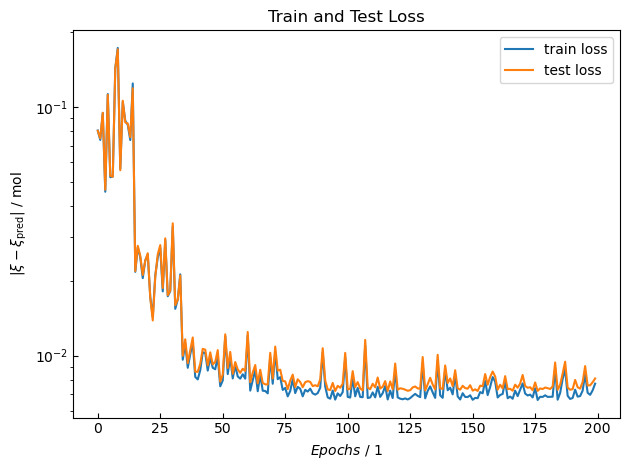

In [9]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2 = 0.9582007584004454
Test Dataset: R^2 = 0.9635826165550792


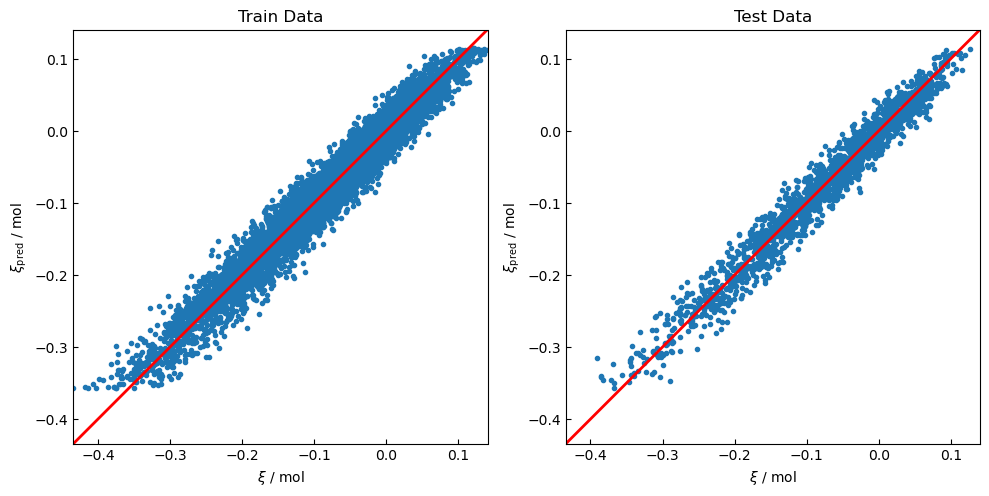

In [10]:
xi_real = []
xi_pred = []
for (X,y) in train_dataloader:
    xi_real = np.append(xi_real, y.numpy())
    xi_pred = np.append(xi_pred, net(X).detach().numpy())

xi_real_test = []
xi_pred_test = []
for (X,y) in test_dataloader:
    xi_real_test = np.append(xi_real_test, y.numpy())
    xi_pred_test = np.append(xi_pred_test, net(X).detach().numpy())

print('Training Dataset: R^2 =', r2(xi_real,xi_pred))
print('Test Dataset: R^2 =', r2(xi_real_test,xi_pred_test))

# find the boundaries of X and Y values
bounds = (min(xi_real.min(), xi_pred.min()) - int(0.1 * xi_pred.min()), max(xi_real.max(), xi_pred.max())+ int(0.1 * xi_pred.max()))

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(xi_real, xi_pred, '.')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(xi_real_test, xi_pred_test, '.')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

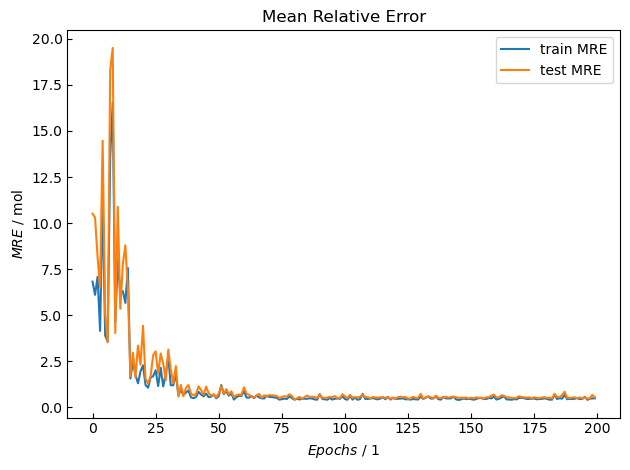

In [11]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_MRE, label='train MRE')
ax.plot(test_MRE, label='test MRE')
plt.title("Mean Relative Error")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

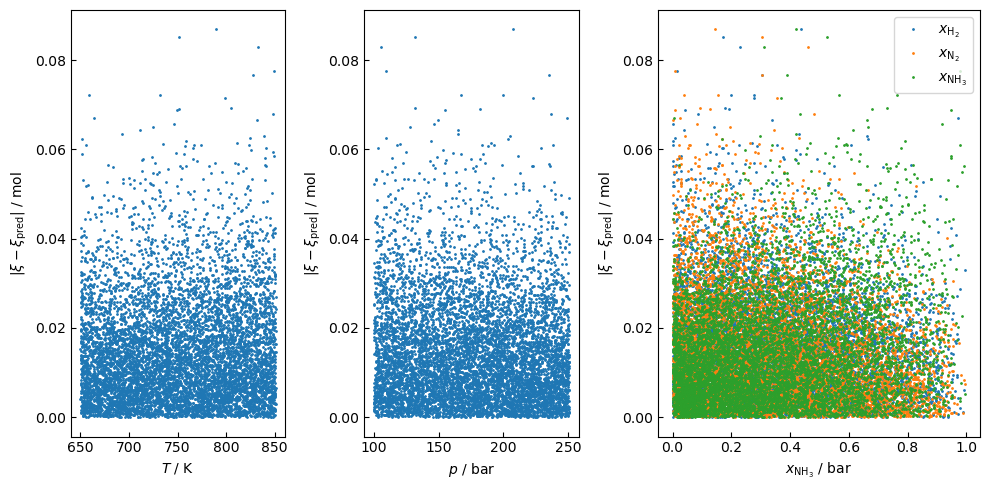

In [12]:
mistake = []
param_T = []
param_p = []
param_x_H2 = []
param_x_N2 = []
param_x_NH3 = []
for X,y in train_dataloader:
    mistake = np.append(mistake, abs(y - net(X).detach().numpy()))
    param_T = np.append(param_T, X[:,0])
    param_p = np.append(param_p, X[:,1])
    param_x_H2 = np.append(param_x_H2, X[:,2])
    param_x_N2 = np.append(param_x_N2, X[:,3])
    param_x_NH3 = np.append(param_x_NH3, X[:,4])
    
# train_parameters, train_xi = next(iter(train_dataloader))
# y = abs(train_xi - net(train_parameters).detach().numpy())
# #[T, p ,x_H2, x_N2, x_NH3]
# x = [train_parameters[:,0], train_parameters[:,1], train_parameters[:,2], train_parameters[:,3], train_parameters[:,4]]

# print(param_T[0])
# print(param_T)
# print(mistake)

fig,ax = plt.subplots(1,3, figsize = (10, 5), gridspec_kw={'width_ratios': [2,2,3]})

ax[0].plot(param_T, mistake, '.', markersize = 2)
ax[0].set(xlabel = '$T$ / K', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)

ax[1].plot(param_p, mistake, '.', markersize = 2)
ax[1].set(xlabel = '$p$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)

ax[2].plot(param_x_H2, mistake, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[2].plot(param_x_N2, mistake, '.', markersize = 2, label = '$x\mathregular{_{N_2}}$')
ax[2].plot(param_x_NH3, mistake, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[2].set(xlabel = '$x\mathregular{_{NH_3}}$ / bar', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol')
ax[2].tick_params(direction = 'in') #, length = 20, width = 3)
ax[2].set

plt.legend()
plt.tight_layout()
plt.show()

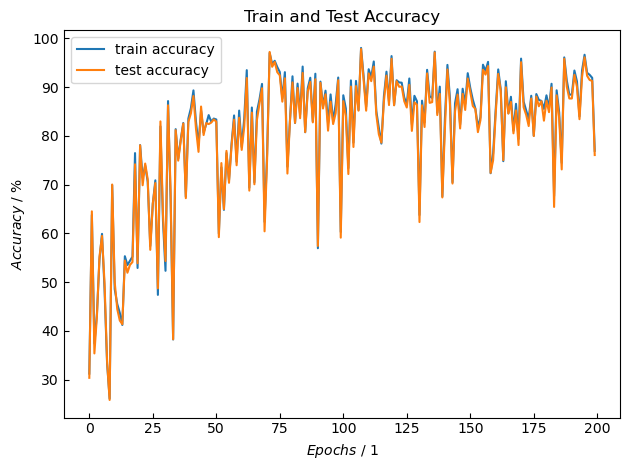

In [13]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [14]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y.reshape((-1,1)))
    print(net(X))
    break

tensor([[7.4797e+02, 2.2294e+02, 6.7593e-01, 9.5234e-02, 2.2884e-01],
        [8.4459e+02, 2.4066e+02, 1.9340e-01, 3.7140e-01, 4.3520e-01],
        [8.3801e+02, 1.5534e+02, 2.6214e-01, 7.4046e-02, 6.6381e-01],
        [6.7602e+02, 2.2572e+02, 9.2315e-01, 4.1157e-02, 3.5698e-02],
        [7.2404e+02, 2.5026e+02, 1.9921e-01, 4.2584e-01, 3.7495e-01],
        [8.1329e+02, 1.4748e+02, 3.5946e-02, 6.8654e-01, 2.7752e-01],
        [7.0846e+02, 1.8593e+02, 9.7085e-02, 4.0348e-01, 4.9944e-01],
        [7.9118e+02, 2.2430e+02, 8.1132e-01, 1.5641e-01, 3.2271e-02],
        [7.7441e+02, 1.6088e+02, 1.4844e-01, 7.9346e-01, 5.8103e-02],
        [8.2406e+02, 2.4232e+02, 4.7205e-02, 2.5293e-01, 6.9987e-01],
        [6.9593e+02, 1.4544e+02, 2.4613e-01, 4.2445e-01, 3.2941e-01],
        [6.7809e+02, 1.6165e+02, 1.5822e-01, 7.4258e-01, 9.9204e-02],
        [8.4582e+02, 1.9734e+02, 3.3763e-01, 5.7509e-01, 8.7288e-02],
        [7.5060e+02, 2.3375e+02, 4.1810e-02, 9.0663e-01, 5.1560e-02],
        [7.4560e+02,

#### Einblick in Netzwerk

In [15]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([1.2892, 1.3100, 0.8972, 1.1168, 0.8814], requires_grad=True),
 Parameter containing:
 tensor([-0.2374,  0.2803, -0.1009,  0.2066, -0.0321], requires_grad=True),
 Parameter containing:
 tensor([[-1.1057e+00,  4.3587e-01, -4.6589e-02,  3.2486e-01,  5.9995e-02],
         [-8.6043e-01,  5.0332e-01,  3.0329e-01, -3.4175e-01, -4.8067e-01],
         [-3.1394e-01, -1.5934e+00,  8.2129e-02, -7.0837e-02, -5.0221e-02],
         [ 2.3546e-01, -8.0784e-02, -9.9829e-02, -3.2350e-01,  5.7629e-01],
         [ 2.9282e-02, -1.8145e-01, -5.8848e-01,  1.3746e-01,  4.3802e-01],
         [ 8.3150e-01, -5.4228e-01,  6.8648e-01, -4.9722e-01,  6.3053e-01],
         [ 5.5459e-01,  9.4077e-03,  6.2513e-01, -9.2016e-01,  4.8663e-01],
         [ 3.4964e-02,  3.3042e-01, -5.2137e-01, -4.4392e-01,  7.9878e-01],
         [ 3.9695e-01, -9.6103e-01,  5.9411e-01,  1.2803e-01,  7.4488e-02],
         [ 3.2537e-01, -3.0122e-01, -3.4491e-01, -5.1587e-01,  1.4017e-01],
         [-6.1267e-01,  

In [16]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.3488, 0.1515, 0.8363, 0.2112, 0.7890],
        [0.9999, 0.6034, 0.4520, 0.6607, 0.7999]])
tensor([[ 0.0210],
        [-0.1551]], grad_fn=<AddmmBackward0>)


In [17]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [18]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    break

tensor([[7.1385e+02, 1.6111e+02, 2.4511e-01, 5.1809e-02, 7.0308e-01],
        [7.0049e+02, 1.0764e+02, 5.1967e-01, 8.9767e-02, 3.9057e-01],
        [7.0071e+02, 2.3276e+02, 4.3495e-01, 3.7777e-01, 1.8729e-01],
        [7.5411e+02, 2.0480e+02, 4.7358e-01, 3.0204e-02, 4.9622e-01],
        [7.4152e+02, 1.9121e+02, 3.3226e-01, 2.2861e-01, 4.3913e-01],
        [7.1753e+02, 1.3231e+02, 8.1306e-01, 1.7251e-01, 1.4427e-02],
        [6.8244e+02, 2.1791e+02, 6.6918e-02, 7.7668e-01, 1.5640e-01],
        [7.3939e+02, 1.4485e+02, 8.6256e-01, 1.1403e-01, 2.3407e-02],
        [8.4751e+02, 1.5292e+02, 7.0039e-01, 1.0949e-01, 1.9012e-01],
        [7.5393e+02, 1.0764e+02, 2.8375e-01, 1.2442e-01, 5.9183e-01],
        [8.0368e+02, 2.4941e+02, 6.8637e-01, 1.1263e-01, 2.0101e-01],
        [6.8988e+02, 2.3428e+02, 1.2363e-01, 8.0806e-01, 6.8309e-02],
        [6.8209e+02, 1.9505e+02, 3.3419e-02, 9.3058e-01, 3.5999e-02],
        [6.7328e+02, 2.4016e+02, 3.1145e-01, 2.2219e-01, 4.6636e-01],
        [8.0115e+02,